In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import shap

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jump2digital/2017_lloguer_preu_trim.csv
/kaggle/input/jump2digital/2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv
/kaggle/input/jump2digital/2017_accidents_causa_conductor_gu_bcn_.csv


La competición dispone de 3 datasets con información sobre distintas zonas de Barcelona: uno sobre el precio de los alquileres, otros sobre nivel de ruido y un tercero de accidentes de tráfico. Se nos pide unificar 2 de los datasets, siendo el dataset base el de alquileres. A simple vista el dataset que puede relacionarse más con los precios de los alquileres es el nivel de ruido, ya que es un aspecto que puede condicionar la elección de una determinada vivienda y el precio de la misma. A fin de cuentas, los accidentes de tráfico tienden a ser eventos menos frecuentes y pueden ser provocadas por causas ajenas a las condiciones y buenas señalizaciones de una determinada vía. No obstante, vamos a realizar una exploración muy básica de los 3 datasets, para asegurarnos de que no hay información adicional en el dataset de accidentes que sea de mayor utilidad que el presente en el dataset de ruido. 

In [2]:
df_alquiler=pd.read_csv('/kaggle/input/jump2digital/2017_lloguer_preu_trim.csv')
df_ruido=pd.read_csv('/kaggle/input/jump2digital/2017_poblacio_exposada_barris_mapa_estrategic_soroll_bcn_long.csv')
df_accidentes=pd.read_csv('/kaggle/input/jump2digital/2017_accidents_causa_conductor_gu_bcn_.csv')

## Basic EDA of the 3 datasets

### Alquiler Dataset

In [3]:
df_alquiler.head(10) #Muestra las 10 primeras filas

Any  Trimestre  Codi_Districte Nom_Districte  Codi_Barri  \
0  2017          1               1  Ciutat Vella           1   
1  2017          1               1  Ciutat Vella           2   
2  2017          1               1  Ciutat Vella           3   
3  2017          1               1  Ciutat Vella           4   
4  2017          1               2      Eixample           5   
5  2017          1               2      Eixample           6   
6  2017          1               2      Eixample           7   
7  2017          1               2      Eixample           8   
8  2017          1               2      Eixample           9   
9  2017          1               2      Eixample          10   

                               Nom_Barri                      Lloguer_mitja  \
0                               el Raval  Lloguer mitjà mensual (Euros/mes)   
1                         el Barri Gòtic  Lloguer mitjà mensual (Euros/mes)   
2                         la Barceloneta  Lloguer mitjà mensual (Euros/mes)   
3  Sant Pere, Santa Caterina i la Ribera  Lloguer mitjà mensual (Euros/mes)   
4                          el Fort Pienc  Lloguer mitjà mensual (Euros/mes)   
5                     la Sagrada Família  Lloguer mitjà mensual (Euros/mes)   
6                 la Dreta de l'Eixample  Lloguer mitjà mensual (Euros/mes)   
7        l'Antiga Esquerra de l'Eixample  Lloguer mitjà mensual (Euros/mes)   
8         la Nova Esquerra de l'Eixample  Lloguer mitjà mensual (Euros/mes)   
9                            Sant Antoni  Lloguer mitjà mensual (Euros/mes)   

      Preu  
0   734.99  
1   905.26  
2   722.78  
3   895.28  
4   871.08  
5   847.04  
6  1151.09  
7  1001.49  
8   909.08  
9   876.97

In [4]:
print(f'El dataset de alquileres tiene {df_alquiler.shape[0]} filas y {df_alquiler.shape[1]} columnas.\n')
print(f'Hay {df_alquiler.duplicated().sum()} duplicados.\n')

table_alquiler = pd.DataFrame({
    "No Unique" : df_alquiler.nunique(),
    "Missing Value": df_alquiler.isnull().sum(),
    'NaNN Value': df_alquiler.isna().sum(),
    'Dtype': df_alquiler.dtypes
})
print('Información del dataset de alquileres:\n')
table_alquiler

El dataset de alquileres tiene 584 filas y 8 columnas.

Hay 0 duplicados.

Información del dataset de alquileres:



No Unique  Missing Value  NaNN Value    Dtype
Any                     1              0           0    int64
Trimestre               4              0           0    int64
Codi_Districte         10              0           0    int64
Nom_Districte          10              0           0   object
Codi_Barri             73              0           0    int64
Nom_Barri              73              0           0   object
Lloguer_mitja           2              0           0   object
Preu                  504             38          38  float64

In [5]:
df_alquiler.describe() #Estadísticas descriptivas del dataset

Any   Trimestre  Codi_Districte  Codi_Barri         Preu
count   584.0  584.000000      584.000000  584.000000   546.000000
mean   2017.0    2.500000        6.246575   37.000000   421.009231
std       0.0    1.118992        2.790726   21.089371   446.178147
min    2017.0    1.000000        1.000000    1.000000     4.450000
25%    2017.0    1.750000        4.000000   19.000000    12.645000
50%    2017.0    2.500000        7.000000   37.000000   161.565000
75%    2017.0    3.250000        8.000000   55.000000   770.347500
max    2017.0    4.000000       10.000000   73.000000  1882.420000

In [6]:
df_alquiler['Lloguer_mitja'].value_counts()

Lloguer_mitja
Lloguer mitjà mensual (Euros/mes)              292
Lloguer mitjà per superfície (Euros/m2 mes)    292
Name: count, dtype: int64

El datasets de alquileres contiene 584 registros de alquileres y 8 columnas (features). No existe duplicidad en los registros y el número total de estos viene dado por el número de barrios (73), números de trimestres (4) y número de medias de alquileres (2). Si observamos los valores de medias de alquileres, vemos que disponemos de una media mensual y una media por superficie. Por tanto, sería posible transformar el dataset, de forma que tuvieramos una columna 'Preu' con la media mensual, 'Preu/m2' con la media por superficie y 'Superficie' con la superficie promedio de las viviendas de alquiler en esa zona. Esta transformación del dataset no sólo nos permitiría crear una nueva feature, 'Superficie', si no que nos permitirá a futuro analizar mejor la distribución de los precios y la posible existencia de outliers. Dado que 'Preu' es la única columna con missing values, será necesario realizar una imputación de estos valores antes de generar la nueva columna 'Superficie'. No obstante, antes de analizar que método usar para realizar esa imputación, será necesario visualizar los valores perdidos en caso de que pueda imputarse a través de la información trimestral de la zona. Por otra parte, de las columnas del datasets, se prescindirá a futuro de las columnas 'Any', 'Nom_Districte' y 'Nom_Barri'. En el caso de 'Any' solo tenemos registros de 2017, en el caso de las otras 2, su información resulta redundate al existir 'Codi_Districte' y 'Codi_Barri'.

### Ruido Dataset

In [7]:
df_ruido.head(10) #Muestra las 10 primeras filas

Codi_Districte Nom_Districte  Codi_Barri Nom_Barri Concepte Rang_soroll  \
0               1  Ciutat Vella           1  el Raval  TOTAL_D      <40 dB   
1               1  Ciutat Vella           1  el Raval  TOTAL_D    40-45 dB   
2               1  Ciutat Vella           1  el Raval  TOTAL_D    45-50 dB   
3               1  Ciutat Vella           1  el Raval  TOTAL_D    50-55 dB   
4               1  Ciutat Vella           1  el Raval  TOTAL_D    55-60 dB   
5               1  Ciutat Vella           1  el Raval  TOTAL_D    60-65 dB   
6               1  Ciutat Vella           1  el Raval  TOTAL_D    65-70 dB   
7               1  Ciutat Vella           1  el Raval  TOTAL_D    70-75 dB   
8               1  Ciutat Vella           1  el Raval  TOTAL_D    75-80 dB   
9               1  Ciutat Vella           1  el Raval  TOTAL_D     >=80 dB   

    Valor  
0   7.73%  
1  26.98%  
2   7.38%  
3  11.97%  
4  19.85%  
5  16.87%  
6   7.06%  
7   2.16%  
8   0.00%  
9   0.00%

In [8]:
print(f'El dataset de ruido tiene {df_ruido.shape[0]} filas y {df_ruido.shape[1]} columnas.\n')
print(f'Hay {df_ruido.duplicated().sum()} duplicados.\n')

table_ruido = pd.DataFrame({
    "No Unique" : df_ruido.nunique(),
    "Missing Value": df_ruido.isnull().sum(),
    'NaNN Value': df_ruido.isna().sum(),
    'Dtype': df_ruido.dtypes
})
print('Información del dataset de ruido:\n')
table_ruido

El dataset de ruido tiene 18980 filas y 7 columnas.

Hay 0 duplicados.

Información del dataset de ruido:



No Unique  Missing Value  NaNN Value   Dtype
Codi_Districte         10              0           0   int64
Nom_Districte          10              0           0  object
Codi_Barri             73              0           0   int64
Nom_Barri              73              0           0  object
Concepte               26              0           0  object
Rang_soroll            10              0           0  object
Valor                3104              0           0  object

In [9]:
df_ruido.describe() #Estadísticas descriptivas del dataset

Codi_Districte    Codi_Barri
count    18980.000000  18980.000000
mean         6.246575     37.000000
std          2.788409     21.071863
min          1.000000      1.000000
25%          4.000000     19.000000
50%          7.000000     37.000000
75%          8.000000     55.000000
max         10.000000     73.000000

In [10]:
df_ruido['Concepte'].value_counts()

Concepte
TOTAL_D        730
TOTAL_E        730
PATIS_E        730
PATIS_D        730
OCI_N          730
VIANANTS_E     730
VIANANTS_D     730
INDUST_DEN     730
INDUST_N       730
INDUST_E       730
INDUST_D       730
FFCC_DEN       730
FFCC_N         730
FFCC_E         730
FFCC_D         730
GI_TR_DEN      730
GI_TR_N        730
GI_TR_E        730
GI_TR_D        730
TRANSIT_DEN    730
TRANSIT_N      730
TRANSIT_E      730
TRANSIT_D      730
TOTAL_DEN      730
TOTAL_N        730
PARCS_D        730
Name: count, dtype: int64

El datasets de ruido contiene 18980 registros de niveles de ruido y 7 features. No existe duplicidad en los registros y el número total de estos viene dado por el número de barrios (73), números de conceptos de ruido (26) y rangos de valores (10). Los conceptos de ruido se catalogan en 9 clases según la procedencia: patios, parques, zonas peatonales, zonas de ocio, zonas industriales, vias ferreoviarias, grandes infraestructuras viarias, transito viario, total; y 4 según la franja horaria: dia, tarde, noche y general (promedio de los otros 3, donde se penalizan los horarios de tarde y noche). Es posible que de cara a integrar estos datos con los de alquileres, solo sea necesario emplear los datos totales de la zona y no por localización concreta, del mismo modo que la franja horaria más interesantes en un principio son la general (por englobar el ruido que se produce en ese zona) y la noctura (al poder afectar a la calidad del sueño y por tanto motivar un más rápido abandono de la vivienda en alquiler, rebajando así su precio). No obstante, en un primer momento combinaremos toda la información disponible y analizaremos que conceptos tienen una relación más significativa con el precio de los alquileres. Para ello se puede optar por 2 opciones, la primera (más conservadora en cuanto a mantener el máximo de información) sería crear 260 nuevas columnas nombradas con las diferentes combinaciones de conceptos y rangos de ruido, siendo los valores de dichas columnas, el valor de la columna 'Valor' para dicha configuración. La segunda podría consistir en calcular el ruido promedio de la zona (según los valores de los rangos de ruido) y sólo crear 26 columnas (en base al concepto) con el ruido promedio calculado (perdiendo la información de posibles picos de ruido máximo).

### Accidentes Dataset

In [11]:
df_accidentes.head(10) #Muestra las 10 primeras filas

Numero_expedient  Codi_districte Nom_districte  Codi_barri   Nom_barri  \
0  2017S004939                  -1    Desconegut          -1  Desconegut   
1  2017S007937                  -1    Desconegut          -1  Desconegut   
2  2017S004739                  -1    Desconegut          -1  Desconegut   
3  2017S008779                  -1    Desconegut          -1  Desconegut   
4  2017S004350                  -1    Desconegut          -1  Desconegut   
5  2017S004109                  -1    Desconegut          -1  Desconegut   
6  2017S004184                  -1    Desconegut          -1  Desconegut   
7  2017S006855                  -1    Desconegut          -1  Desconegut   
8  2017S003196                  -1    Desconegut          -1  Desconegut   
9  2017S005627                  -1    Desconegut          -1  Desconegut   

   Codi_carrer                                         Nom_carrer Num_postal   \
0           -1  Motors                                        ...  43-51        
1           -1  Joan XXIII / Martí i Franquès                 ...         NaN   
2           -1  Corts Catalanes                               ...  900          
3           -1  Número 6 Zona Franca / A Zona Franca          ...         NaN   
4           -1  Aguilar                                       ...  7-9          
5           -1  Zona Franca                                   ...  3            
6           -1  Aribau                                        ...  197-199      
7           -1  Corts Catalanes                               ...  140          
8           -1  Sentís                                        ...  0025         
9           -1  Mare de Déu de Port                           ...  54           

  Descripcio_dia_setmana  NK_Any  Mes_any   Nom_mes  Dia_mes  Hora_dia  \
0                Dimarts    2017        6      Juny        6         8   
1                Dimarts    2017        9  Setembre       26         9   
2                Dilluns    2017        5      Maig       29        22   
3                Dilluns    2017       10   Octubre       23        22   
4                Dimarts    2017        5      Maig       16        14   
5               Diumenge    2017        5      Maig        7        21   
6                 Dijous    2017        5      Maig       11         9   
7               Dimecres    2017        8     Agost        9         5   
8                 Dijous    2017        4     Abril        6        15   
9               Dimecres    2017        6      Juny       28        12   

                   Descripcio_torn Descripcio_causa_conductor  \
0          Desobeir altres senyals                       Matí   
1    Gir indegut o sense precaució                       Matí   
2   Manca d'atenció a la conducció                        Nit   
3          Desobeir altres senyals                        Nit   
4                           Altres                      Tarda   
5                   No determinada                      Tarda   
6  Canvi de carril sense precaució                       Matí   
7                   No determinada                        Nit   
8   Manca d'atenció a la conducció                      Tarda   
9                           Altres                       Matí   

   Coordenada_UTM_X_ED50  Coordenada_UTM_Y_ED50  Longitud    Latitud  
0              427585.89             4577869.16  2.191767  41.411606  
1              426505.49             4581655.96  2.199239  41.419635  
2              432587.59             4584475.05  2.186875  41.412198  
3              427519.99             4575229.36  2.190955  41.406769  
4              430758.19             4586316.94  2.186557  41.409004  
5              428629.73             4578230.12  2.184520  41.406912  
6              429014.84             4583215.45  2.185863  41.402617  
7              427871.64             4579858.44  2.188682  41.403765  
8              433922.08             4587917.81  2.188340  41.411351  
9              429399.61        

In [12]:
print(f'El dataset de accidentes tiene {df_accidentes.shape[0]} filas y {df_accidentes.shape[1]} columnas.\n')
print(f'Hay {df_accidentes.duplicated().sum()} duplicados.\n')

table_accidentes = pd.DataFrame({
    "No Unique" : df_accidentes.nunique(),
    "Missing Value": df_accidentes.isnull().sum(),
    'NaNN Value': df_accidentes.isna().sum(),
    'Dtype': df_accidentes.dtypes
})
print('Información del dataset de accidentes:\n')
table_accidentes

El dataset de accidentes tiene 11091 filas y 20 columnas.

Hay 0 duplicados.

Información del dataset de accidentes:



No Unique  Missing Value  NaNN Value    Dtype
Numero_expedient                10324              0           0   object
Codi_districte                     11              0           0    int64
Nom_districte                      11              0           0   object
Codi_barri                         74              0           0    int64
Nom_barri                          74              0           0   object
Codi_carrer                      1656              0           0    int64
Nom_carrer                       1594              0           0   object
Num_postal                       2107              2           2   object
Descripcio_dia_setmana              7              0           0   object
NK_Any                              1              0           0    int64
Mes_any                            12              0           0    int64
Nom_mes                            12              0           0   object
Dia_mes                            31              0           0    int64
Hora_dia                           24              0           0    int64
Descripcio_torn                    16              0           0   object
Descripcio_causa_conductor          3              0           0   object
Coordenada_UTM_X_ED50            5655              0           0  float64
Coordenada_UTM_Y_ED50            5663              0           0  float64
Longitud                         5696              0           0  float64
Latitud                          5696              0           0  float64

In [13]:
df_accidentes.describe() #Estadísticas descriptivas del dataset

Codi_districte    Codi_barri    Codi_carrer   NK_Any       Mes_any  \
count    11091.000000  11091.000000   11091.000000  11091.0  11091.000000   
mean         4.760256     26.603462  241016.328014   2017.0      6.505816   
std          3.048208     22.200196  193940.152293      0.0      3.435091   
min         -1.000000     -1.000000      -1.000000   2017.0      1.000000   
25%          2.000000      8.000000  110009.000000   2017.0      4.000000   
50%          4.000000     19.000000  191204.000000   2017.0      6.000000   
75%          7.000000     43.000000  312400.000000   2017.0     10.000000   
max         10.000000     73.000000  701864.000000   2017.0     12.000000   

            Dia_mes      Hora_dia  Coordenada_UTM_X_ED50  \
count  11091.000000  11091.000000           11091.000000   
mean      15.802362     13.760346          430116.605946   
std        8.757472      5.300569            2030.298735   
min        1.000000      0.000000          424208.090000   
25%        8.000000     10.000000          428614.300000   
50%       16.000000     14.000000          430155.920000   
75%       23.000000     18.000000          431572.690000   
max       31.000000     23.000000          435119.930000   

       Coordenada_UTM_Y_ED50      Longitud       Latitud  
count           1.109100e+04  11091.000000  11091.000000  
mean            4.583624e+06      2.162875     41.399275  
std             2.346035e+03      0.024180      0.021200  
min             4.575198e+06      2.091855     41.323094  
25%             4.582190e+06      2.144985     41.386288  
50%             4.583336e+06      2.163448     41.396713  
75%             4.584891e+06      2.180188     41.410826  
max             4.591264e+06      2.222572     41.468244

In [14]:
df_accidentes['Numero_expedient'].value_counts()

Numero_expedient
2017S004579        4
2017S008387        3
2017S005943        3
2017S006483        3
2017S007687        3
                  ..
2017S009239        1
2017S010600        1
2017S008562        1
2017S008392        1
2017S005289        1
Name: count, Length: 10324, dtype: int64

In [15]:
df_accidentes.loc[df_accidentes['Numero_expedient']==df_accidentes['Numero_expedient'].value_counts().index[0]]

Numero_expedient  Codi_districte        Nom_districte  Codi_barri  \
2417   2017S004579                   5  Sarrià-Sant Gervasi          23   
2418   2017S004579                   5  Sarrià-Sant Gervasi          23   
9273   2017S004579                   5  Sarrià-Sant Gervasi          23   
10698  2017S004579                   5  Sarrià-Sant Gervasi          23   

      Nom_barri  Codi_carrer Nom_carrer Num_postal  Descripcio_dia_setmana  \
2417     Sarrià        44709   Bonanova   0088 0088               Dimecres   
2418     Sarrià        44709   Bonanova   0088 0088               Dimecres   
9273     Sarrià        44709   Bonanova   0088 0088               Dimecres   
10698    Sarrià        44709   Bonanova   0088 0088               Dimecres   

       NK_Any  Mes_any Nom_mes  Dia_mes  Hora_dia  \
2417     2017        5    Maig       24         8   
2418     2017        5    Maig       24         8   
9273     2017        5    Maig       24         8   
10698    2017        5    Maig       24         8   

                        Descripcio_torn Descripcio_causa_conductor  \
2417           Envair calçada contrària                       Matí   
2418            Desobeir altres senyals                       Matí   
9273      Gir indegut o sense precaució                       Matí   
10698  Avançament defectuós/improcedent                       Matí   

       Coordenada_UTM_X_ED50  Coordenada_UTM_Y_ED50  Longitud    Latitud  
2417               426909.24             4583916.22  2.124472  41.401621  
2418               426909.24             4583916.22  2.124472  41.401621  
9273               426909.24             4583916.22  2.124472  41.401621  
10698              426909.24             4583916.22  2.124472  41.401621

In [16]:
df_accidentes.loc[df_accidentes['Numero_expedient']==df_accidentes['Numero_expedient'].value_counts().index[1]]

Numero_expedient  Codi_districte Nom_districte  Codi_barri  \
437   2017S008387                   2      Eixample           8   
438   2017S008387                   2      Eixample           8   
1881  2017S008387                   2      Eixample           8   

                            Nom_barri  Codi_carrer Nom_carrer Num_postal   \
437   l'Antiga Esquerra de l'Eixample       223606   Muntaner   0083 0083   
438   l'Antiga Esquerra de l'Eixample       223606   Muntaner   0083 0083   
1881  l'Antiga Esquerra de l'Eixample       223606   Muntaner   0083 0083   

     Descripcio_dia_setmana  NK_Any  Mes_any  Nom_mes  Dia_mes  Hora_dia  \
437                Dimecres    2017       10  Octubre       11         9   
438                Dimecres    2017       10  Octubre       11         9   
1881               Dimecres    2017       10  Octubre       11         9   

                      Descripcio_torn Descripcio_causa_conductor  \
437                    No determinada                       Matí   
438   Canvi de carril sense precaució                       Matí   
1881   Manca d'atenció a la conducció                       Matí   

      Coordenada_UTM_X_ED50  Coordenada_UTM_Y_ED50  Longitud    Latitud  
437               429654.51             4582369.59  2.157491  41.387936  
438               429654.51             4582369.59  2.157491  41.387936  
1881              429654.51             4582369.59  2.157491  41.387936

El datasets de accidentes contiene 11091 registros de niveles de ruido, 20 features y ningún duplicado. El número total de registros parece corresponder en su mayoría con los el total de valores de la feature 'Numero_expedient' (10324), aunque se observan filas con un mismo número de expediente. Al examinar 2 de los números de expediente con más de una entrada, observamos que al menos en estos casos las filas son identicas salvo por la columna 'Descripcio_torn'. Según los baremos generales, el dataset sólo contiene 2 missing values para la columna 'Num_postal' (observables en la visualización de las 10 primeras filas), sin embargo 'Nom_districte' y 'Nom_barri' puede recibir el valor 'Desconogut', así como 'Codi_districte' y 'Codi_barri' el valor -1, los cuales son realmente missing values. La información proporcionada por el dataset no parece ofrecer información útil de cara a relacionarla con el dataset de alquileres, por lo que tal como esperabamos, descartaremos este dataset.

## EDA y Feature selection + engineering

En esta sección vamos a explorar más en profundidad los 2 datasets que se han seleccionado, vamos a crear nuevas columnas y eliminar aquellas que consideramos que no aportarán nada para la combinación de los datasets. No se establecen secciones diferenciadas para cada unos de estos 3 procesos, ya que nos interesará entremezclarlos en ocasiones para dar más información del dataset. En el caso de los alquileres, queremos realizar el analisis exploratorio una vez hayamos dividido 'Preu' en 'Preu' ('Lloguer mitjà mensual (Euros/mes)') y 'Preu/m2' ('Lloguer mitjà per superfície (Euros/m2 mes)') y creado a partir de estos 'Superficie'. De forma que podamos ver la evolución de los precios de alquileres para cada distrito y barrio a lo largo de los 4 trismestres de 2017, así como la posible diferencia de superficie según la zona. Para la visualización de estas gráficas aún será util los campos 'Nom_Districte' y 'Nom_Barri', que eliminaremos de cara a combinar el dataset de alquileres con el de ruido. Selección de columnas que también haremos a posteriori en el caso del dataset de ruidos, donde veremos la distribución del ruido entre los diferentes rangos para cada zona, así como el valor promedio de ruido.

## Alquiler Dataset

Como se puede observar a continuación, los 292 primeros registros de alquileres corresponden a la media de alquiler y los 292 registros siguientes corresponden a la media de alquiler por metro cuadrado, guardando el mismo orden. Por tanto, podemos añadir la nueva columna 'Preu/m2' sin problemas, aprovechando para eliminar las columnas 'Any' y 'Lloguer_mitja'. 

In [17]:
df_alquiler.loc[df_alquiler['Lloguer_mitja']=='Lloguer mitjà mensual (Euros/mes)']

Any  Trimestre  Codi_Districte Nom_Districte  Codi_Barri  \
0    2017          1               1  Ciutat Vella           1   
1    2017          1               1  Ciutat Vella           2   
2    2017          1               1  Ciutat Vella           3   
3    2017          1               1  Ciutat Vella           4   
4    2017          1               2      Eixample           5   
..    ...        ...             ...           ...         ...   
287  2017          4              10    Sant Martí          69   
288  2017          4              10    Sant Martí          70   
289  2017          4              10    Sant Martí          71   
290  2017          4              10    Sant Martí          72   
291  2017          4              10    Sant Martí          73   

                                        Nom_Barri  \
0                                        el Raval   
1                                  el Barri Gòtic   
2                                  la Barceloneta   
3           Sant Pere, Santa Caterina i la Ribera   
4                                   el Fort Pienc   
..                                            ...   
287  Diagonal Mar i el Front Marítim del Poblenou   
288                         el Besòs i el Maresme   
289                       Provençals del Poblenou   
290                      Sant Martí de Provençals   
291                           la Verneda i la Pau   

                         Lloguer_mitja     Preu  
0    Lloguer mitjà mensual (Euros/mes)   734.99  
1    Lloguer mitjà mensual (Euros/mes)   905.26  
2    Lloguer mitjà mensual (Euros/mes)   722.78  
3    Lloguer mitjà mensual (Euros/mes)   895.28  
4    Lloguer mitjà mensual (Euros/mes)   871.08  
..                                 ...      ...  
287  Lloguer mitjà mensual (Euros/mes)  1233.01  
288  Lloguer mitjà mensual (Euros/mes)   621.32  
289  Lloguer mitjà mensual (Euros/mes)   864.09  
290  Lloguer mitjà mensual (Euros/mes)   790.58  
291  Lloguer mitjà mensual (Euros/mes)   692.67  

[292 rows x 8 columns]

In [18]:
df_alquiler.loc[df_alquiler['Lloguer_mitja']=='Lloguer mitjà per superfície (Euros/m2 mes)']

Any  Trimestre  Codi_Districte Nom_Districte  Codi_Barri  \
292  2017          1               1  Ciutat Vella           1   
293  2017          1               1  Ciutat Vella           2   
294  2017          1               1  Ciutat Vella           3   
295  2017          1               1  Ciutat Vella           4   
296  2017          1               2      Eixample           5   
..    ...        ...             ...           ...         ...   
579  2017          4              10    Sant Martí          69   
580  2017          4              10    Sant Martí          70   
581  2017          4              10    Sant Martí          71   
582  2017          4              10    Sant Martí          72   
583  2017          4              10    Sant Martí          73   

                                        Nom_Barri  \
292                                      el Raval   
293                                el Barri Gòtic   
294                                la Barceloneta   
295         Sant Pere, Santa Caterina i la Ribera   
296                                 el Fort Pienc   
..                                            ...   
579  Diagonal Mar i el Front Marítim del Poblenou   
580                         el Besòs i el Maresme   
581                       Provençals del Poblenou   
582                      Sant Martí de Provençals   
583                           la Verneda i la Pau   

                                   Lloguer_mitja   Preu  
292  Lloguer mitjà per superfície (Euros/m2 mes)  13.50  
293  Lloguer mitjà per superfície (Euros/m2 mes)  14.14  
294  Lloguer mitjà per superfície (Euros/m2 mes)  19.46  
295  Lloguer mitjà per superfície (Euros/m2 mes)  15.01  
296  Lloguer mitjà per superfície (Euros/m2 mes)  12.77  
..                                           ...    ...  
579  Lloguer mitjà per superfície (Euros/m2 mes)  16.51  
580  Lloguer mitjà per superfície (Euros/m2 mes)  10.40  
581  Lloguer mitjà per superfície (Euros/m2 mes)  12.66  
582  Lloguer mitjà per superfície (Euros/m2 mes)  10.83  
583  Lloguer mitjà per superfície (Euros/m2 mes)  10.38  

[292 rows x 8 columns]

In [19]:
new_df_alquiler=df_alquiler.loc[df_alquiler['Lloguer_mitja']=='Lloguer mitjà mensual (Euros/mes)'].copy()
new_df_alquiler.drop(columns=['Any','Lloguer_mitja'],inplace=True)
new_df_alquiler.loc[:,'Preu/m2']=df_alquiler['Preu'].loc[df_alquiler['Lloguer_mitja']=='Lloguer mitjà per superfície (Euros/m2 mes)'].values
new_df_alquiler

Trimestre  Codi_Districte Nom_Districte  Codi_Barri  \
0            1               1  Ciutat Vella           1   
1            1               1  Ciutat Vella           2   
2            1               1  Ciutat Vella           3   
3            1               1  Ciutat Vella           4   
4            1               2      Eixample           5   
..         ...             ...           ...         ...   
287          4              10    Sant Martí          69   
288          4              10    Sant Martí          70   
289          4              10    Sant Martí          71   
290          4              10    Sant Martí          72   
291          4              10    Sant Martí          73   

                                        Nom_Barri     Preu  Preu/m2  
0                                        el Raval   734.99    13.50  
1                                  el Barri Gòtic   905.26    14.14  
2                                  la Barceloneta   722.78    19.46  
3           Sant Pere, Santa Caterina i la Ribera   895.28    15.01  
4                                   el Fort Pienc   871.08    12.77  
..                                            ...      ...      ...  
287  Diagonal Mar i el Front Marítim del Poblenou  1233.01    16.51  
288                         el Besòs i el Maresme   621.32    10.40  
289                       Provençals del Poblenou   864.09    12.66  
290                      Sant Martí de Provençals   790.58    10.83  
291                           la Verneda i la Pau   692.67    10.38  

[292 rows x 7 columns]

Una vez creada la nueva tabla, vamos analizar como se distribuyen ahora los missing values presentes en la columna original de 'Preu'.

In [20]:
table_alquiler = pd.DataFrame({
    "No Unique" : new_df_alquiler.nunique(),
    "Missing Value": new_df_alquiler.isnull().sum(),
    'NaNN Value': new_df_alquiler.isna().sum(),
    'Dtype': new_df_alquiler.dtypes
})
print('Información del nuevo dataset de alquileres:\n')
table_alquiler

Información del nuevo dataset de alquileres:



No Unique  Missing Value  NaNN Value    Dtype
Trimestre               4              0           0    int64
Codi_Districte         10              0           0    int64
Nom_Districte          10              0           0   object
Codi_Barri             73              0           0    int64
Nom_Barri              73              0           0   object
Preu                  272             19          19  float64
Preu/m2               232             19          19  float64

In [21]:
new_df_alquiler.loc[new_df_alquiler['Preu'].isna()]

Trimestre  Codi_Districte   Nom_Districte  Codi_Barri  \
11           1               3  Sants-Montjuïc          12   
41           1               7  Horta-Guinardó          42   
46           1               8      Nou Barris          47   
55           1               8      Nou Barris          56   
57           1               9     Sant Andreu          58   
84           2               3  Sants-Montjuïc          12   
114          2               7  Horta-Guinardó          42   
126          2               8      Nou Barris          54   
130          2               9     Sant Andreu          58   
157          3               3  Sants-Montjuïc          12   
187          3               7  Horta-Guinardó          42   
192          3               8      Nou Barris          47   
201          3               8      Nou Barris          56   
203          3               9     Sant Andreu          58   
230          4               3  Sants-Montjuïc          12   
260          4               7  Horta-Guinardó          42   
265          4               8      Nou Barris          47   
274          4               8      Nou Barris          56   
276          4               9     Sant Andreu          58   

                      Nom_Barri  Preu  Preu/m2  
11   la Marina del Prat Vermell   NaN      NaN  
41                     la Clota   NaN      NaN  
46                  Can Peguera   NaN      NaN  
55                     Vallbona   NaN      NaN  
57                Baró de Viver   NaN      NaN  
84   la Marina del Prat Vermell   NaN      NaN  
114                    la Clota   NaN      NaN  
126                  Torre Baró   NaN      NaN  
130               Baró de Viver   NaN      NaN  
157  la Marina del Prat Vermell   NaN      NaN  
187                    la Clota   NaN      NaN  
192                 Can Peguera   NaN      NaN  
201                    Vallbona   NaN      NaN  
203               Baró de Viver   NaN      NaN  
230  la Marina del Prat Vermell   NaN      NaN  
260                    la Clota   NaN      NaN  
265                 Can Peguera   NaN      NaN  
274                    Vallbona   NaN      NaN  
276               Baró de Viver   NaN      NaN

In [22]:
miss_barrio,miss_counts=np.unique(new_df_alquiler['Codi_Barri'].loc[new_df_alquiler['Preu'].isna()].to_numpy(),return_counts=True)
print(miss_barrio)
print(miss_counts)

[12 42 47 54 56 58]
[4 4 3 1 3 4]


Como podemos ver cuando existe un missing value en 'Preu', también existe un missing value en 'Preu/m2'. Por otra parte vemos que de los 6 barrios con missing values, 3 de ellos no tienen información de los precios para ningún trimestre, 2 de ellos sólo disponen de información de los precios para un trismestre y 1 barrio posee sólo un missing value (barrio 54). Por tanto, eliminaremos los 5 barrios que no tienen ningún registro de precio de alquileres o uno solo e imputaremos el valor del trimestre faltante para el barrio 54. Esta perdida de 5 de barrios no será significativa dentro de los 73 totales, teniendo en cuenta, como se puede ver a continuación, de que dichos barrios pertenecen a los distritos con más barrios.

In [23]:
new_df_alquiler['Codi_Districte'].value_counts()/4 #Numero de barrios por distritos, eliminando la duplicidad de los 4 trimestres

Codi_Districte
8     13.0
7     11.0
10    10.0
3      8.0
9      7.0
2      6.0
5      6.0
6      5.0
1      4.0
4      3.0
Name: count, dtype: float64

In [24]:
remove_barrio=np.delete(miss_barrio,np.where(miss_barrio==54))
new_df_alquiler=new_df_alquiler.loc[new_df_alquiler['Codi_Barri'].isin(remove_barrio)==False]
new_df_alquiler.reset_index(drop=True,inplace=True)

In [25]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=2)
ids=new_df_alquiler.loc[new_df_alquiler['Codi_Barri']==54].index
X=np.array(new_df_alquiler.iloc[ids,-2:])
imputed=np.round(imputer.fit_transform(X),2)
new_df_alquiler.iloc[ids,-2:]=imputed
new_df_alquiler.iloc[ids]

Trimestre  Codi_Districte Nom_Districte  Codi_Barri   Nom_Barri    Preu  \
50           1               8    Nou Barris          54  Torre Baró  418.07   
118          2               8    Nou Barris          54  Torre Baró  443.16   
186          3               8    Nou Barris          54  Torre Baró  463.17   
254          4               8    Nou Barris          54  Torre Baró  448.23   

     Preu/m2  
50      7.26  
118     7.09  
186     6.84  
254     7.17

Añadimos la columna 'Superficie'.

In [26]:
new_df_alquiler.insert(len(new_df_alquiler.columns),'Superficie',np.round(np.array(new_df_alquiler['Preu']/new_df_alquiler['Preu/m2']),2))
new_df_alquiler

Trimestre  Codi_Districte Nom_Districte  Codi_Barri  \
0            1               1  Ciutat Vella           1   
1            1               1  Ciutat Vella           2   
2            1               1  Ciutat Vella           3   
3            1               1  Ciutat Vella           4   
4            1               2      Eixample           5   
..         ...             ...           ...         ...   
267          4              10    Sant Martí          69   
268          4              10    Sant Martí          70   
269          4              10    Sant Martí          71   
270          4              10    Sant Martí          72   
271          4              10    Sant Martí          73   

                                        Nom_Barri     Preu  Preu/m2  \
0                                        el Raval   734.99    13.50   
1                                  el Barri Gòtic   905.26    14.14   
2                                  la Barceloneta   722.78    19.46   
3           Sant Pere, Santa Caterina i la Ribera   895.28    15.01   
4                                   el Fort Pienc   871.08    12.77   
..                                            ...      ...      ...   
267  Diagonal Mar i el Front Marítim del Poblenou  1233.01    16.51   
268                         el Besòs i el Maresme   621.32    10.40   
269                       Provençals del Poblenou   864.09    12.66   
270                      Sant Martí de Provençals   790.58    10.83   
271                           la Verneda i la Pau   692.67    10.38   

     Superficie  
0         54.44  
1         64.02  
2         37.14  
3         59.65  
4         68.21  
..          ...  
267       74.68  
268       59.74  
269       68.25  
270       73.00  
271       66.73  

[272 rows x 8 columns]

### Evolución de los precios y superficies de los alquileres por Distrito

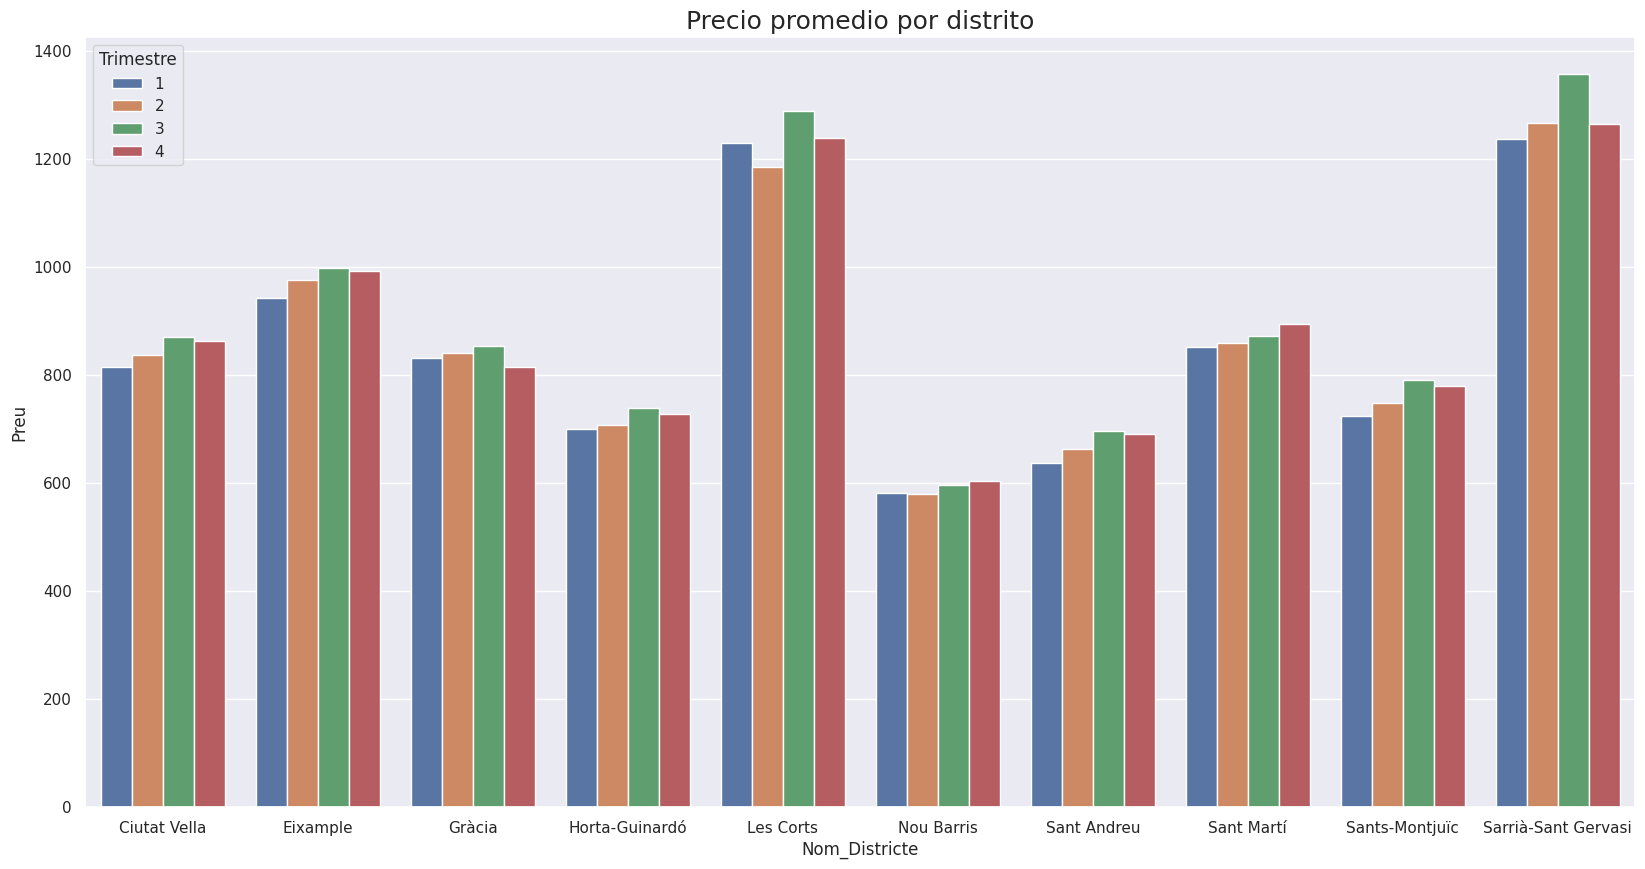

In [27]:
df_grouped = new_df_alquiler.groupby(['Nom_Districte','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Districte',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

Esta gráfica nos muestra que los distritos con precios de alquileres más caros son los de los distritos de Les Corts y Sarrià-Sant Gervasi, mientras que los más baratos son los de Nou Barris. También podemos ver que la tendencia de los precios ha sido mayormente creciente a lo largo de los trimestres de 2017, siendo el tercer trimestre donde más han solido crecer.

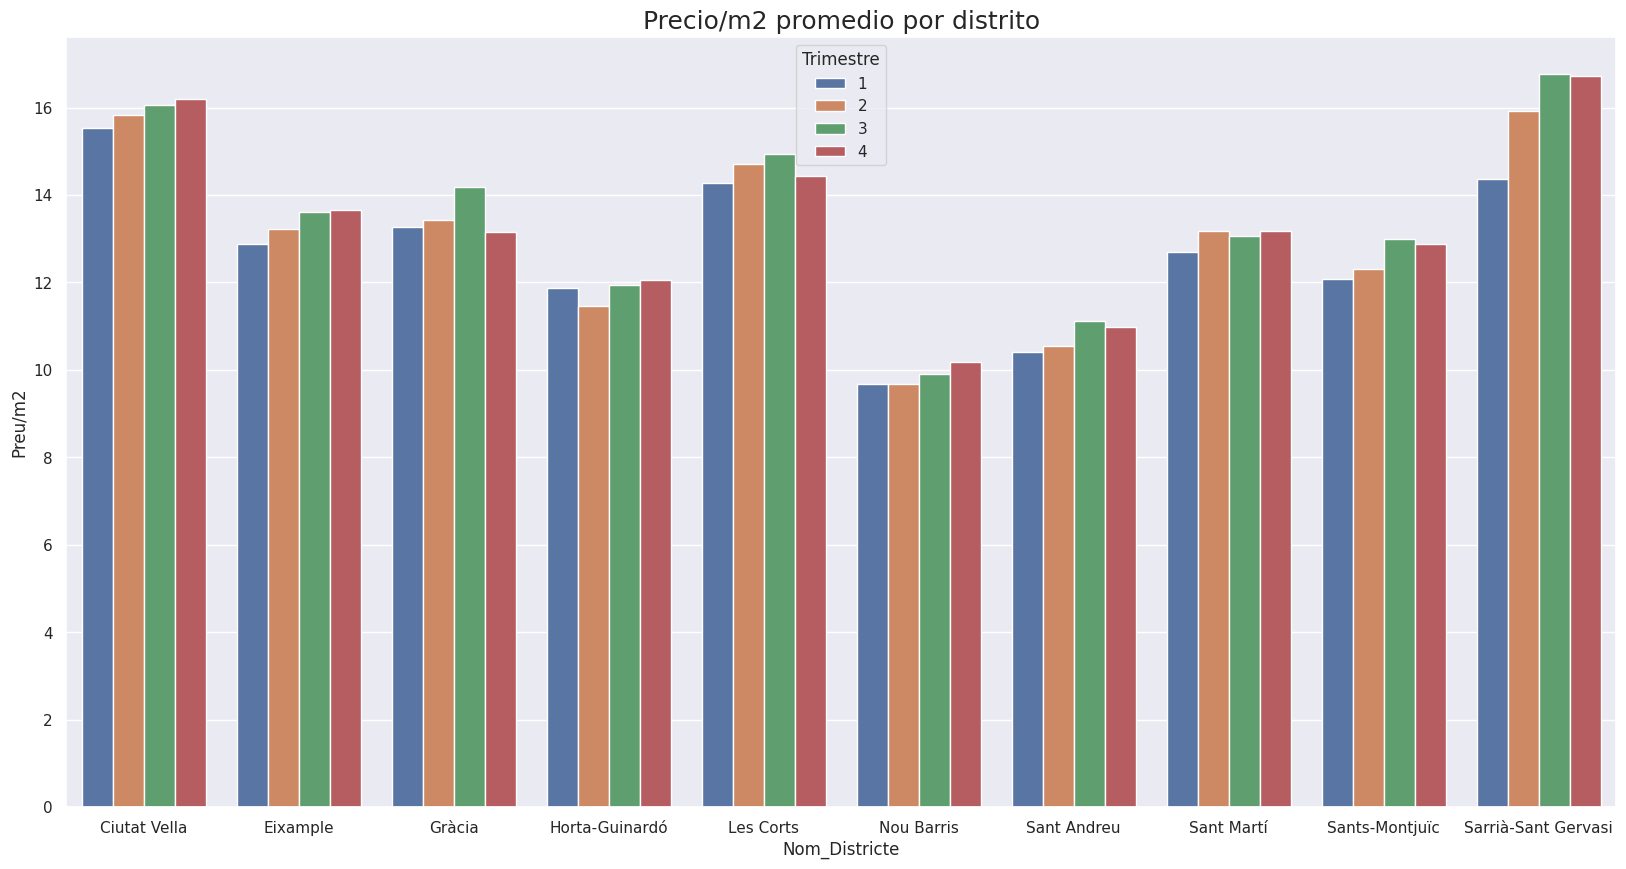

In [28]:
df_grouped = new_df_alquiler.groupby(['Nom_Districte','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Districte',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

Esta gráfica nos muestra que los distritos con mayor precio por metro cuadrado son los de Sarrià-Sant Gervasi y Ciutat Vella, mientras que el distrito más barato sigue siendo Nou Barris. La subida de los precios sigue mostrando una tendencia creciente a lo largo de los trimestres, siendo destacable la subida sufrida en el distrito de Sarrià-Sant Gervasi.

In [29]:
df_grouped = new_df_alquiler.groupby(['Nom_Districte','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Districte',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

Por último, la gráfica de en función de la superfie, nos señala que las viviendas en alquiler más grandes se encuentran en los barrios de Les Corts, Sarrià-Sant Gervasi (80m2) y Eixample (75m2) y las viviendas más pequeñas en Ciutat Vella (55m2), encontrandose el resto de distritos en una superficie promedio de 60m2. A diferencia de los precios, la evolución de las superficie no muestra una tendencia clara, ya que el tamaño de las viviendas en alquiler dependerá de la oferta de los inmuebles en cada momento. Como mucho se podría quizás sugerir que la subida del precio por métro cuadrado en Sarrià-Sant Gervasi ha llevado a que se aumente progresivamente el alquiler de viviendas más pequeñas.

### Evolución de los precios y superficies en Ciutat Vella

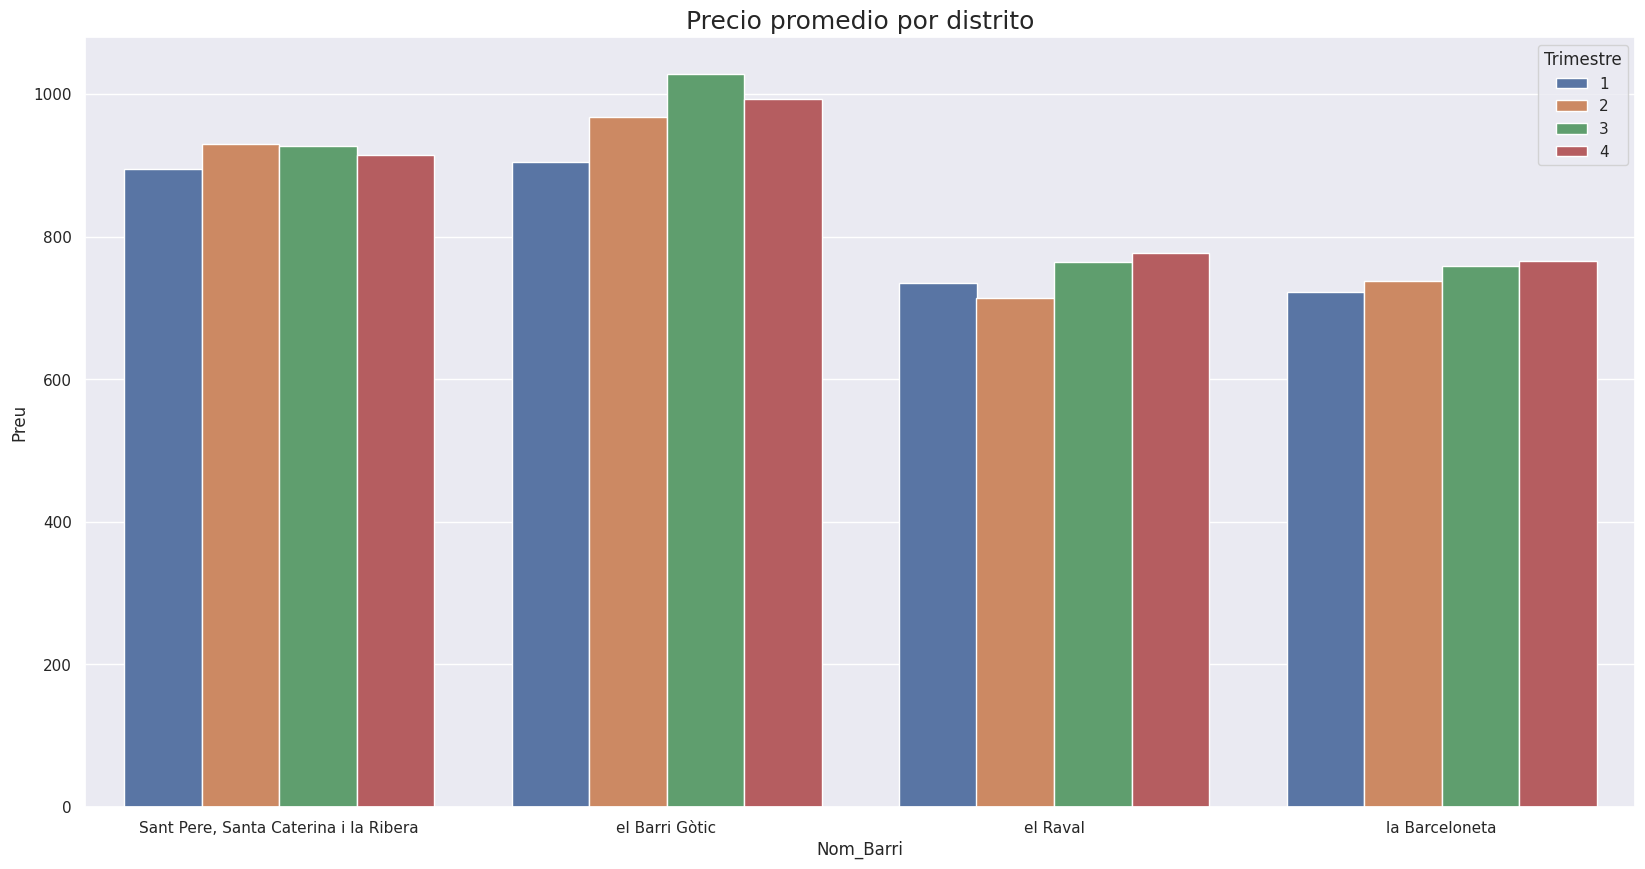

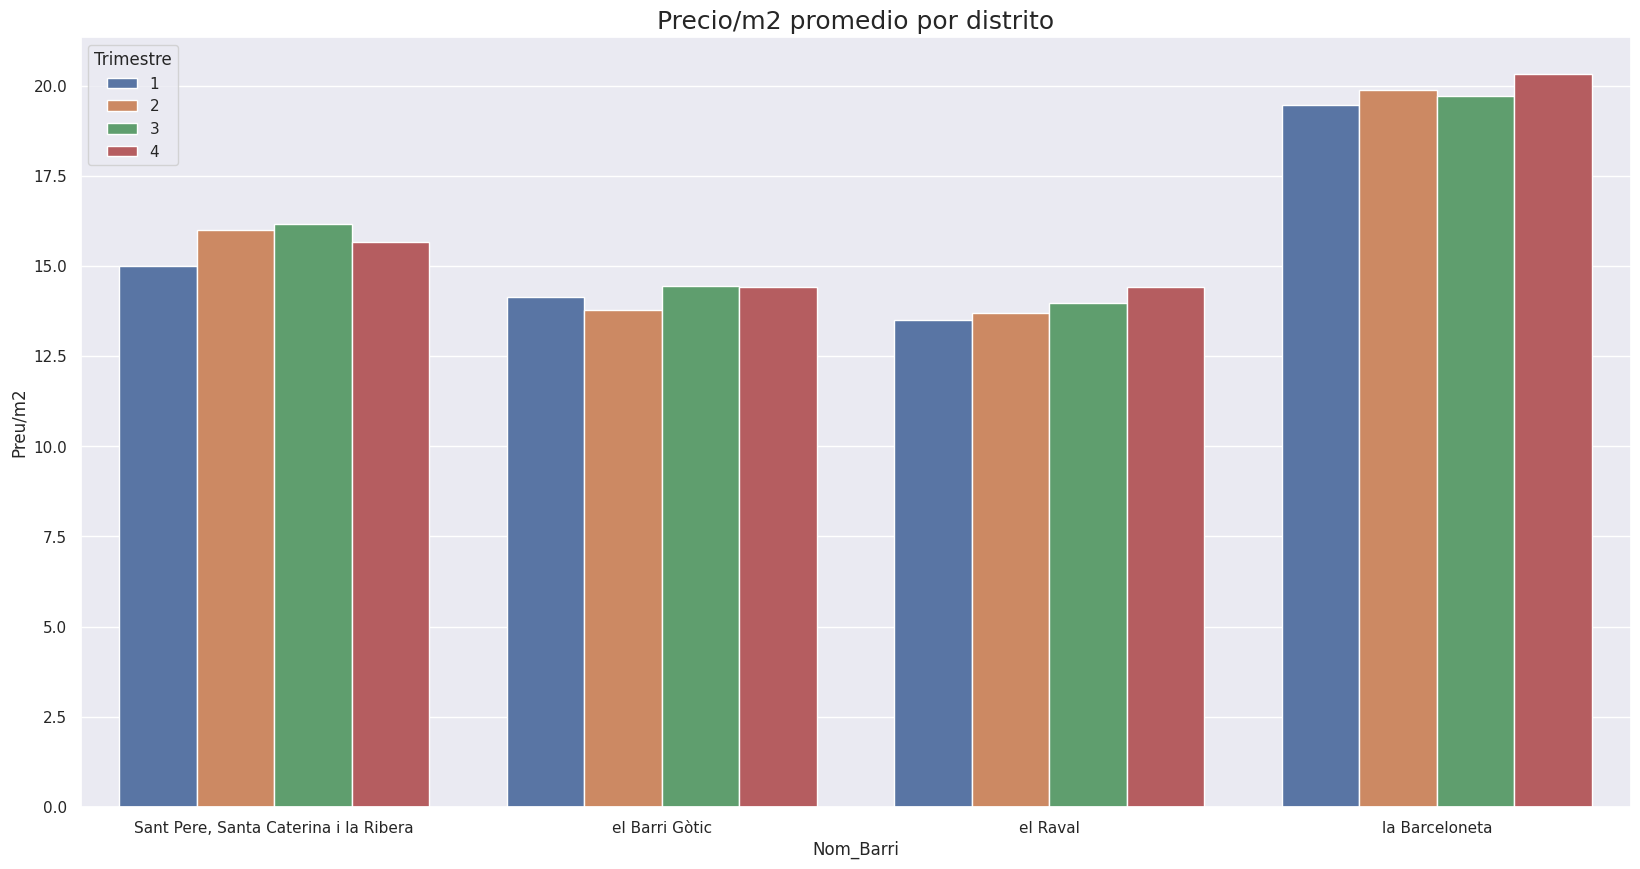

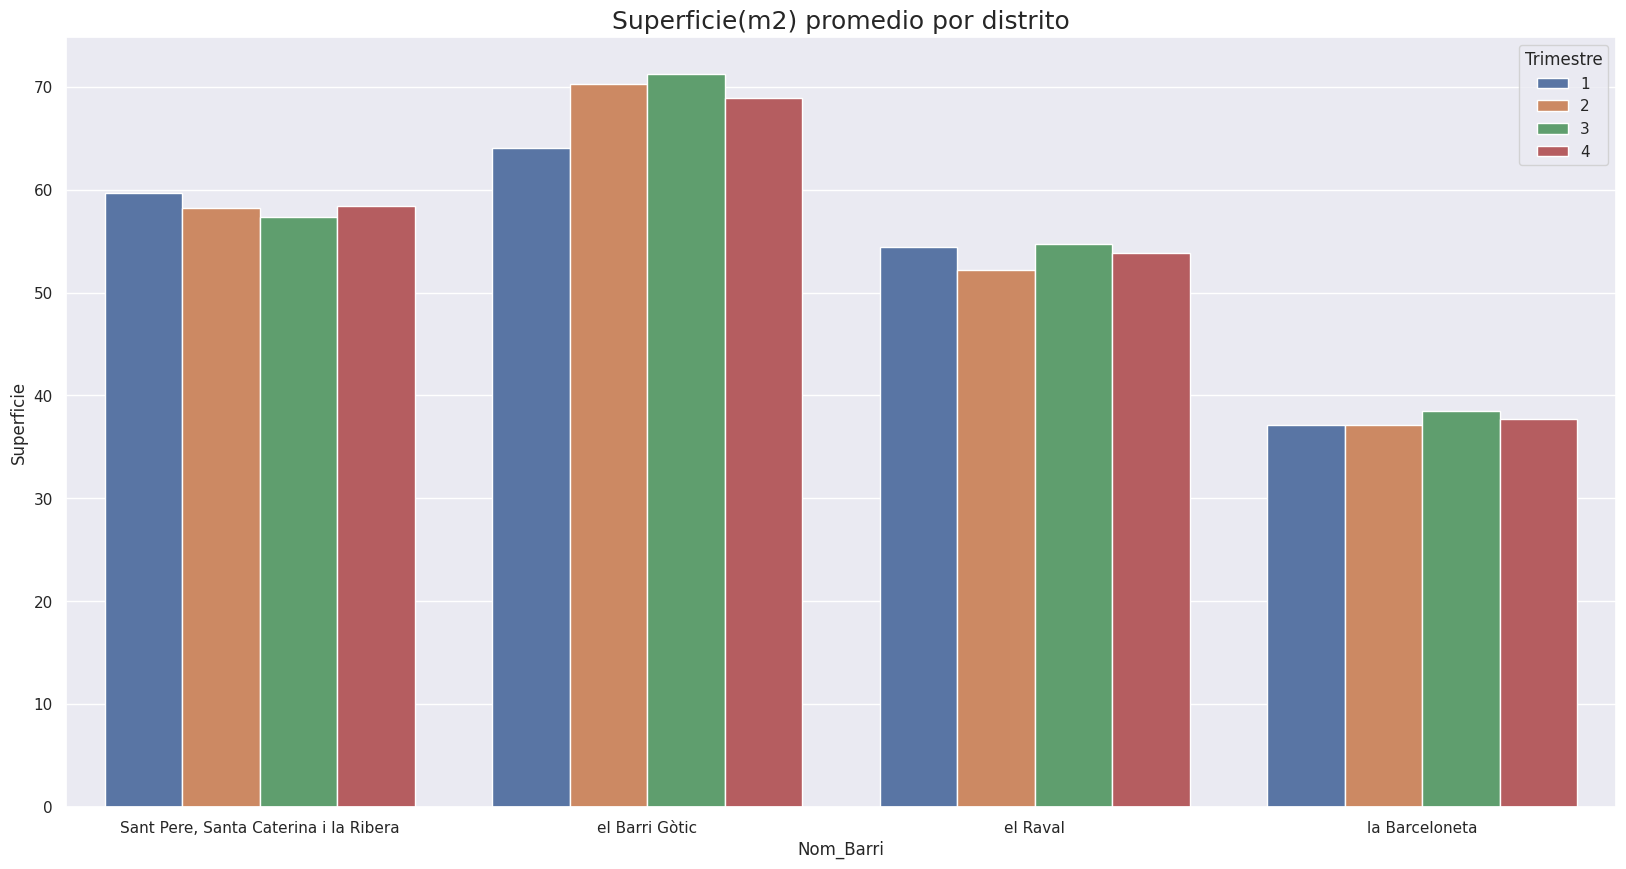

In [30]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Ciutat Vella']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

El barrio con alquileres más altos de Ciutat Vella es el Barri Gótic y los más baratos el Raval y la Barceloneta. Sin embargo, el barrio más caro por metro cuadrado es la Barceloneta (20€/m2 respecto a los 15€/m2 del resto de barrios). Siendo obviamente la razón que las viviendas más pequeñas se encuentran en la Barceloneta (<40m2), mientras las viviendas más grandes se encuentran en el Barri Gòtic (70m2). La tendencia de los precios como se vio previamente para los distritos tiende al alza. Razón por lo que no se comentará más esta tendencia salvo en casos excepcionales.

### Evolución de los precios y superficies en Eixample

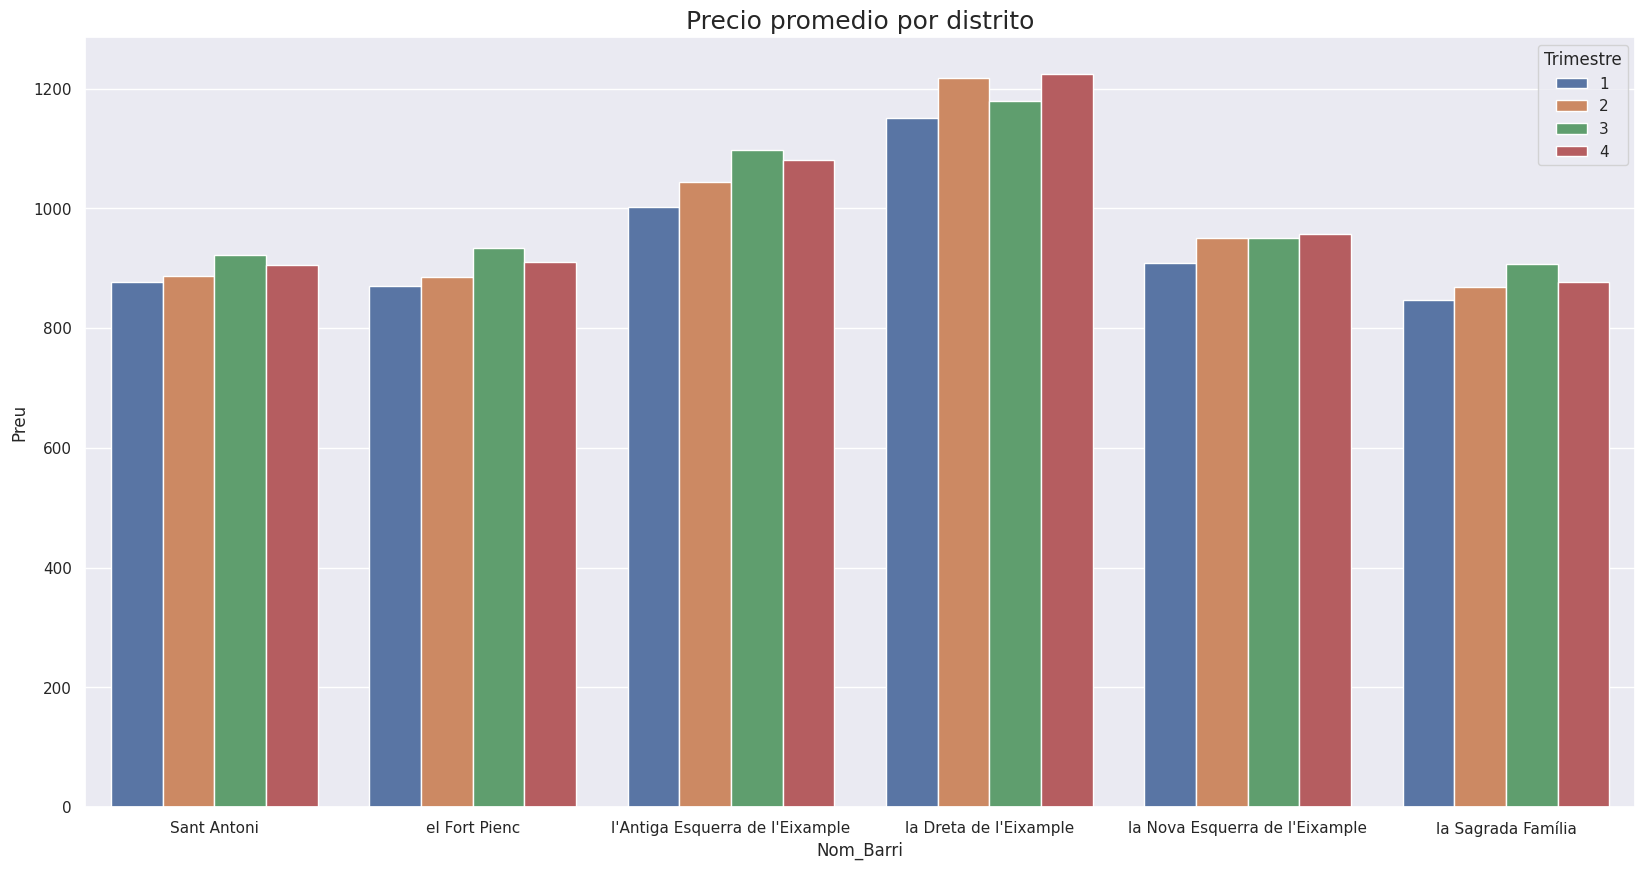

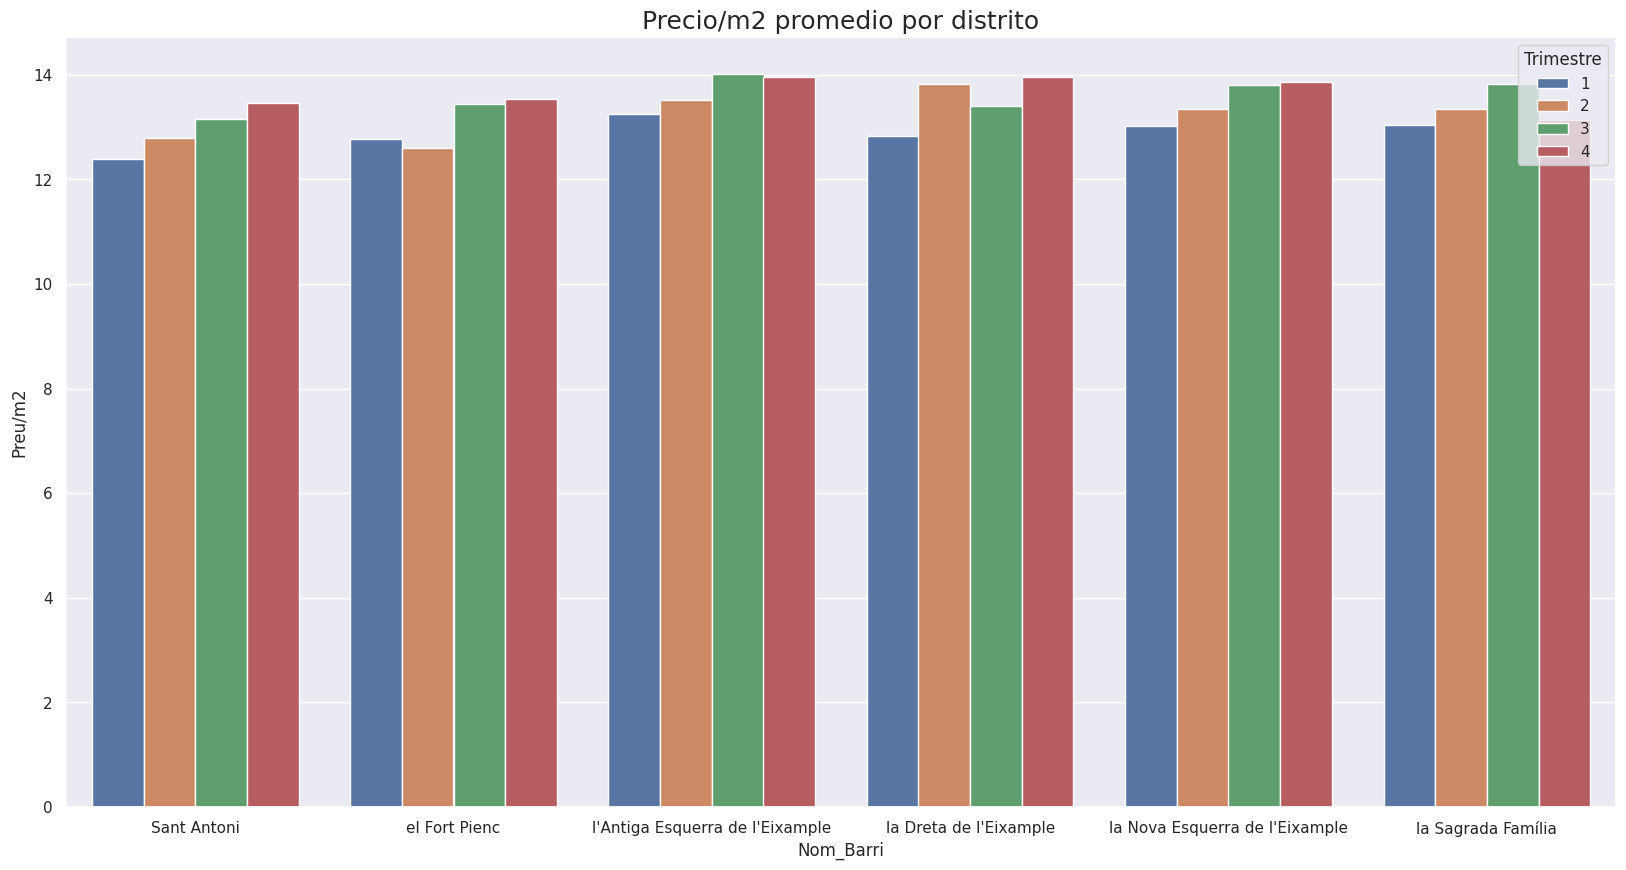

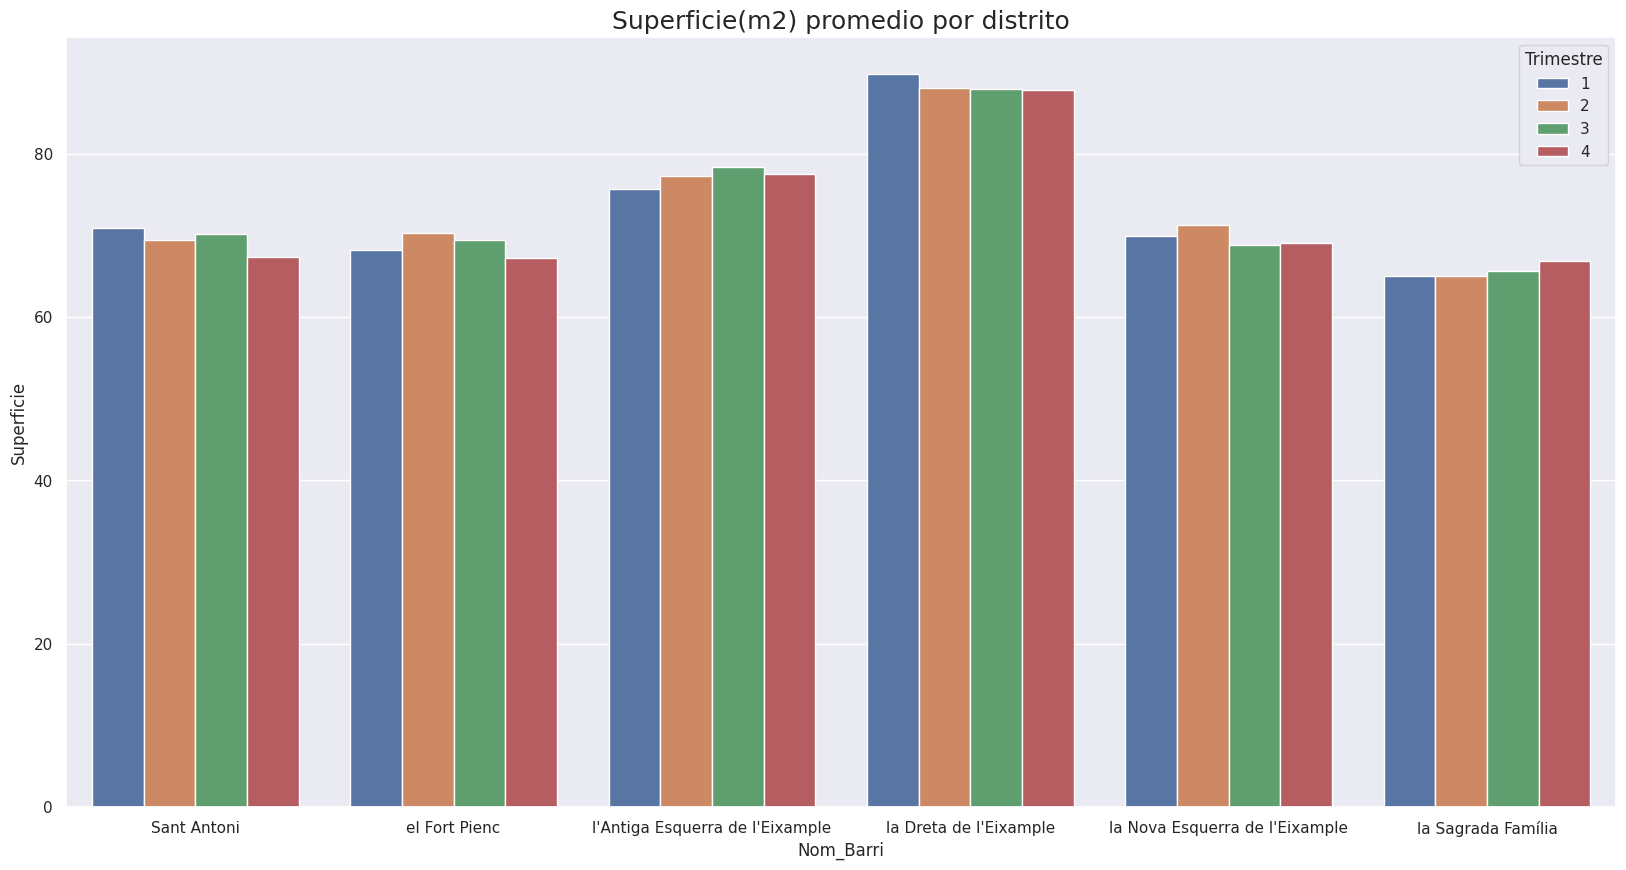

In [31]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Eixample']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

La evolución de los precios por metro cuadrado ha sido similar en todos los barrios de Eixample, razón  por la cual la diferencia de los precios de los alquileres de sus viviendas dependan directamente de la superficie de las mismas. Siendo el barrio con viviendas más grandes (90m2) y por tanto más caras (1200€) el de la Dreta de l'Eixample.

### Evolución de los precios y superficies en Gràcia

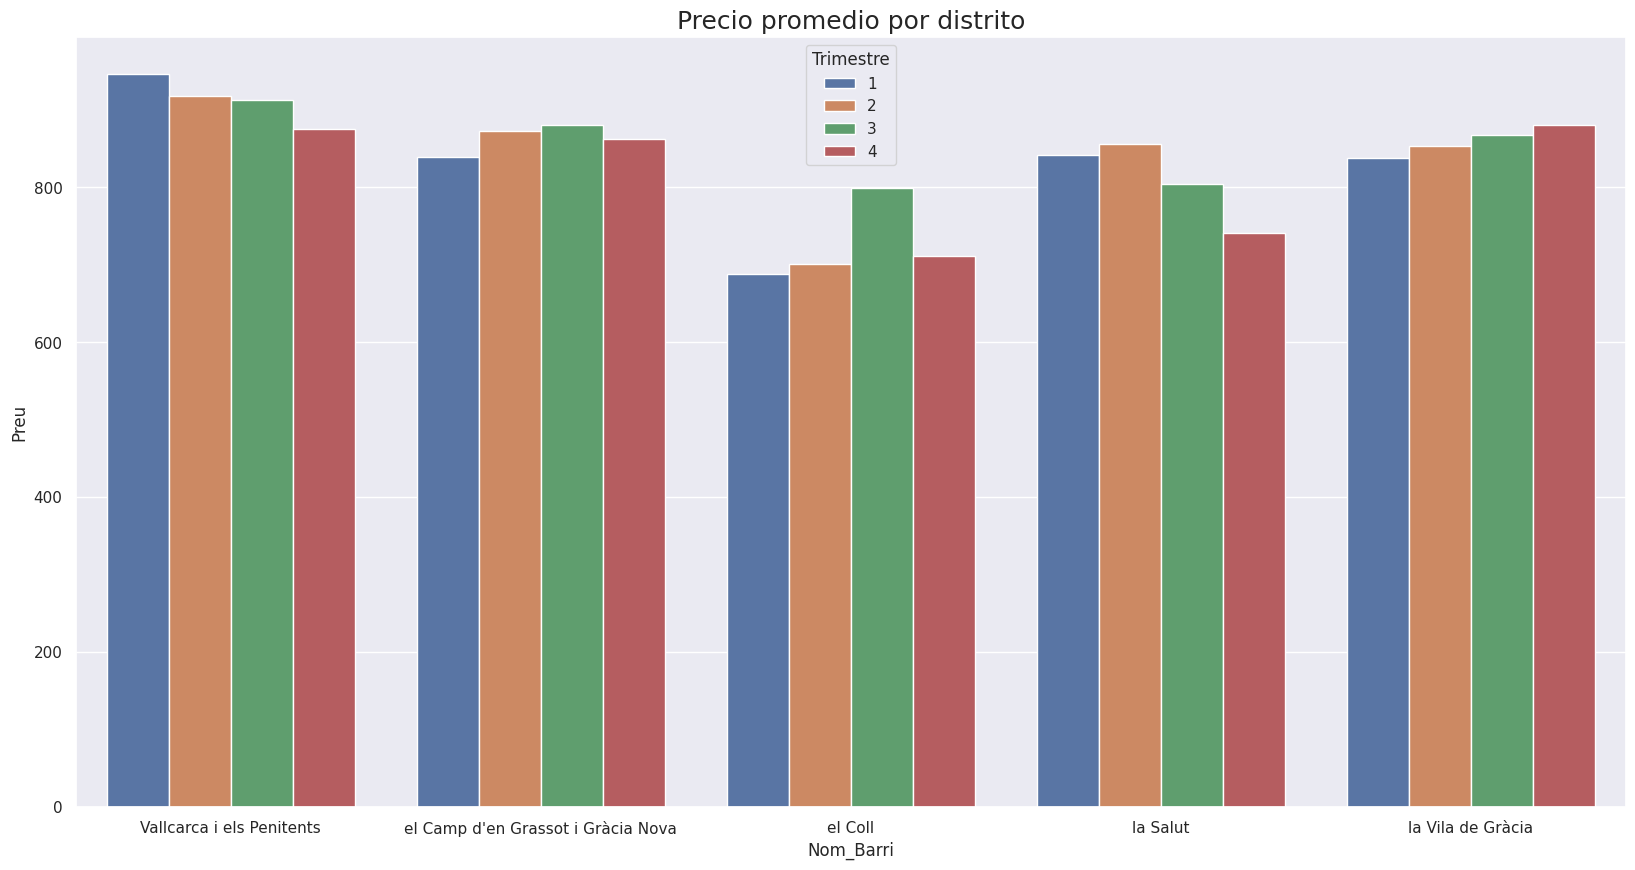

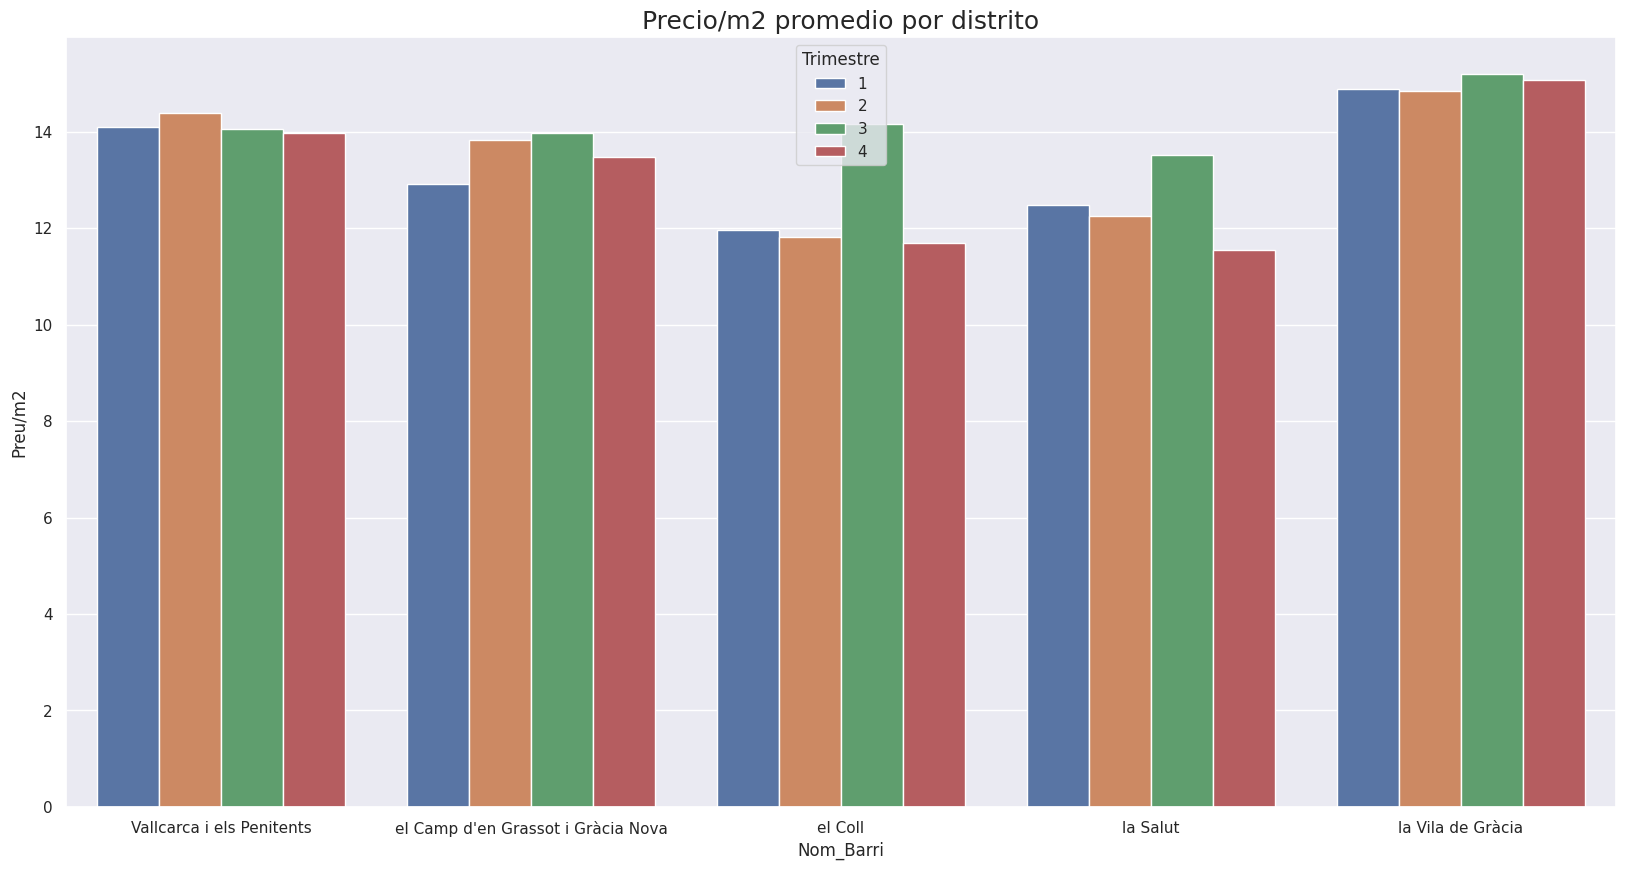

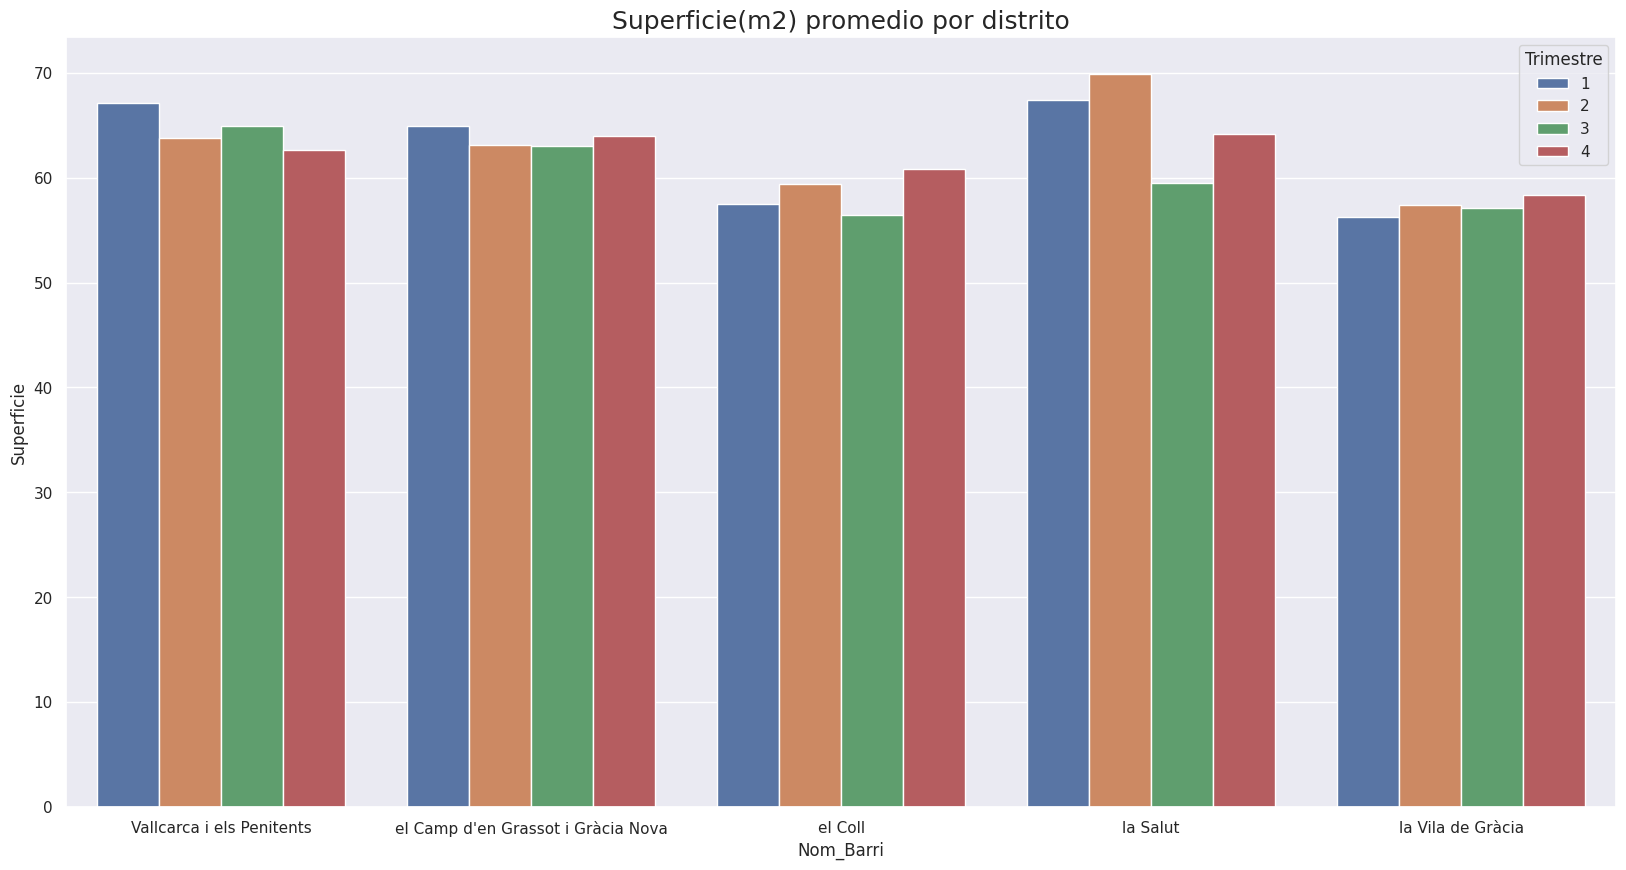

In [32]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Gràcia']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

El barrio con alquileres más caros es Vallcarca i els Penitents (900€), mientras que el más barato es el Coll (700€). Cabe destacar que tanto el precio de Vallcarca i els Penitents y la Salut ha tendido una caida a lo largo de los trimestres de 2017, más relacionada por la reducción del tamaño de la viviendas que por el precio del metro cuadrado. El precio por metro cuadrado más caro se encuentra en la Vila de Gràcia (15€/m2), mientras que los más baratos en el Coll y la Salut (13€/m2). Siendo por el contrario las viviendas de la Salut las más mayores (65m2) y la Vila de Gràcia las más pequeñas (55m2).

### Evolución de los precios y superficies en Horta-Guinardó

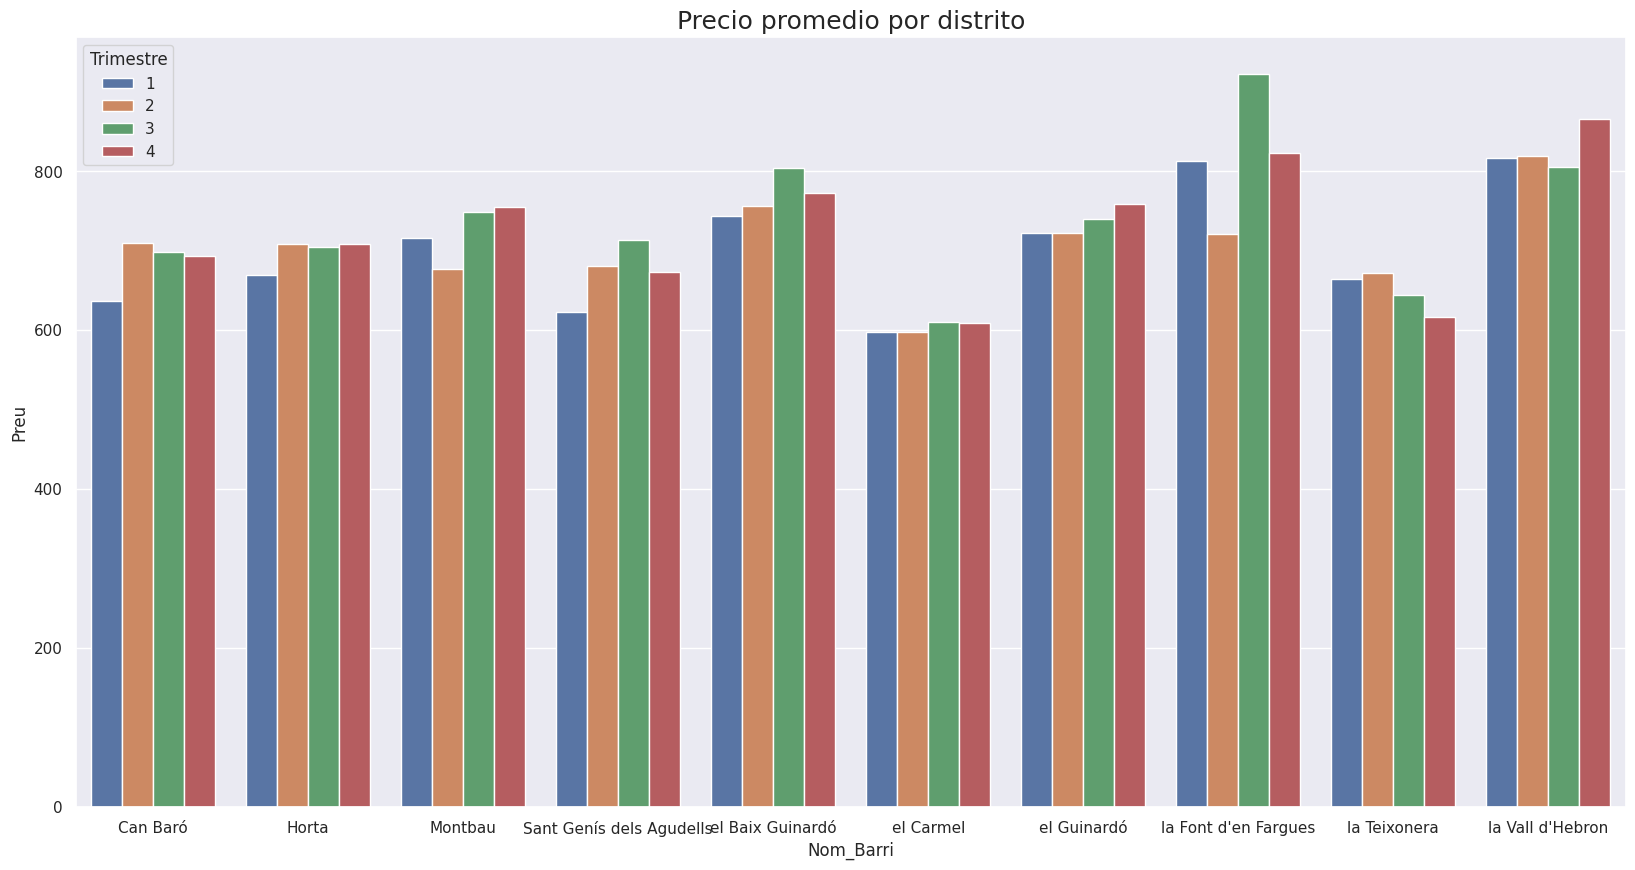

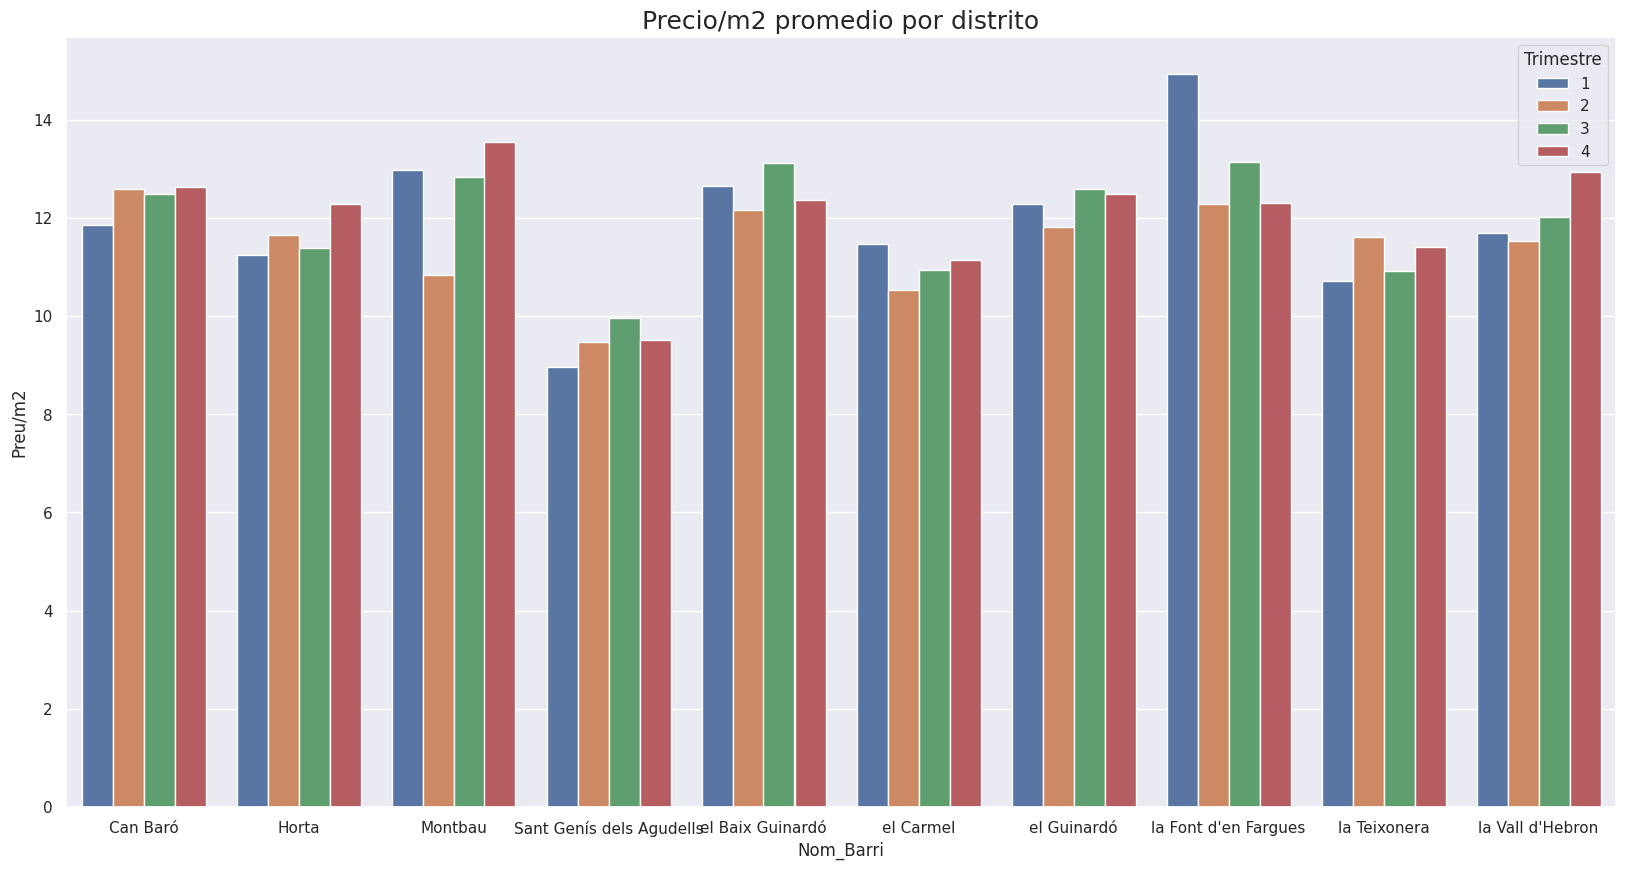

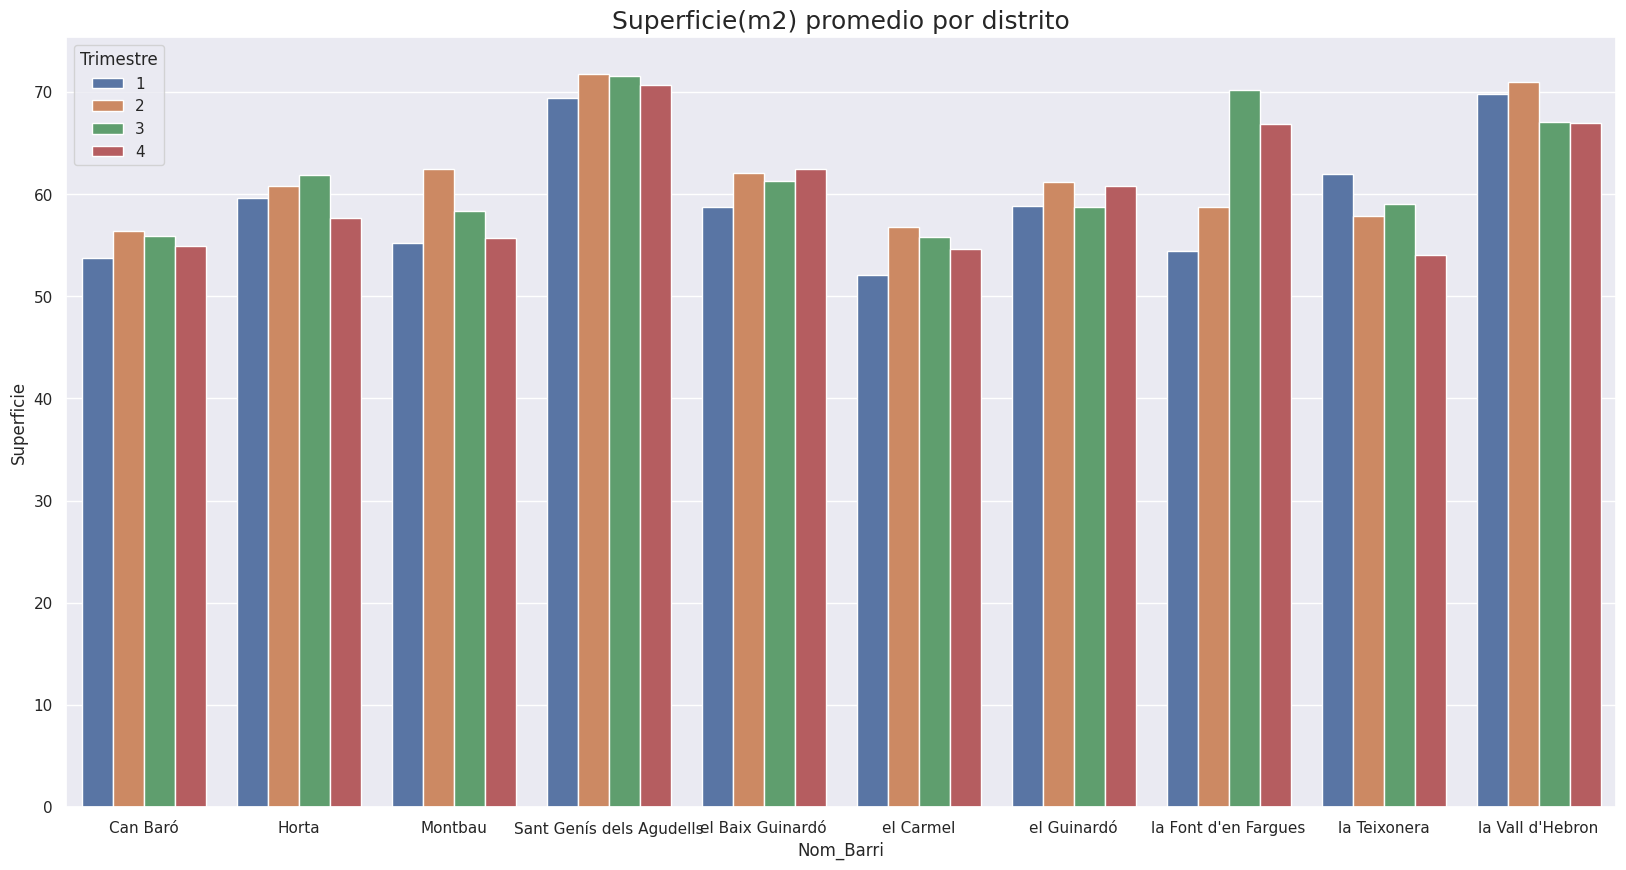

In [33]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Horta-Guinardó']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

El barrio más caro tanto en terminos totales como por metro cuadrado es la Font d'en Fargues (800€,13€/m2), el cual ha experimentado una tendencia decreciente en el precio del metro cuadrado. El barrio más barato en terminos generales es el Carmel (600€), aunque por metro cuadrado es Sant Genís dels Agudells (9€/m2). Sant Genís dels Aguadells junto con la Vall d'Hebron son los barrios con viviendas más grandes (70m2), mientras que Can Baró y el Carmel son los barrios con viviendas más pequeñas (55m2)

### Evolución de los precios y superficies en Les Corts

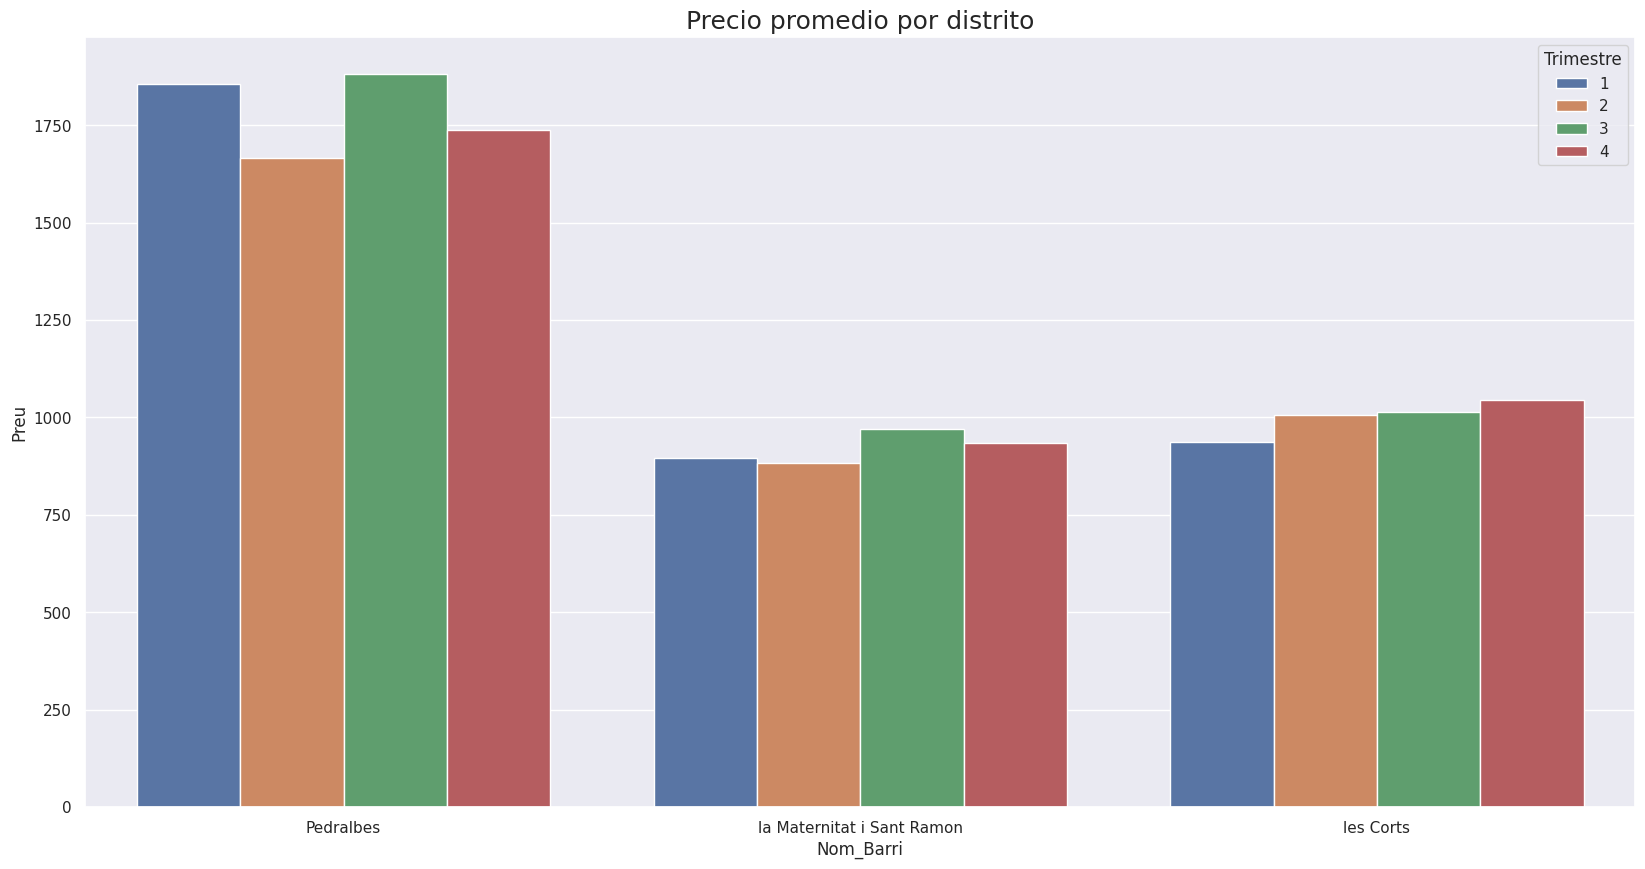

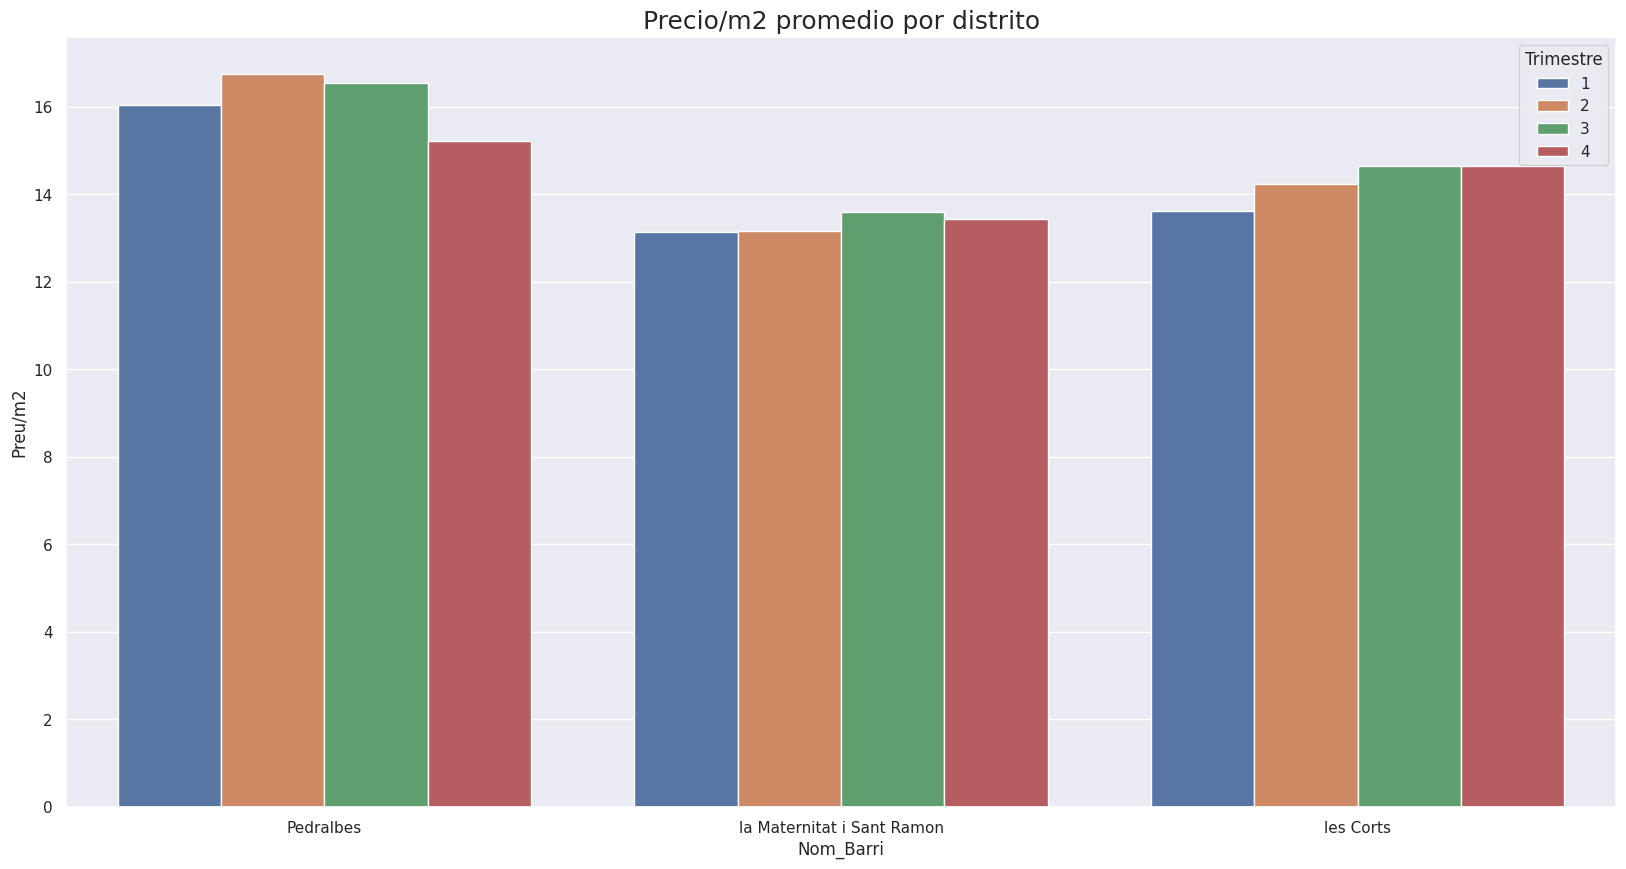

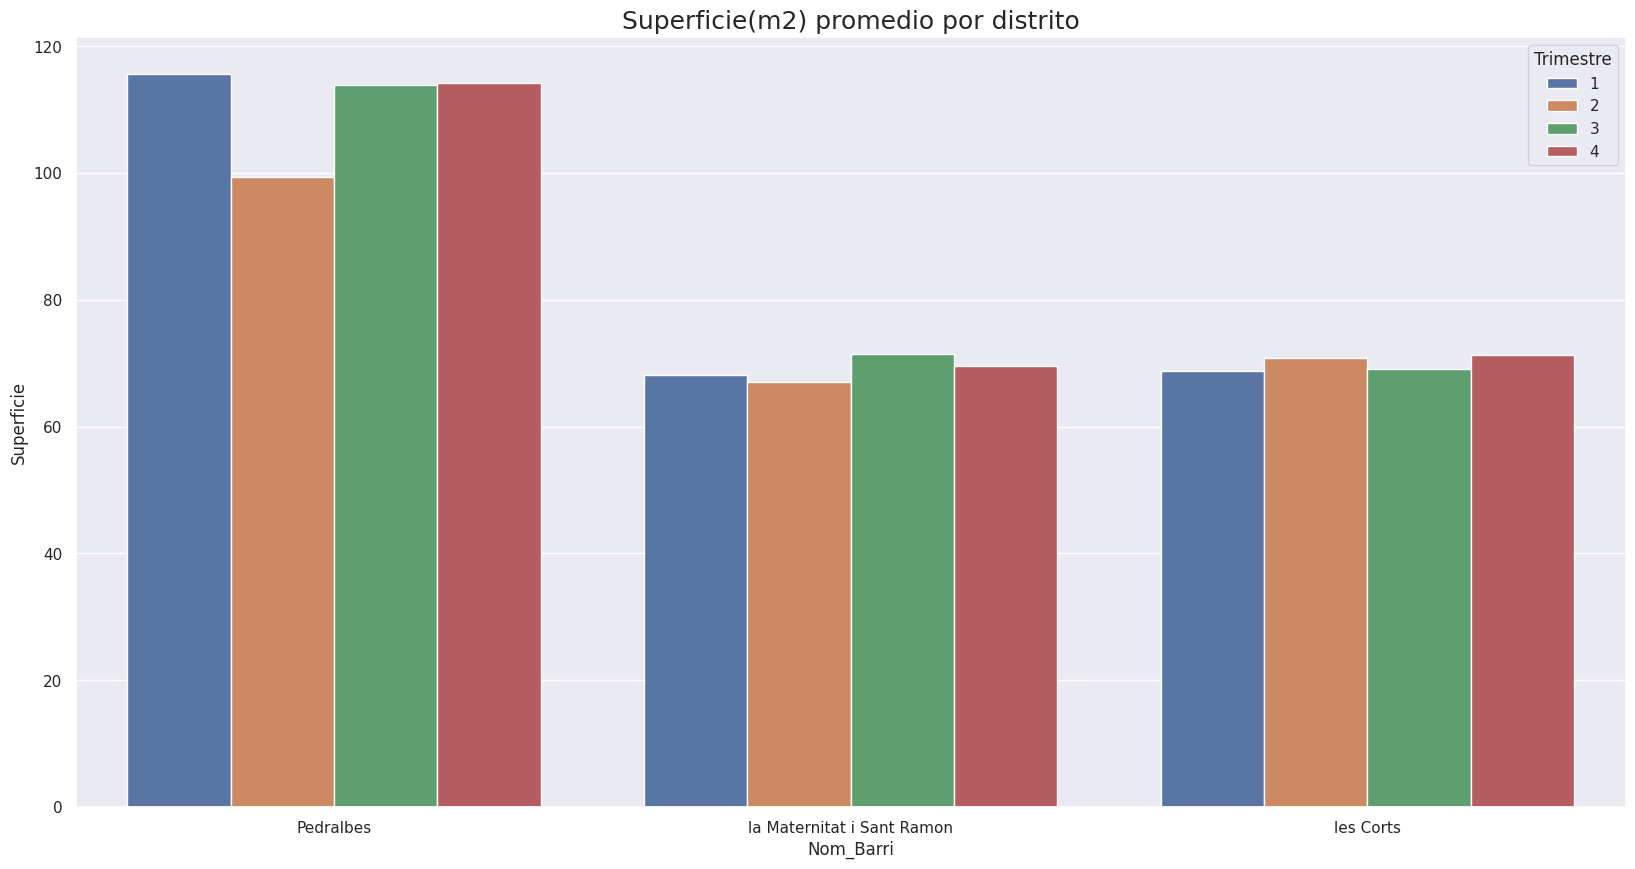

In [34]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Les Corts']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

El barrio más caro en terminos generales (1750€) y por metro cuadrado (16€/m2), así como con viviendas más grandes (110m2), es Pedralbes. Por otra parte, la Maternitat i Sant Ramon es ligeramente más barato que les Cortes (tanto en precio total, 900€, como por metro cuadrado, 13€/m2), si bien el tamaño de sus viviendas es comparable a les Corts (65m2).

### Evolución de los precios y superficies en Nou Barris

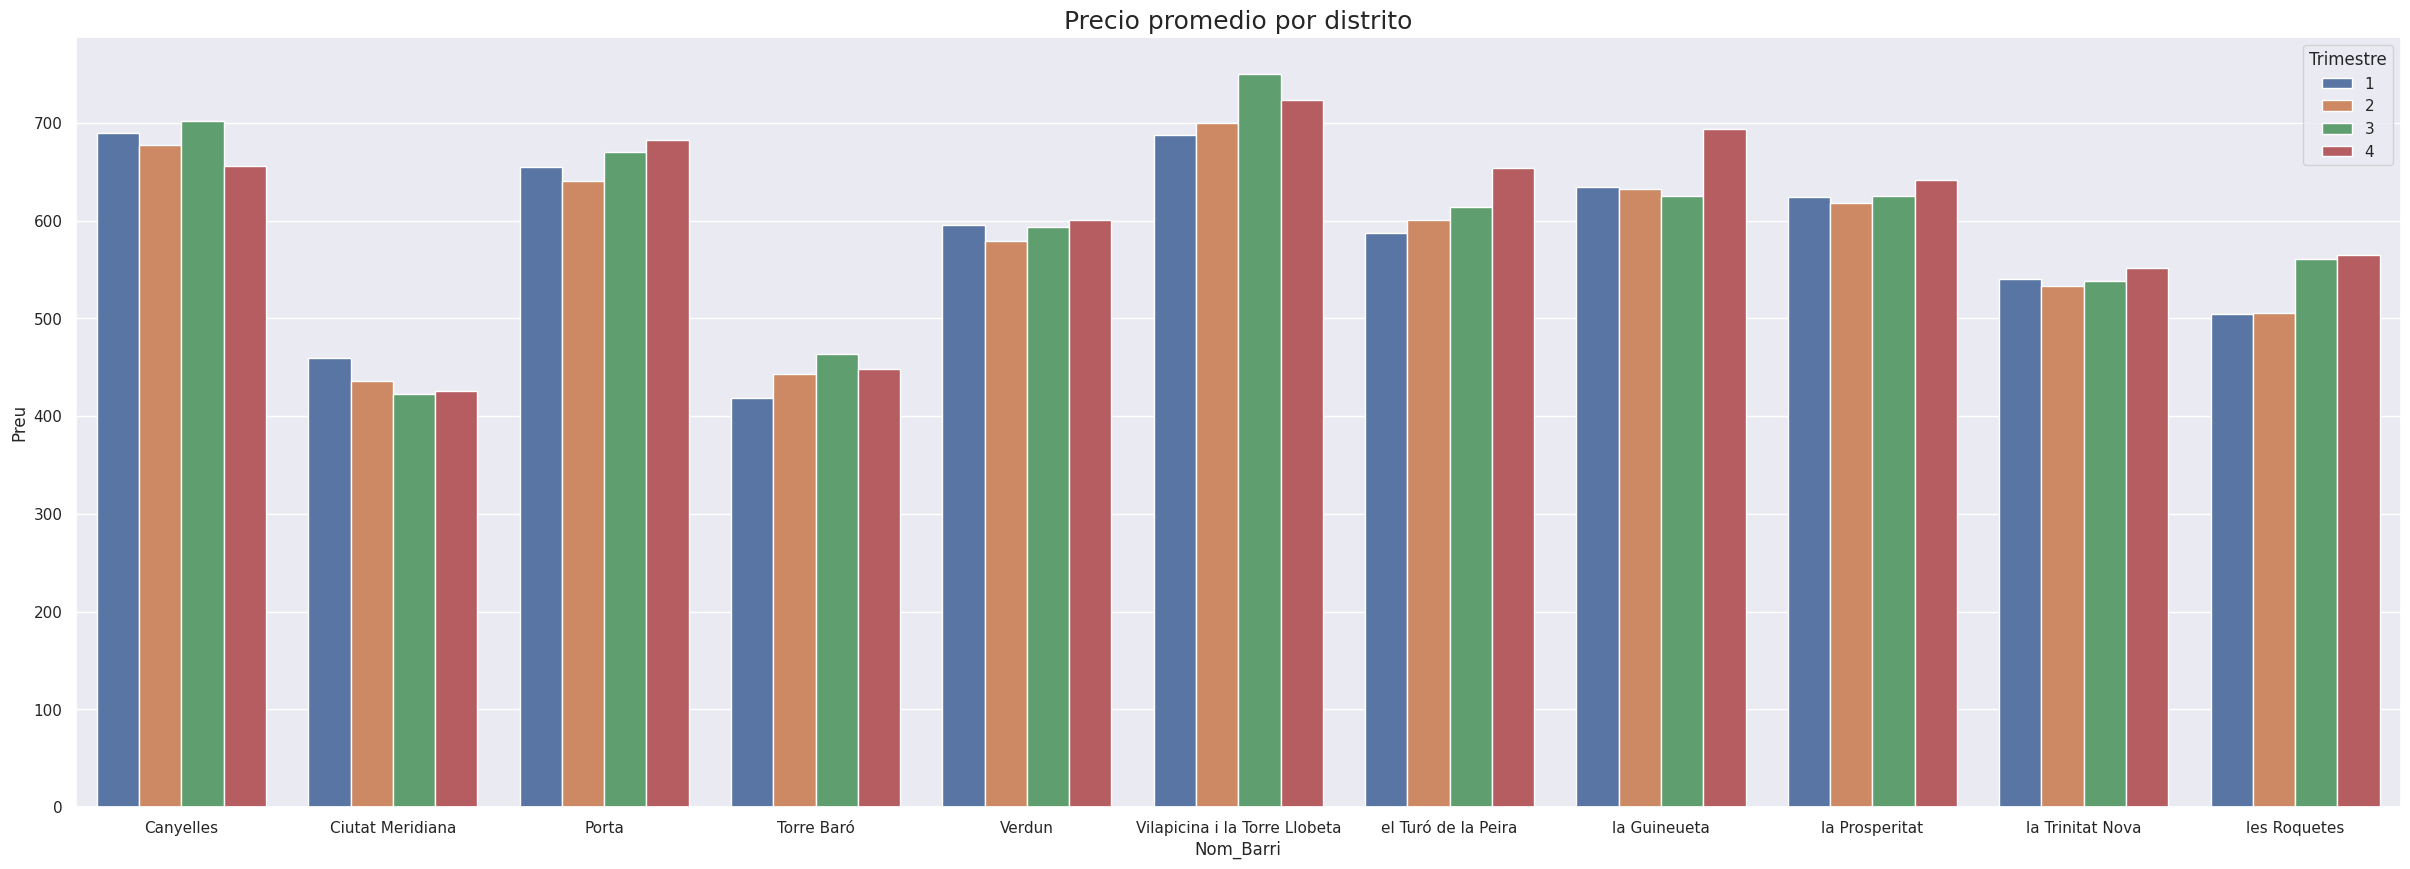

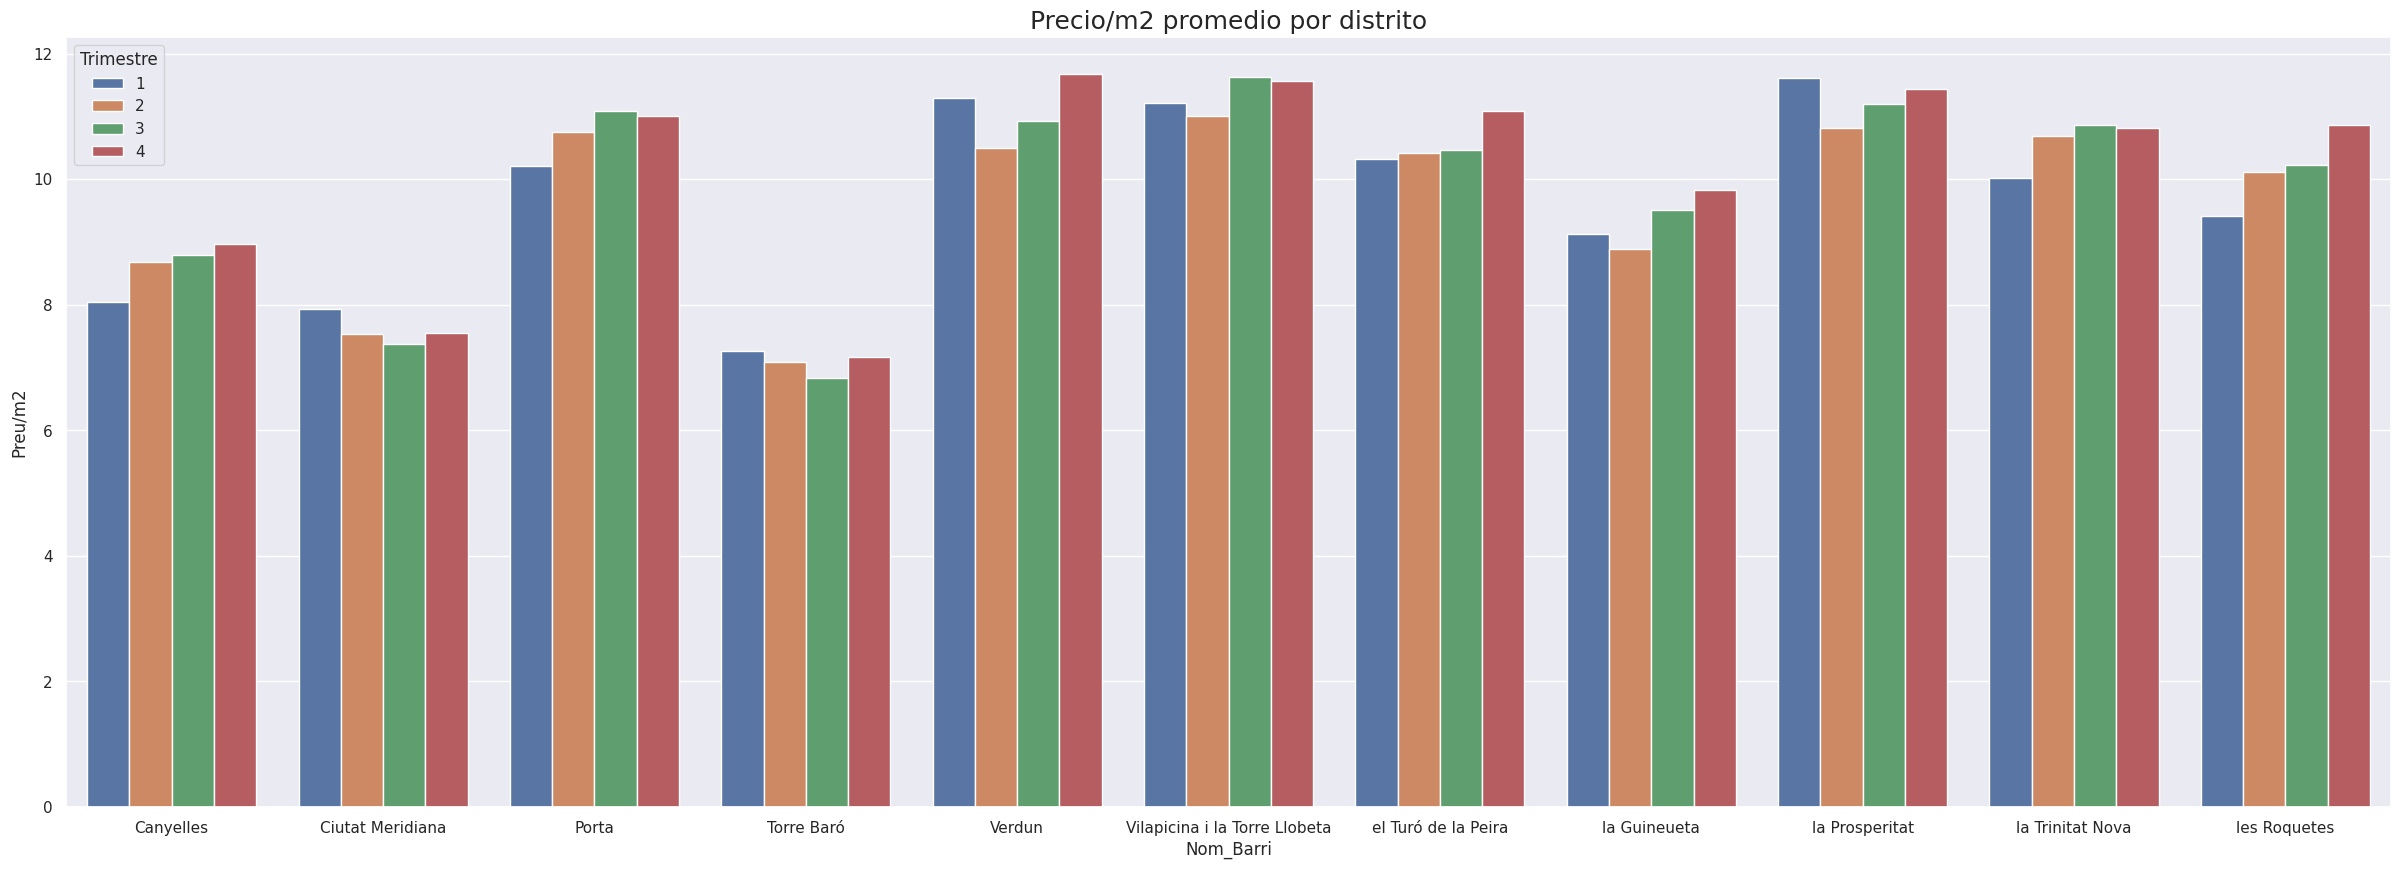

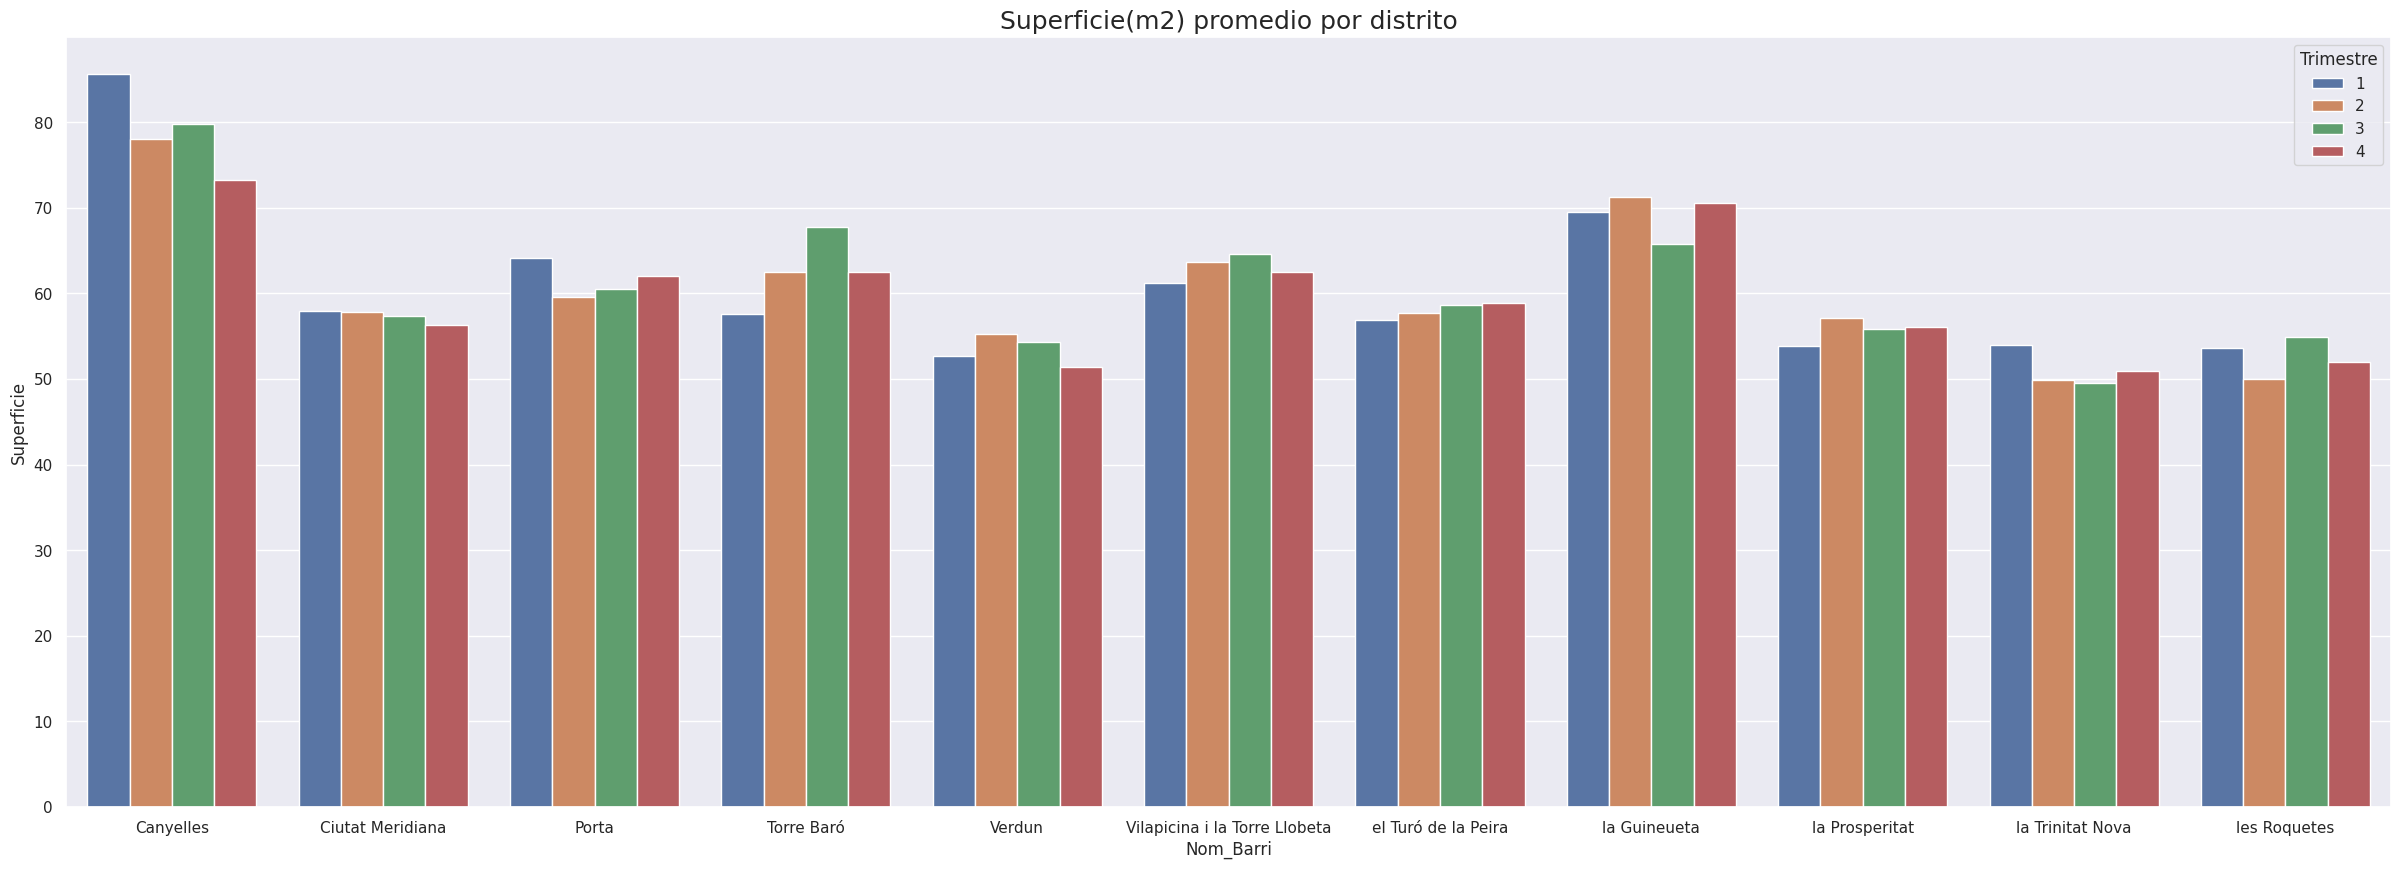

In [35]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Nou Barris']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(30,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(30,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(30,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

El barrio más caro a nivel general es Vilapicina i la Torre Llobeta (700€), aunque a nivel de precio por metro cuadrado, este barrio se equipara a los de Verdun y la Prosperitat (11€/m2). Por otra parte, los barrios más baratos, tanto a nivel general (450€) como por metro cuadrado (7€/m2), son Ciutat Meridiana y Torre Baró. Las viviendas más grandes se encuentran en Canyelles (80m2) y las más pequeñas en La Trinitat Nova (50m2).

### Evolución de los precios y superficies en Sant Andreu

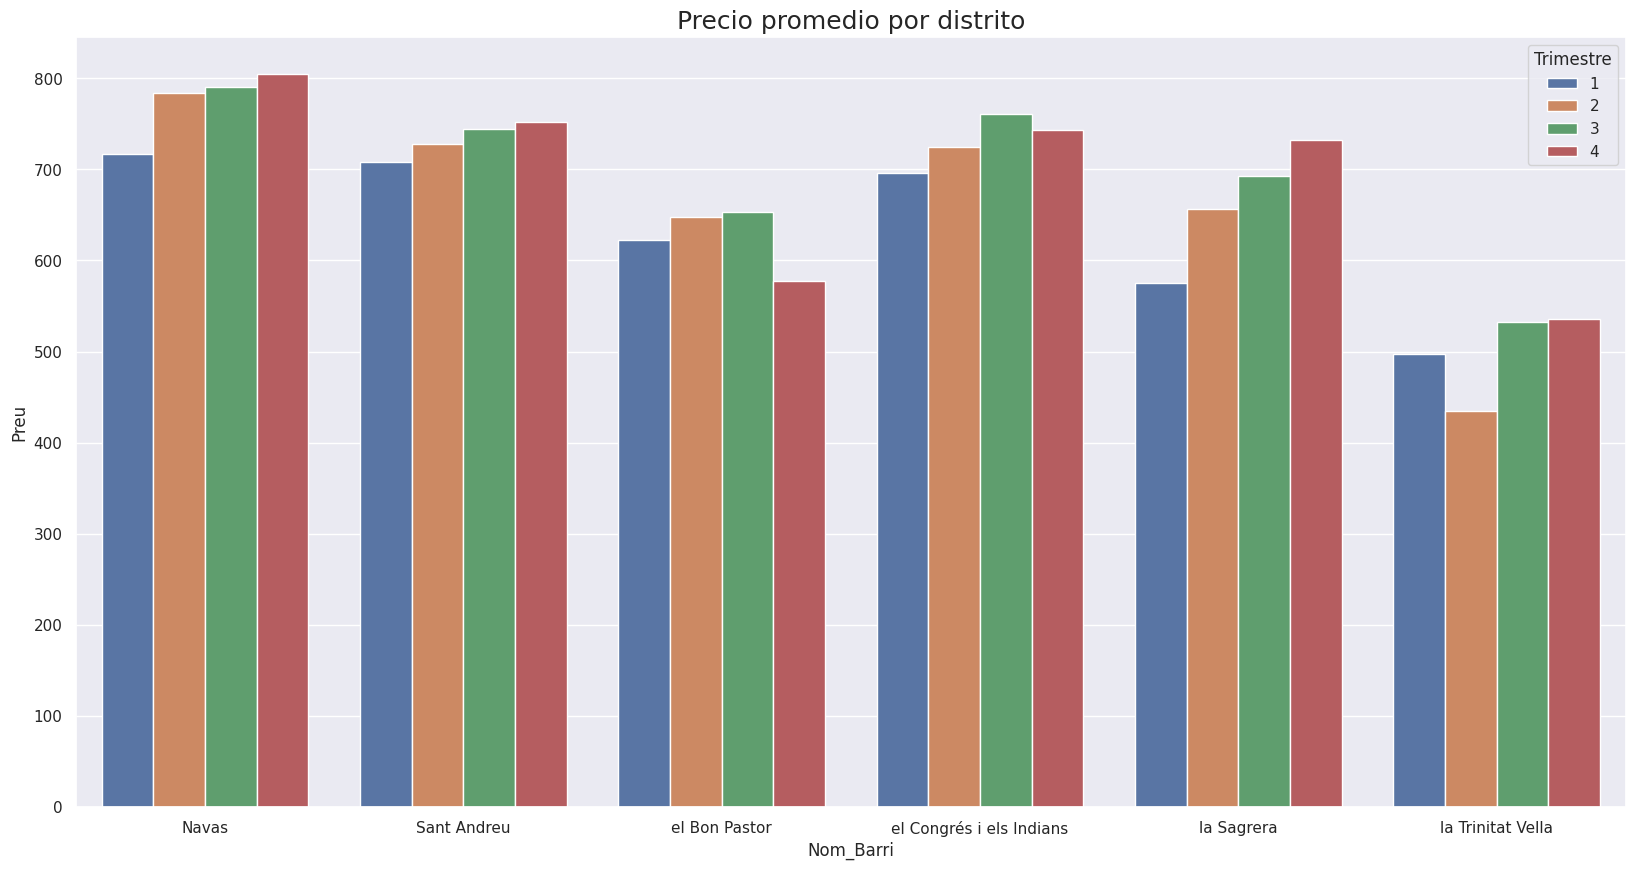

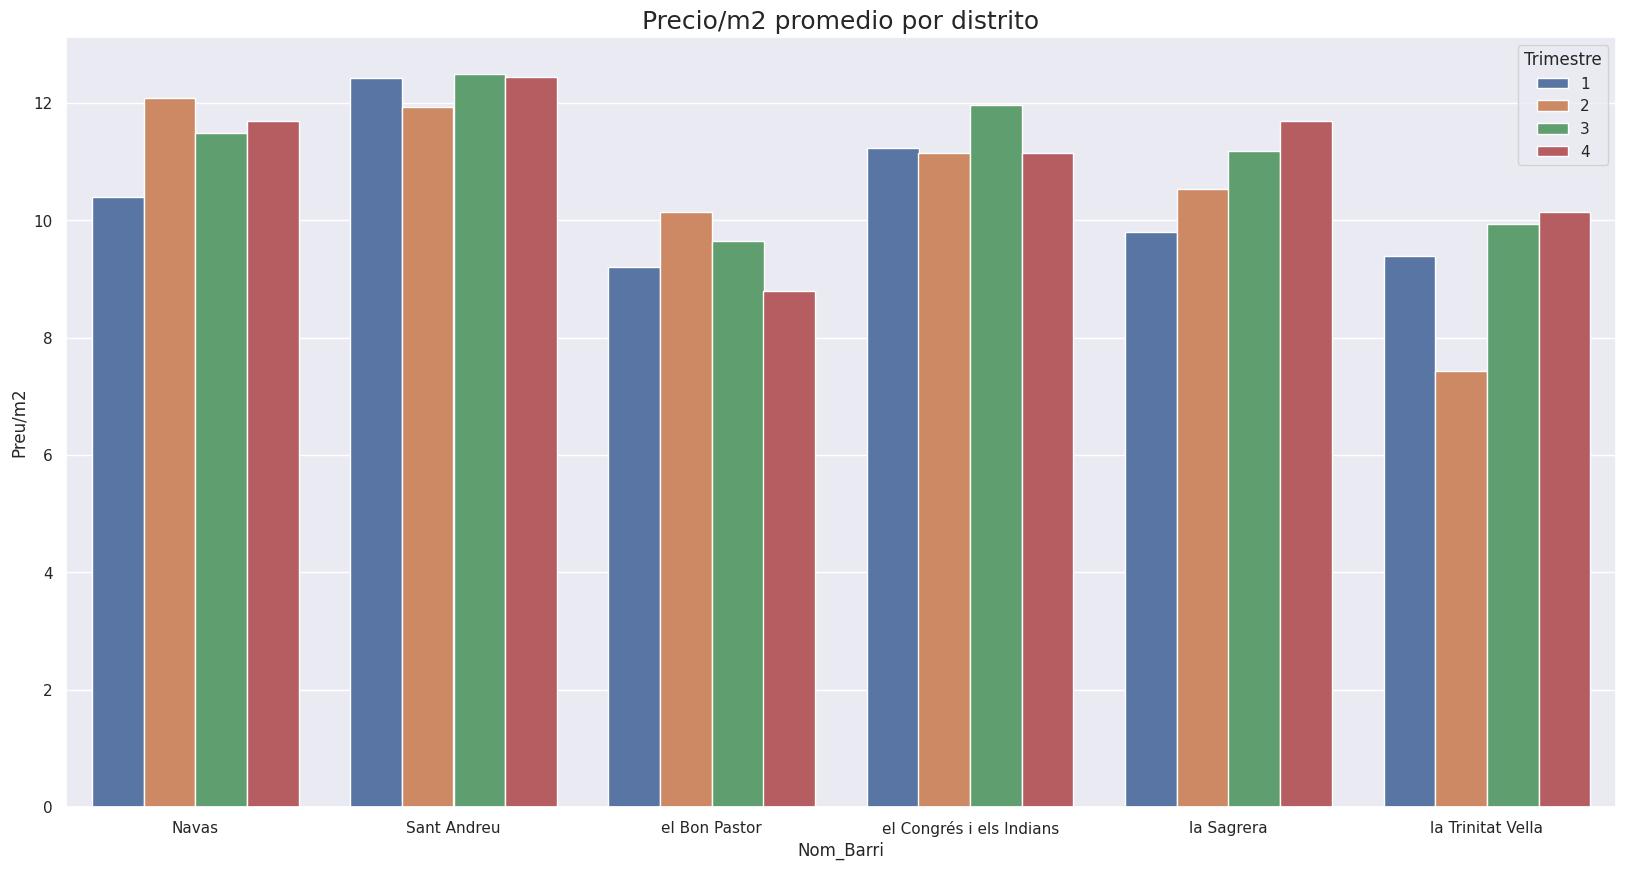

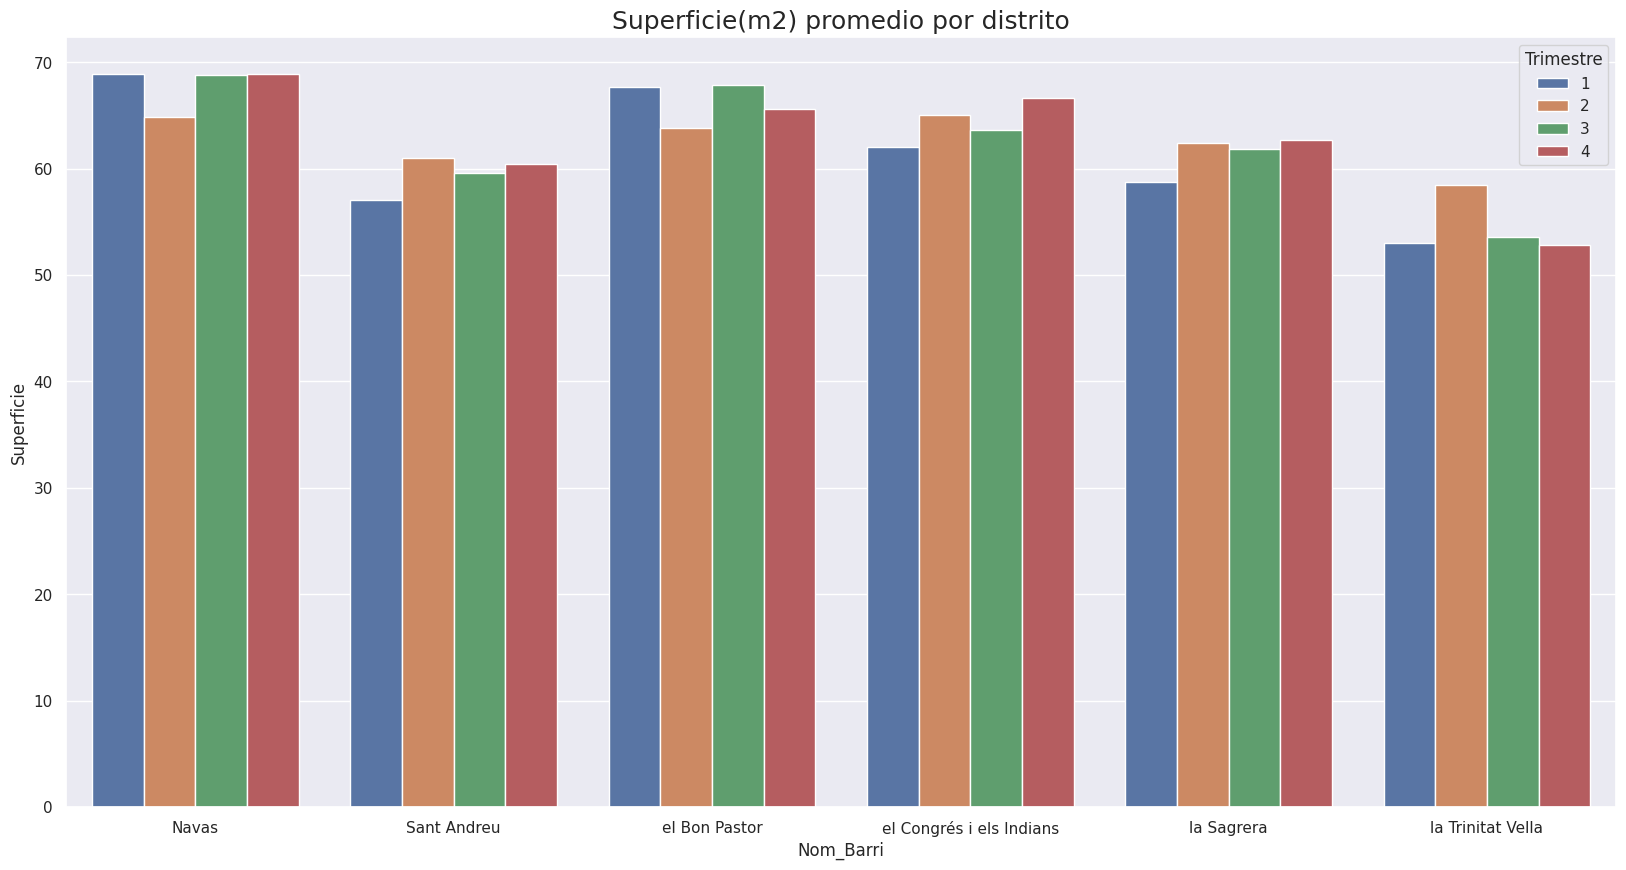

In [36]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Sant Andreu']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

El barrio más caro en Sant Andreu en terminos generales es Navas (750€), mientras que por metro cuadrado es Sant Andreu (12€/m2). Sin embargo, el barrio más barato en terminos generales es la Trinitat Vella (500€), la cual también es la más barata por metro cuadrado junto a el Bon Pastor (9€/m2). Las viviendas más grandes se encuentran en Navas (>65m2) y las más pequeñas en la Trinitat Vella (<55m2).

### Evolución de los precios y superficies en Sant Martí

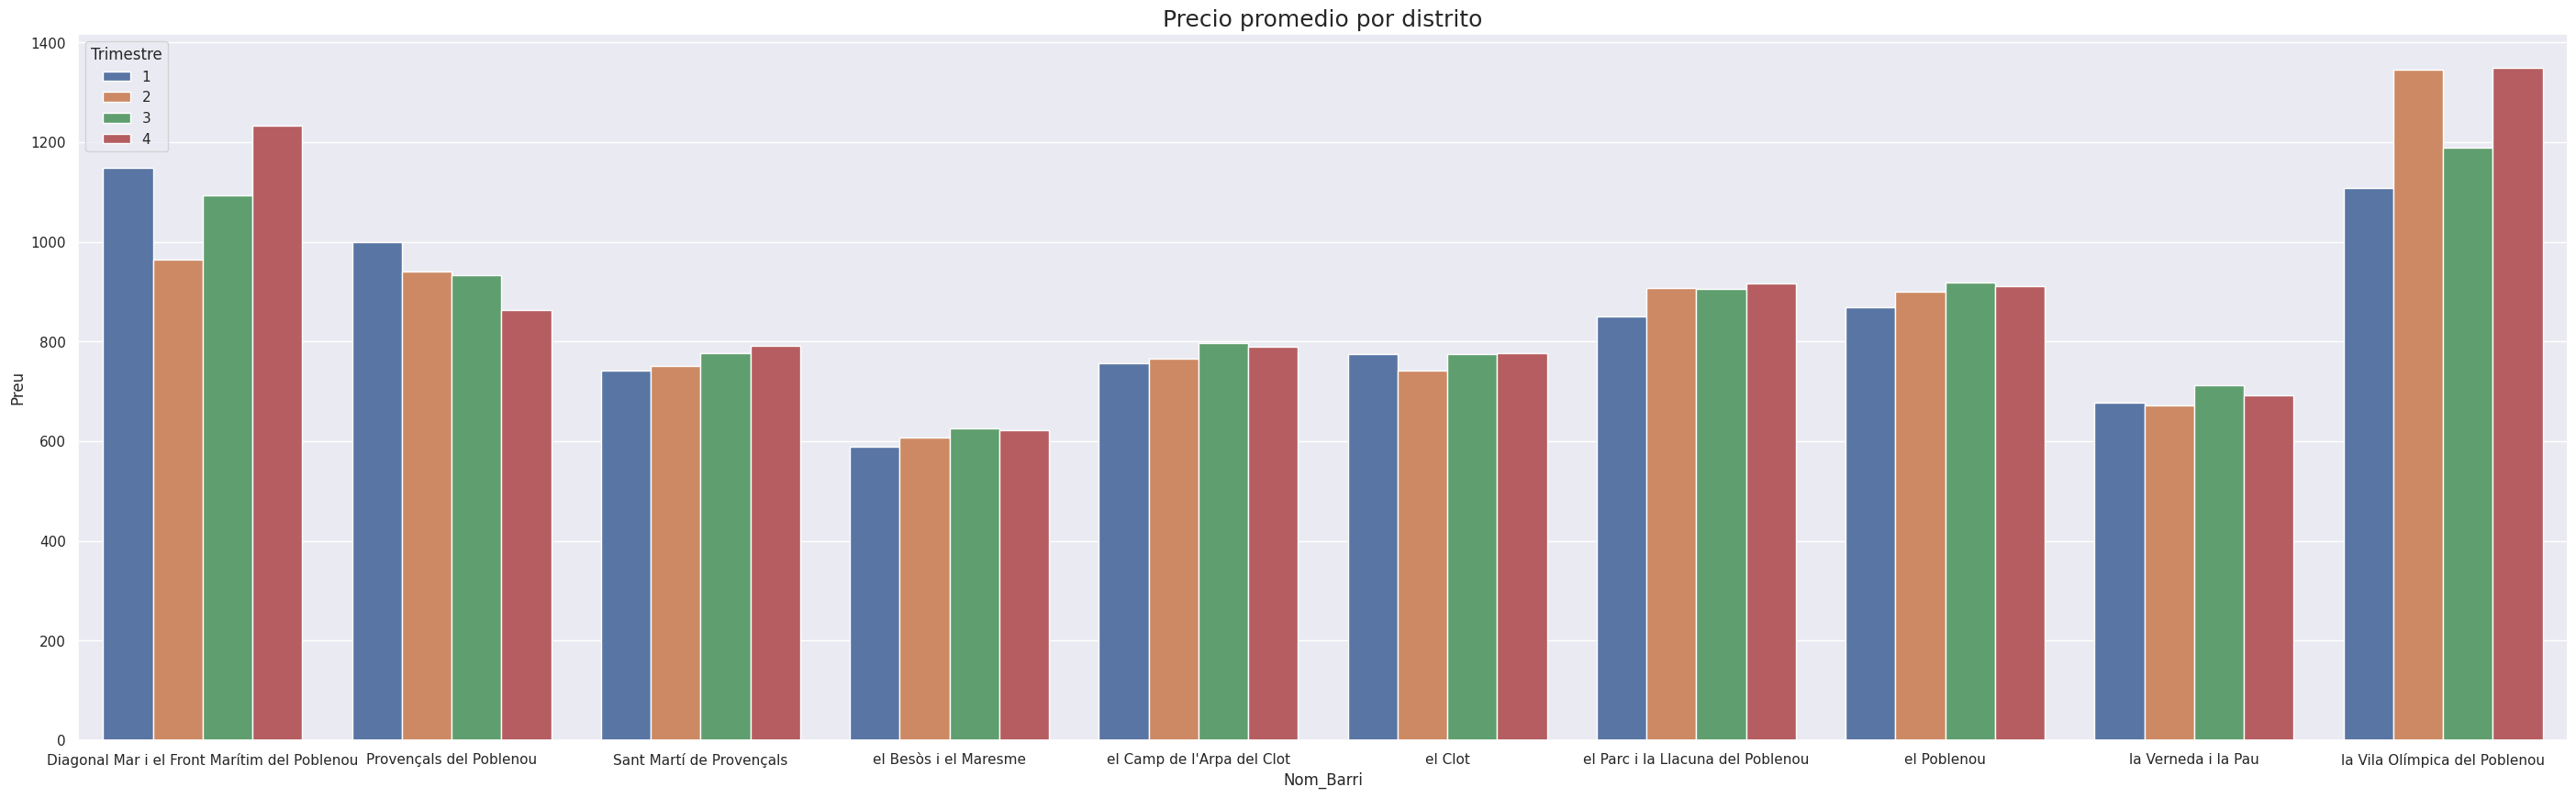

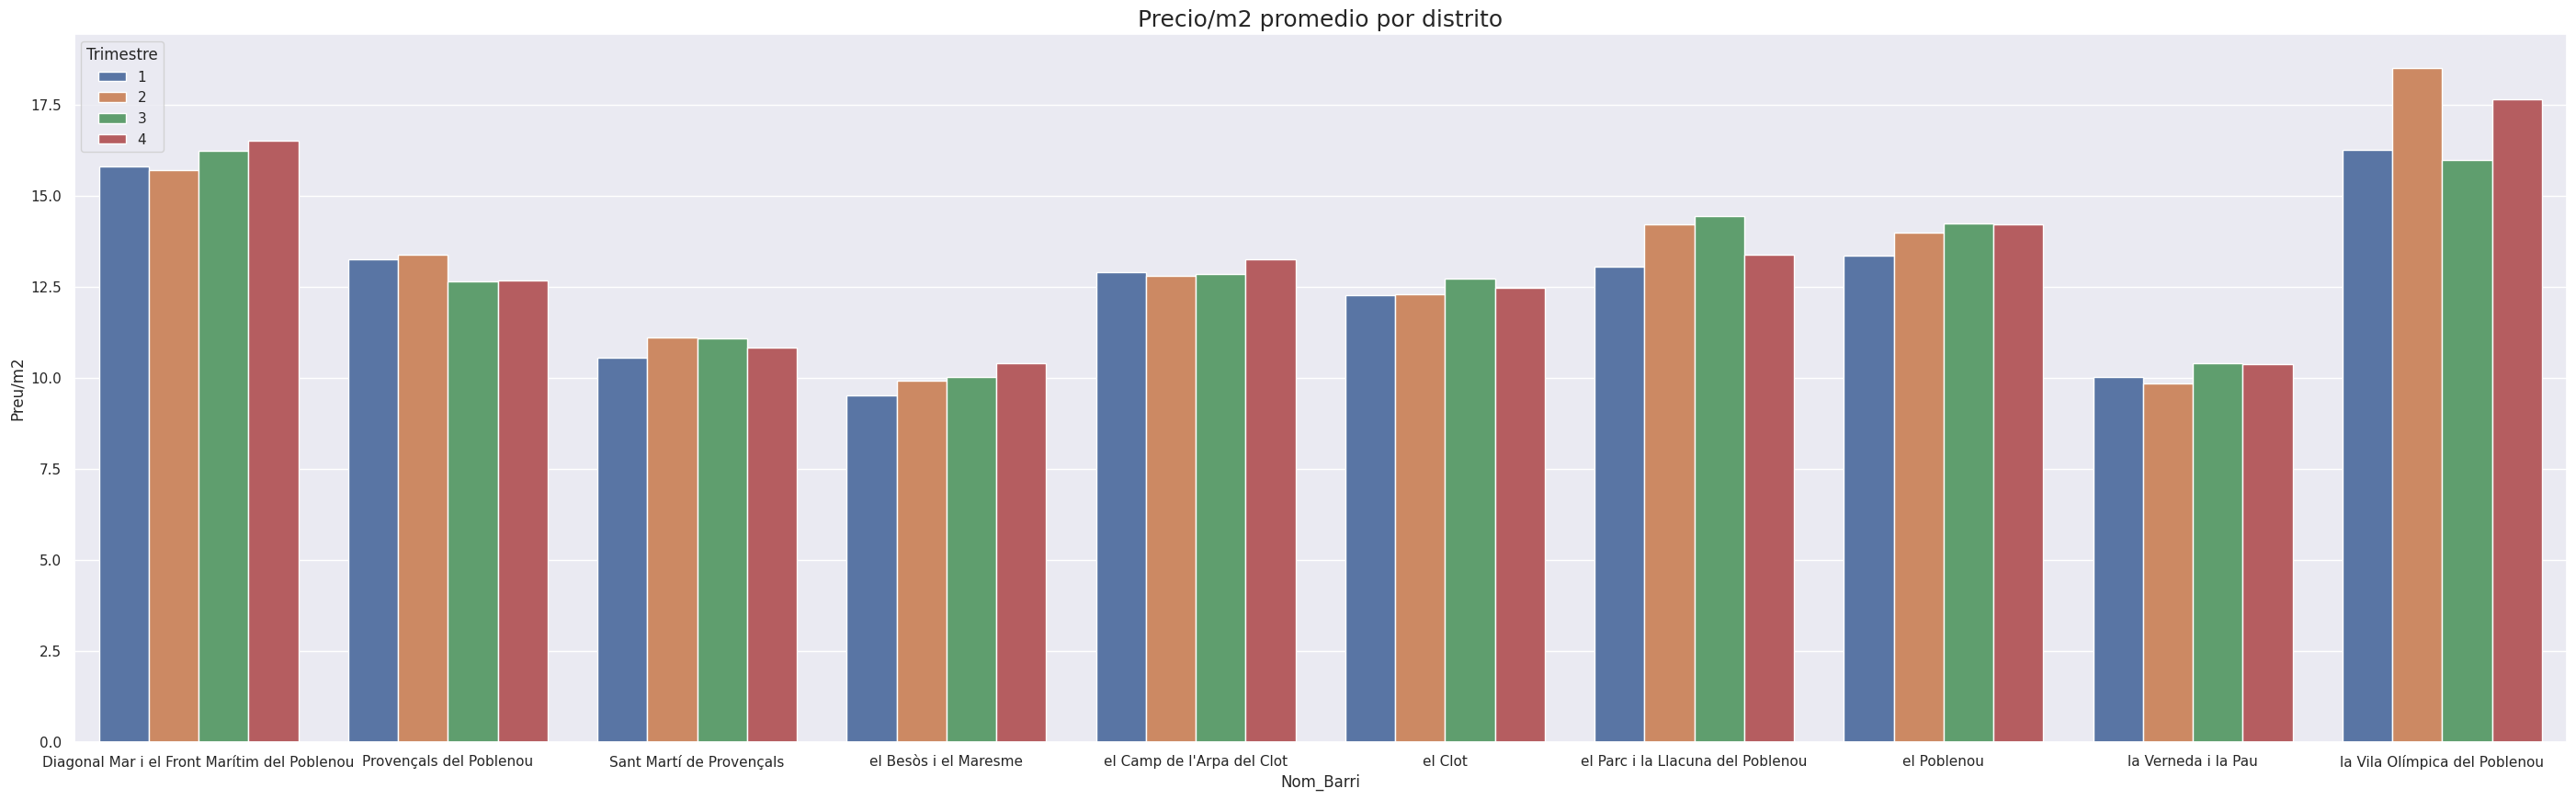

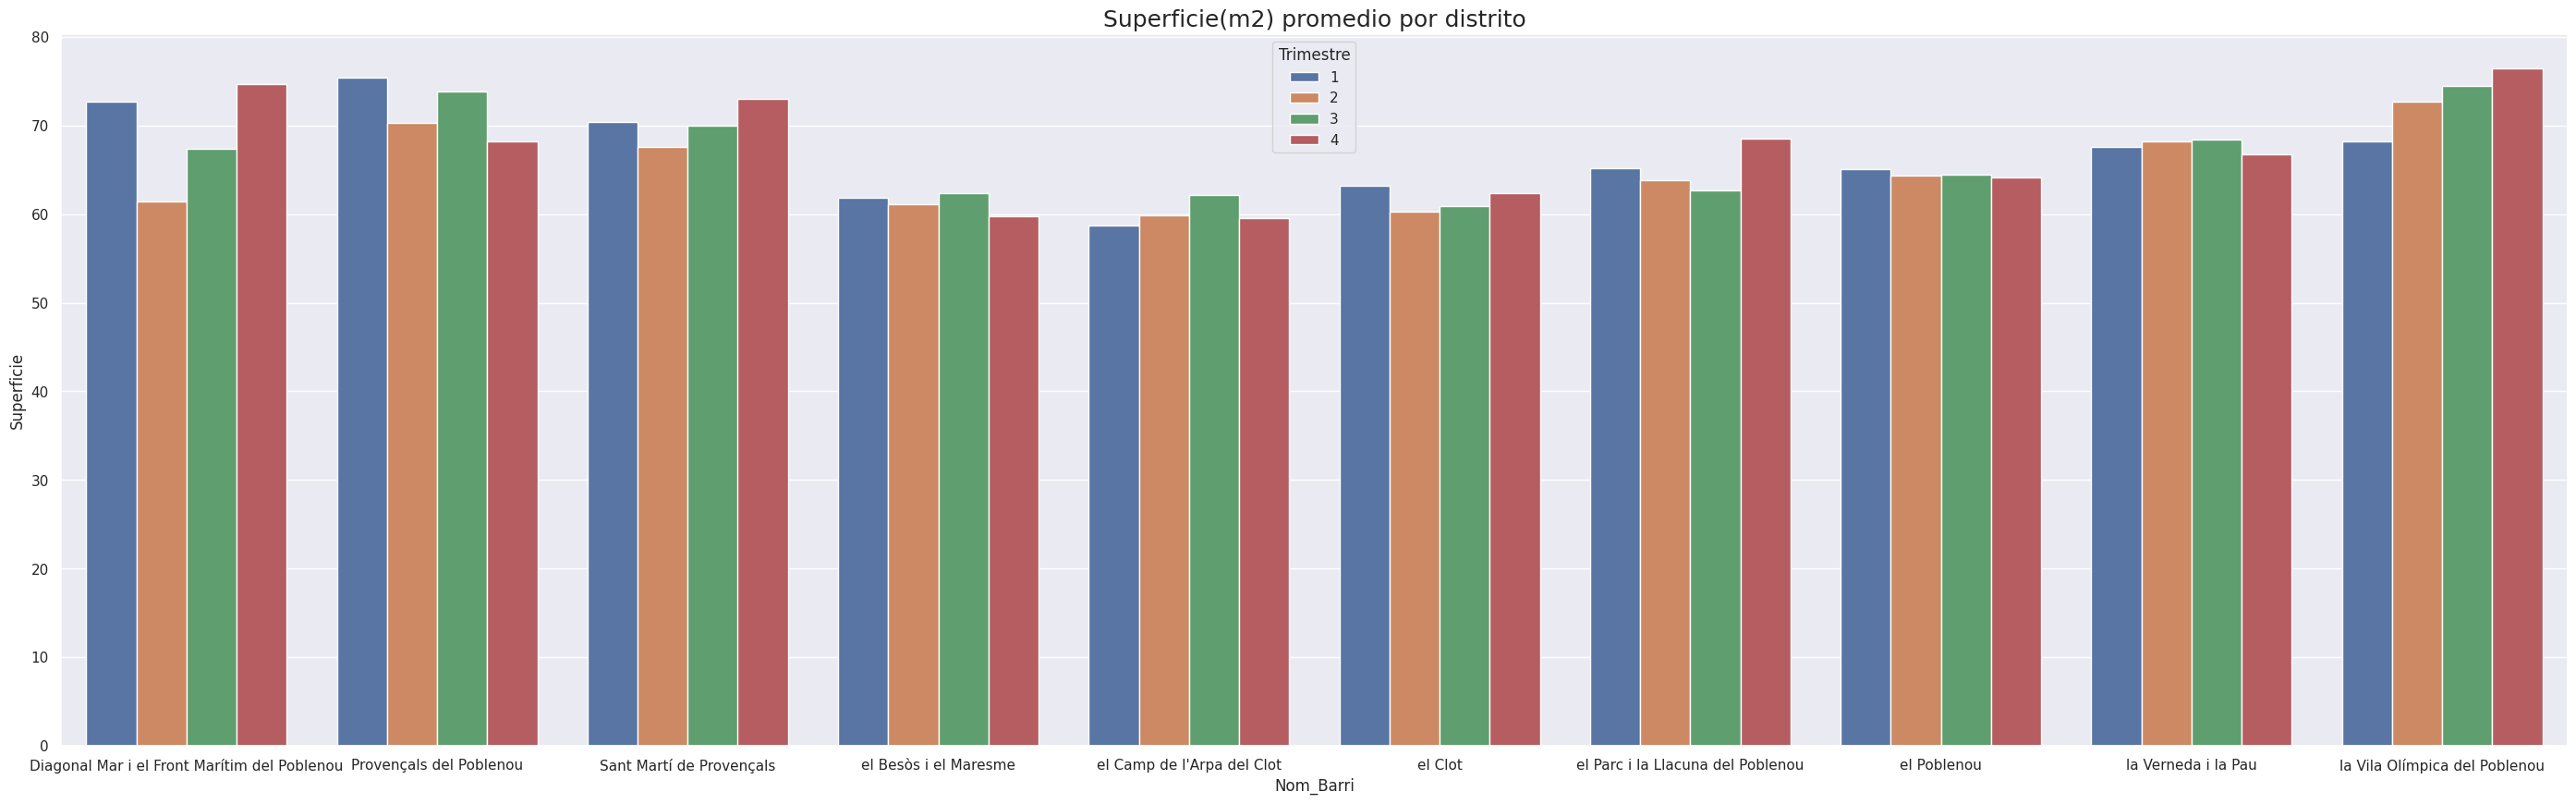

In [37]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Sant Martí']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(35,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(35,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(35,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

En el distrito de Sant Martí el barrio más caro en terminos generales (1200€) como por metro cuadrado (16€/m2) es la Vila Olímpica del Poblenou. Por su parte, el Besòs i el Maresme es el barrio más barato en termino generales (600€), aunque por metro cuadrado se equipara al de la Verneda i la Pau (10€/m2). En cuanto a superficie, las viviendas más grandes se encuentran en la Vila Olímpica del Poblenou (75m2) y las más pequeñas en el Besòs i el Maresme, así como en el Camp de l'Arpa del Clot (60m2).

### Evolución de los precios y superficies en Sants-Montjuïc

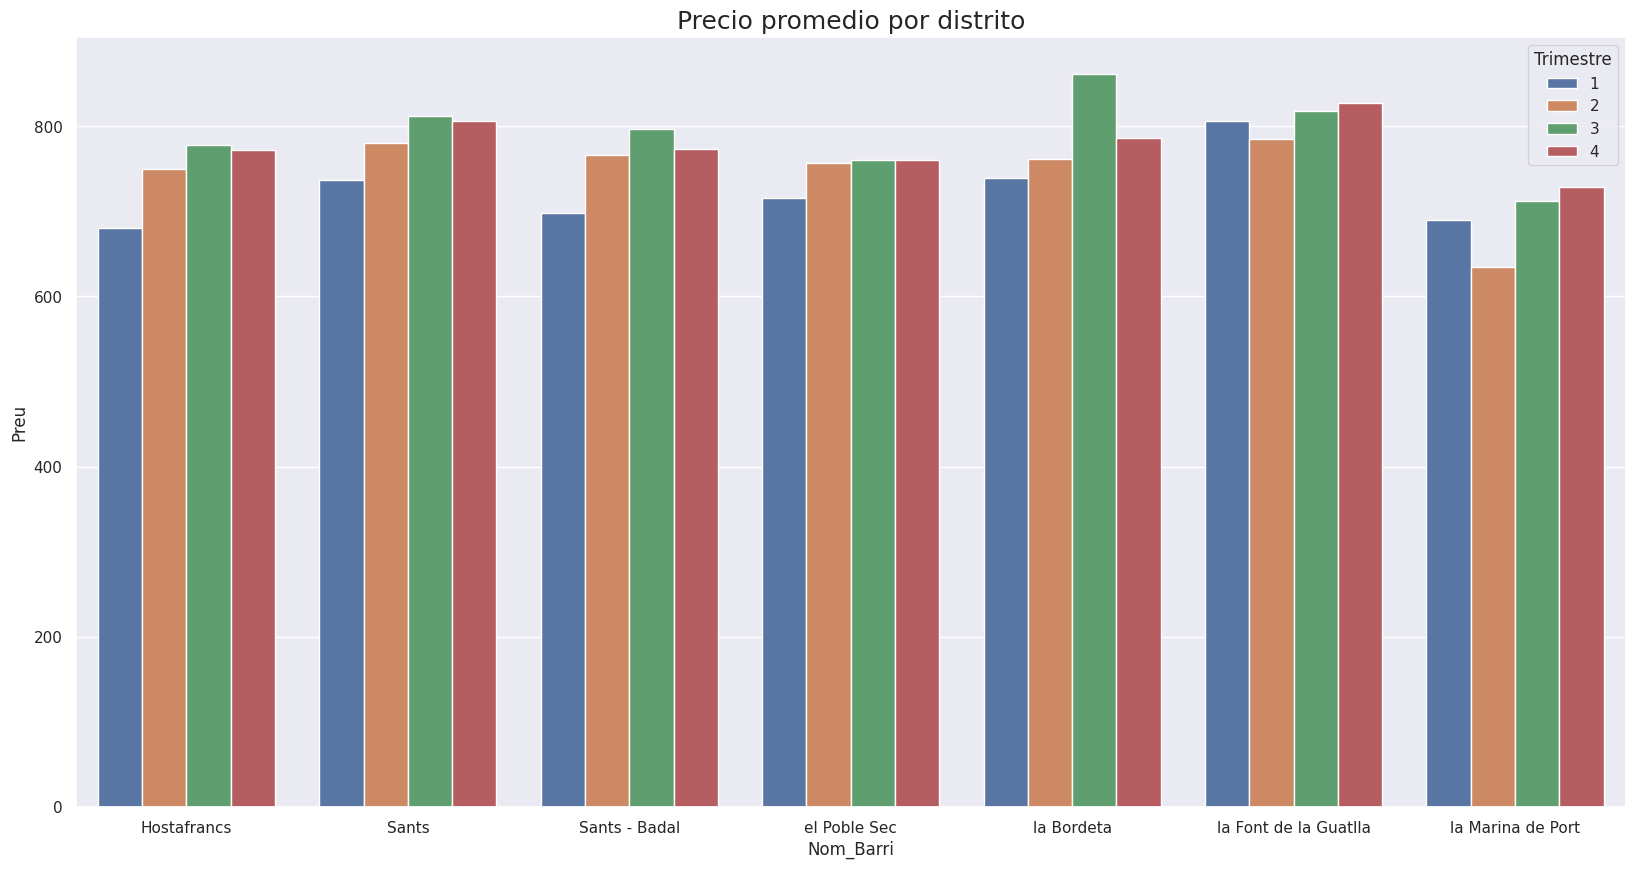

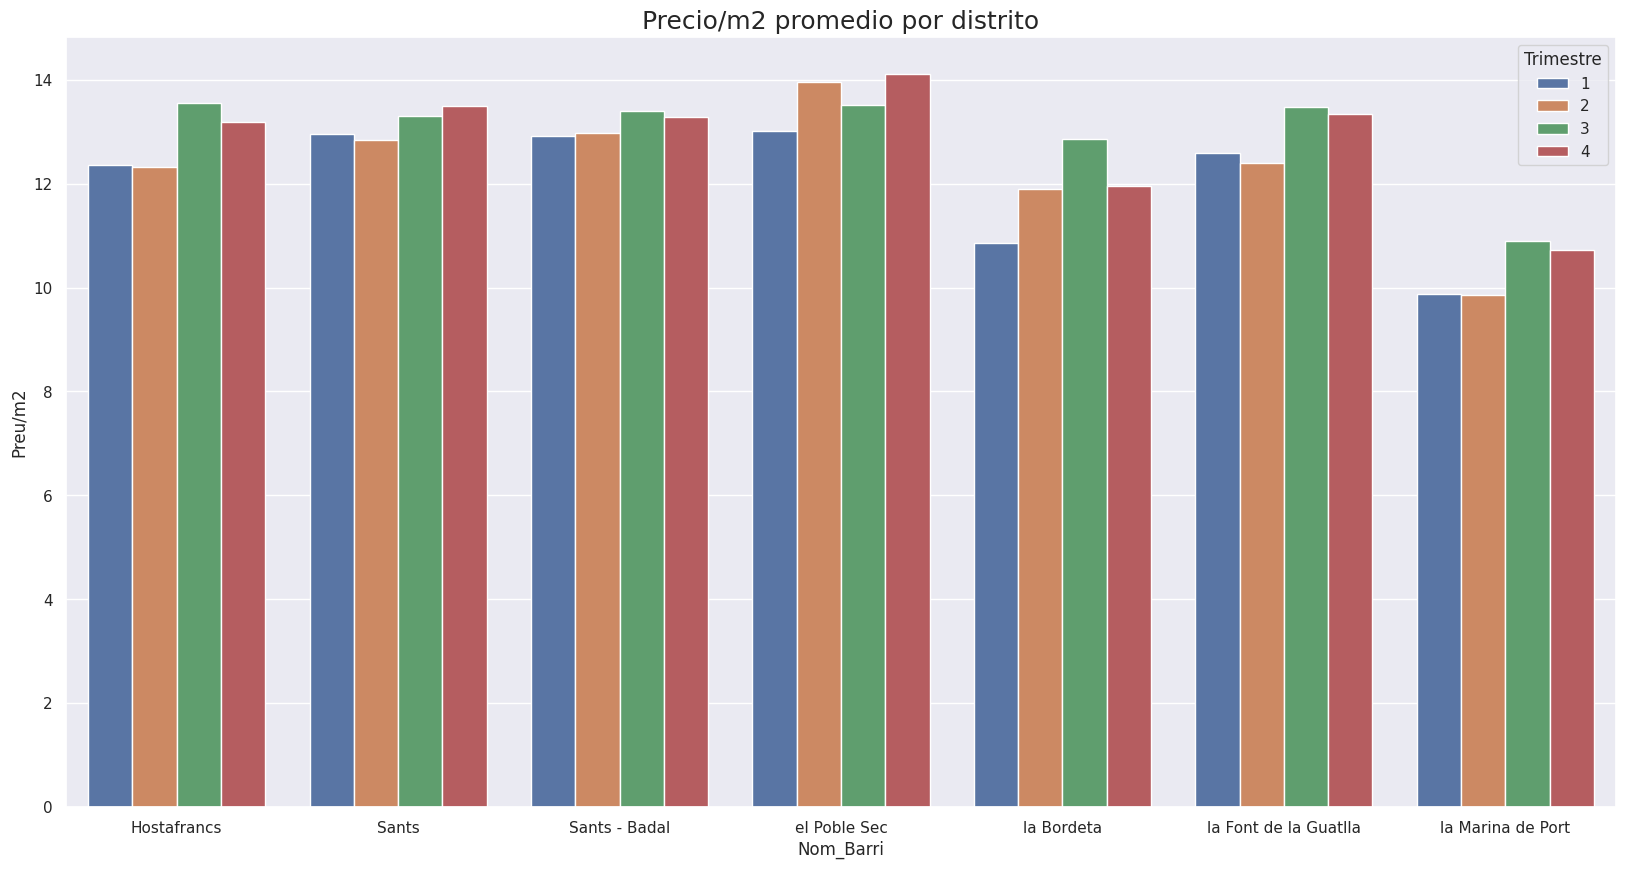

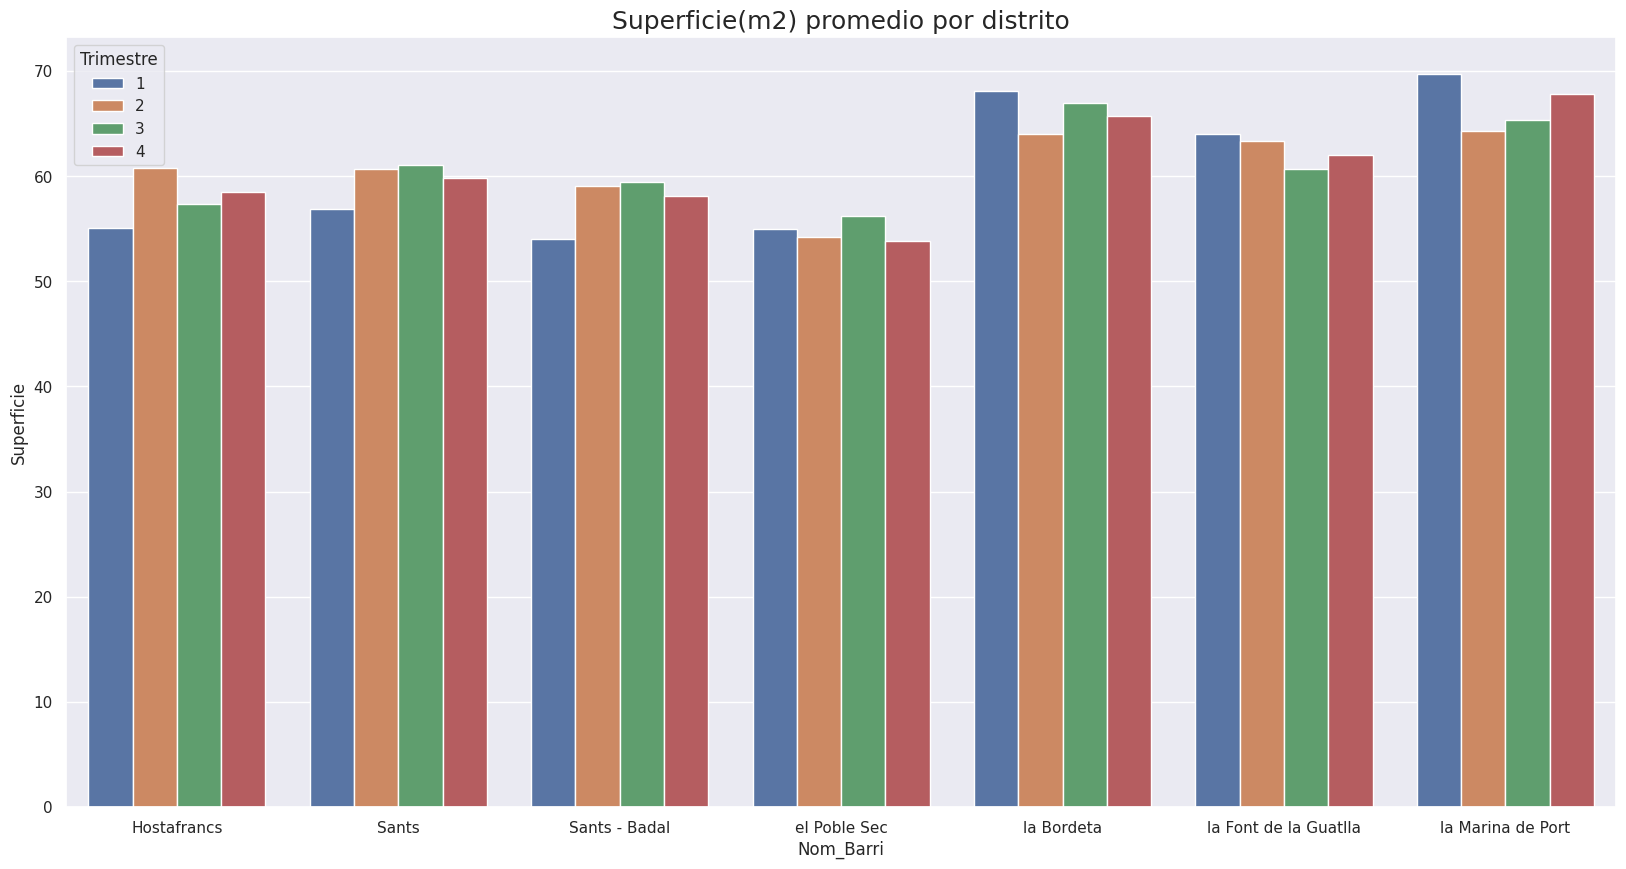

In [38]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Sants-Montjuïc']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

En Sants-Montjuïc el barrio más caro en términos generales es la Font de la Guatlla (800€) y por metro cuadrado el Poble Sec (>13€/m2). El barrio más barato, tanto en términos como por metro cuadrado, es la Marina de Port (<650€,<11€/m2).

### Evolución de los precios y superficies en Sarrià-Sant Gervasi

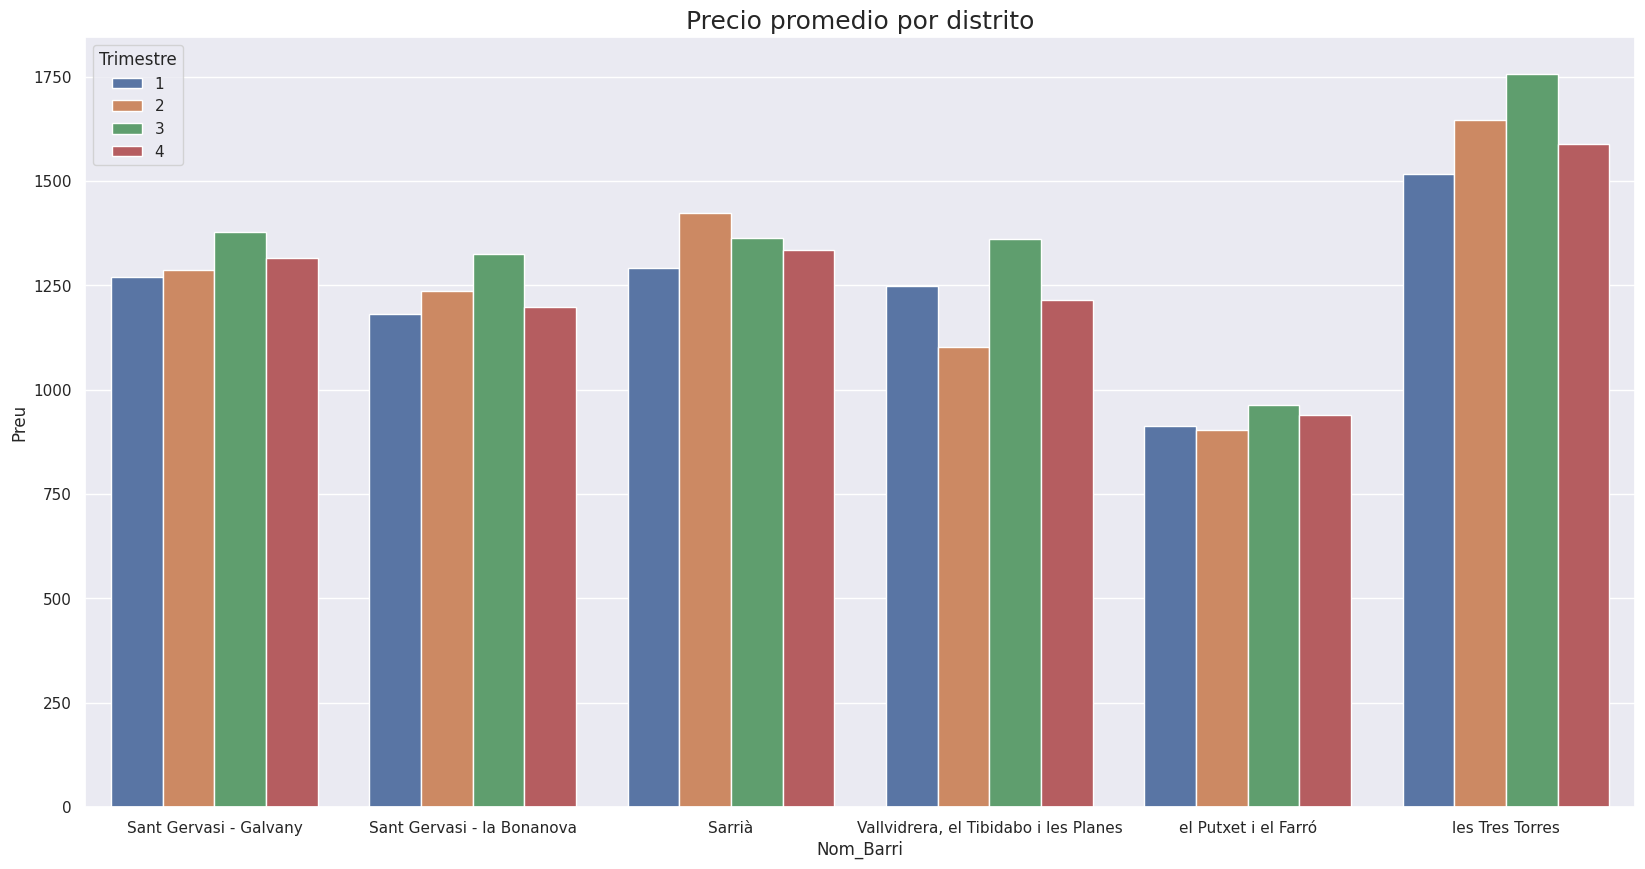

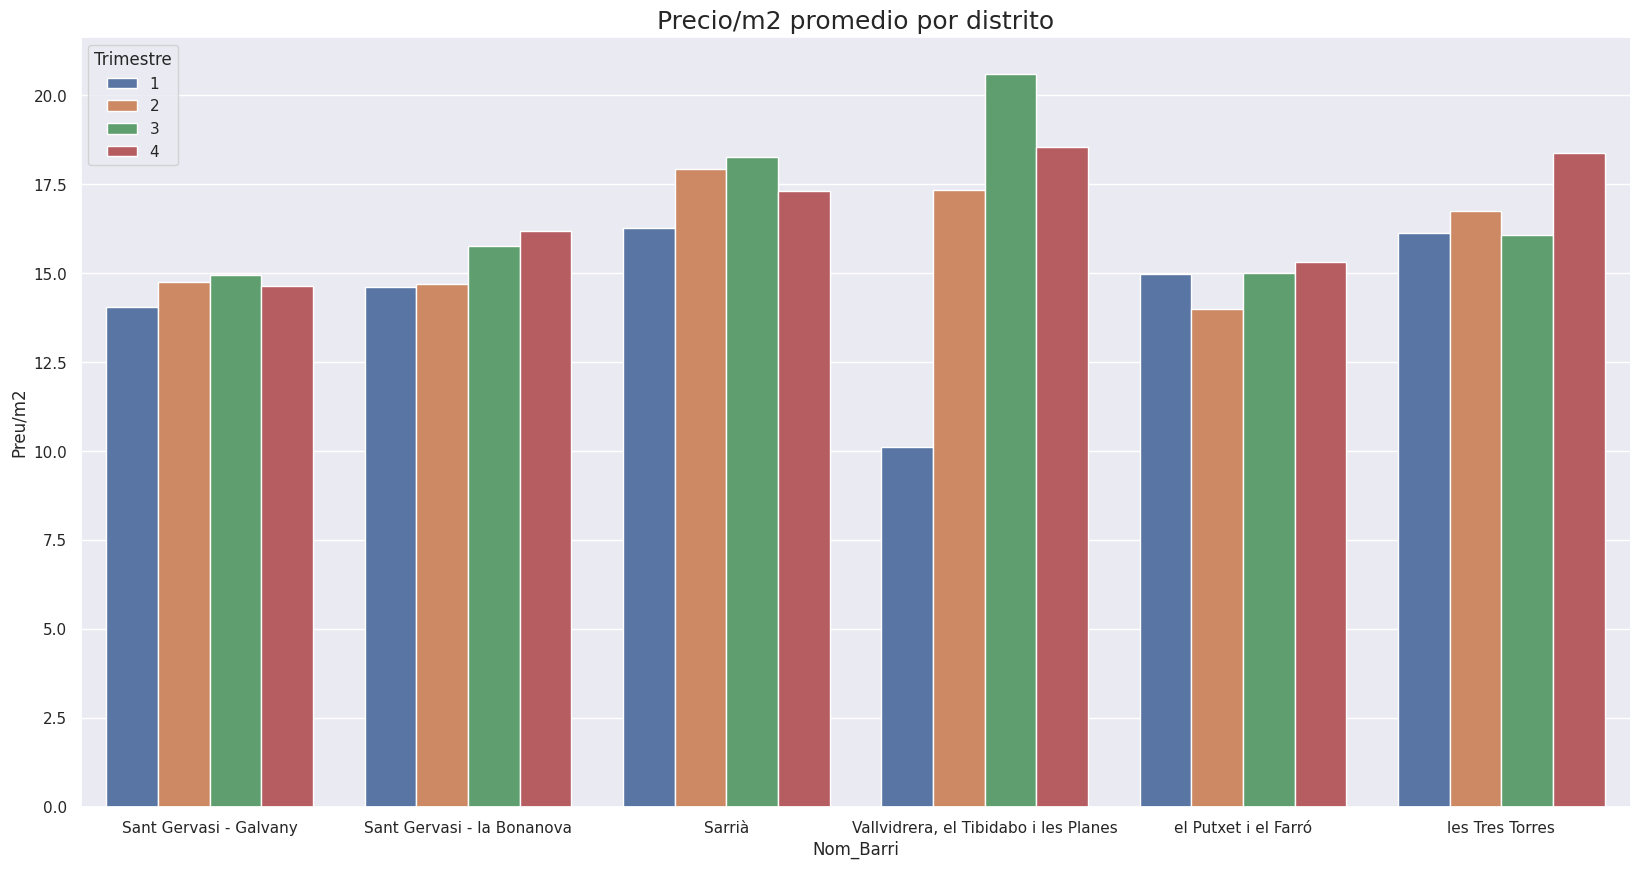

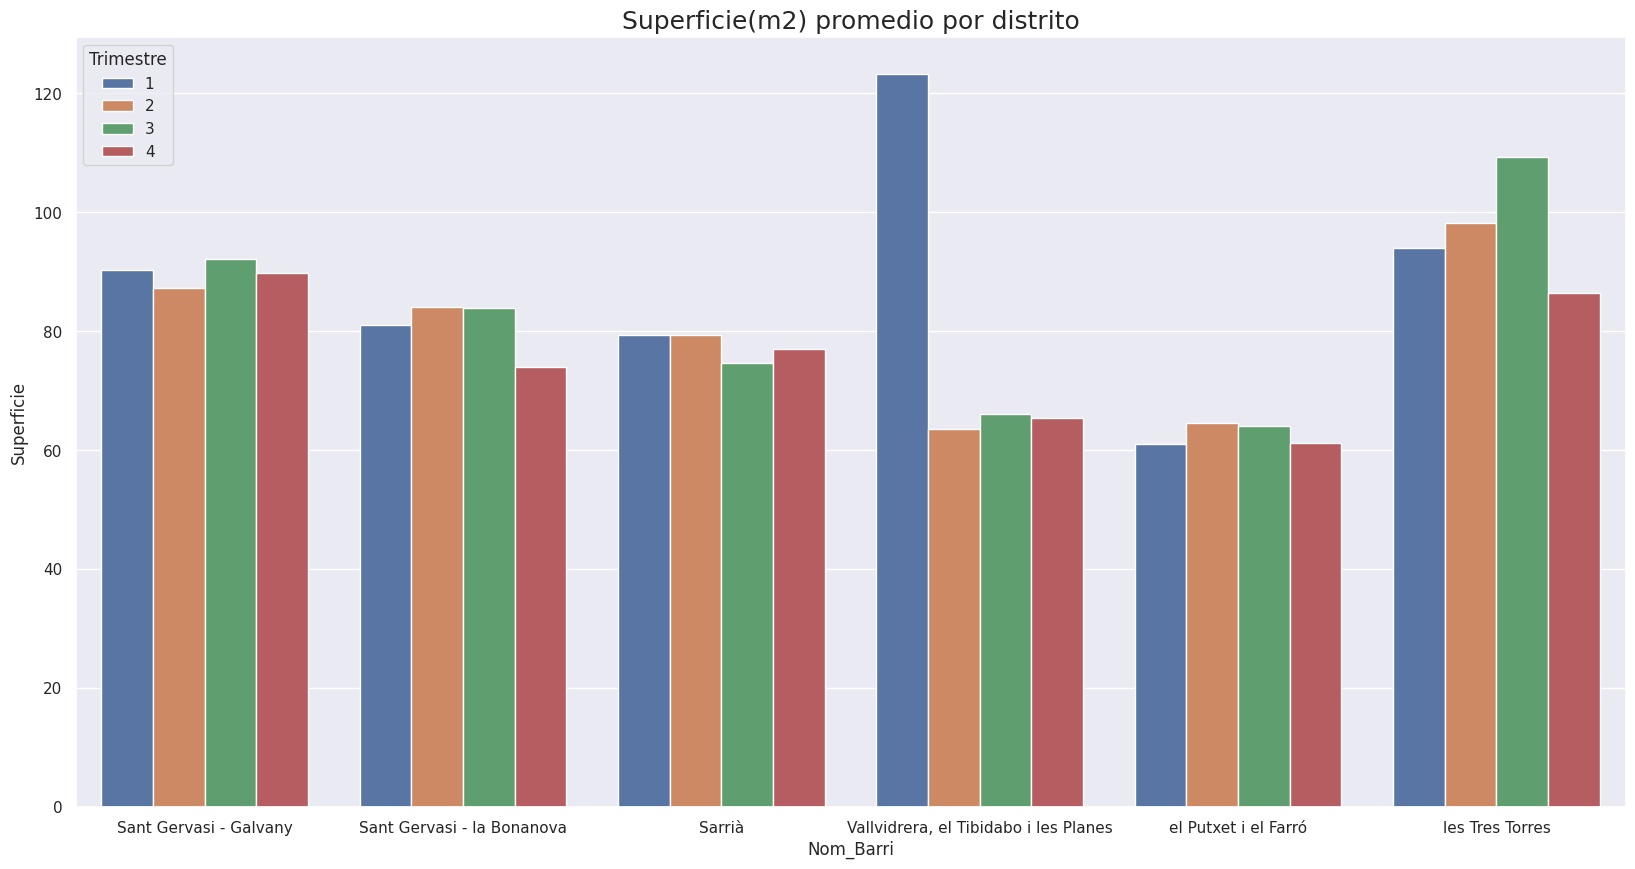

In [39]:
df_districte=new_df_alquiler.loc[new_df_alquiler['Nom_Districte']=='Sarrià-Sant Gervasi']

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu',hue='Trimestre',data= df_grouped).set_title('Precio promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Preu/m2':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Preu/m2',hue='Trimestre',data= df_grouped).set_title('Precio/m2 promedio por distrito',fontsize=18)
plt.show()

df_grouped = df_districte.groupby(['Nom_Barri','Trimestre']).agg({'Superficie':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(20,10)})
sns.barplot(x='Nom_Barri',y='Superficie',hue='Trimestre',data= df_grouped).set_title('Superficie(m2) promedio por distrito',fontsize=18)
plt.show()

Finalmente, en el distrito de Sarrià-Sant Gervasi, los mayores alquileres están en les Tres Torres (1600€), mientras que por metro cuadrado vemos que Sarrià fue el barrio más caro los 2 primeros trimestres (17€/m2), pero Vallvidrera, el Tibidabo i les Planes los 2 últimos trimestres (19€/m2). De hecho con este último barrio vemos un compartamiento extremo, siendo el que barrio más barato por metro cuadrado (10€/m2) y con viviendas más grandes el primer trimestre (>120m2), para luego incrementar su valor de suelo y reducirse la superficie de sus viviendas hasta los valores más bajos. No obstante, en terminos generales, el barrio con las viviendas más grandes es les Tres Torres (100m2) y el barrio con las viviendas más pequeñas el Putxet i el Farró (60m2).

Una vez realizado el analisis exploratorio del dataset, procedemos a eliminar las columnas 'Nom_Districte' y 'Nom_Barri'

In [40]:
new_df_alquiler.drop(columns=['Nom_Districte','Nom_Barri'],inplace=True)
new_df_alquiler

/tmp/ipykernel_53/3515699806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df_alquiler.drop(columns=['Nom_Districte','Nom_Barri'],inplace=True)


Trimestre  Codi_Districte  Codi_Barri     Preu  Preu/m2  Superficie
0            1               1           1   734.99    13.50       54.44
1            1               1           2   905.26    14.14       64.02
2            1               1           3   722.78    19.46       37.14
3            1               1           4   895.28    15.01       59.65
4            1               2           5   871.08    12.77       68.21
..         ...             ...         ...      ...      ...         ...
267          4              10          69  1233.01    16.51       74.68
268          4              10          70   621.32    10.40       59.74
269          4              10          71   864.09    12.66       68.25
270          4              10          72   790.58    10.83       73.00
271          4              10          73   692.67    10.38       66.73

[272 rows x 6 columns]

## Ruido Dataset

En el caso del dataset de ruido vamos a mirar en primer lugar como se distribuyen los rangos de ruido en función del concepto. Para ello en primer lugar es necesario pasar la columna 'Valor' a formato float. Posteriormente, mostramos los valores promedios para cada rango para el conjunto total del dataset, aunque es posible extraer las distribuciones para cada distrito o barrio por separado (descomentando las lineas pertinentes), aunque omitiremos dichas visualizaciones al no existir grandes cambios respecto a la global.

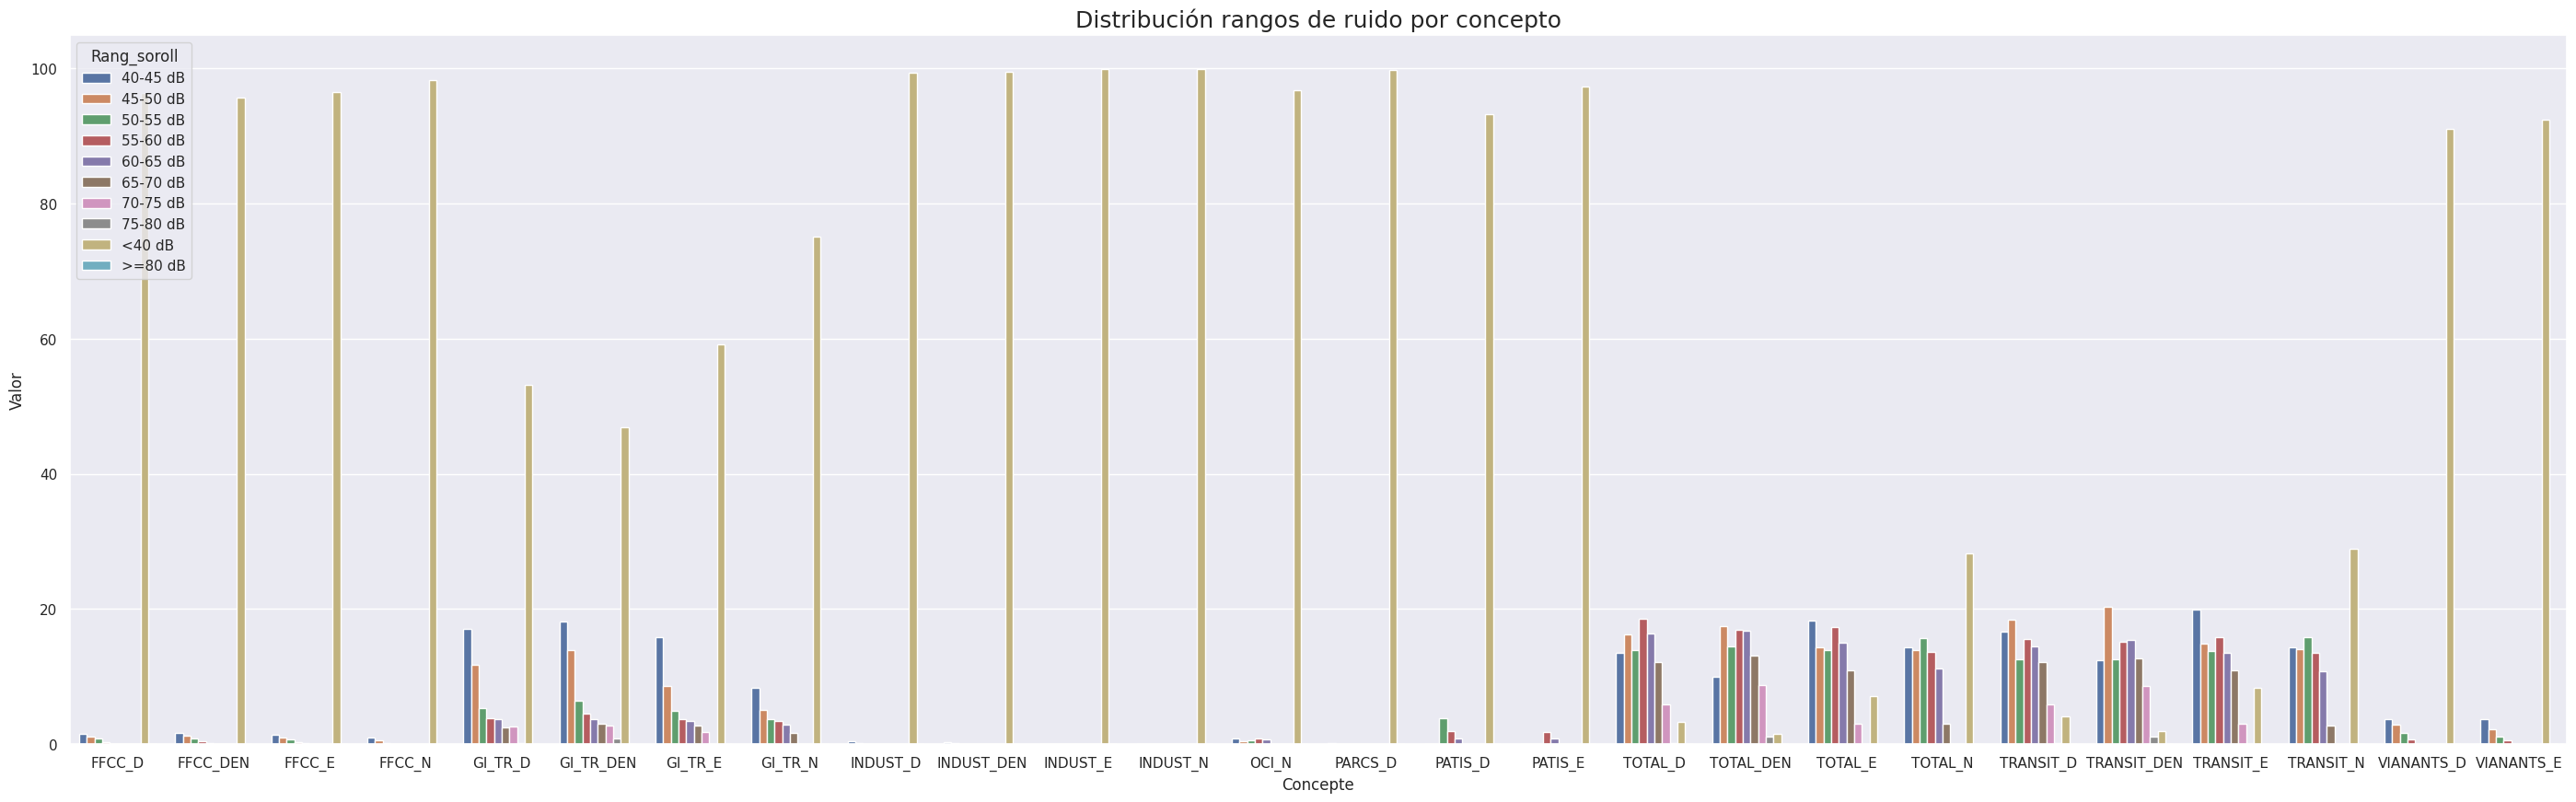

In [41]:
df_ruido['Valor']=df_ruido['Valor'].str[:-1].astype(float)
'''
for districte in pd.unique(df_ruido['Nom_Districte']):
    df_districte=df_ruido.loc[df_ruido['Nom_Districte']==districte]
    df_grouped = df_districte.groupby(['Concepte','Rang_soroll']).agg({'Valor':'mean'}).reset_index()
    sns.set(rc={'figure.figsize':(35,10)})
    sns.barplot(x='Concepte',y='Valor',hue='Rang_soroll',data= df_grouped).set_title('Concepto/Rango ruido en '+districte,fontsize=18)
    plt.show()

for barri in pd.unique(df_ruido['Nom_Barri']):
    df_barri=df_ruido.loc[df_ruido['Nom_Barri']==barri]
    df_grouped = df_barri.groupby(['Concepte','Rang_soroll']).agg({'Valor':'mean'}).reset_index()
    sns.set(rc={'figure.figsize':(35,10)})
    sns.barplot(x='Concepte',y='Valor',hue='Rang_soroll',data= df_grouped).set_title('Concepto/Rango ruido en '+barri,fontsize=18)
    plt.show()    
'''
df_grouped = df_ruido.groupby(['Concepte','Rang_soroll']).agg({'Valor':'mean'}).reset_index()
sns.set(rc={'figure.figsize':(35,10)})
sns.barplot(x='Concepte',y='Valor',hue='Rang_soroll',data= df_grouped).set_title('Distribución rangos de ruido por concepto',fontsize=18)
plt.show()



In [42]:
df_ruido.groupby(['Rang_soroll']).agg({'Valor':'sum'}).reset_index()

Rang_soroll      Valor
0    40-45 dB   14116.04
1    45-50 dB   13015.62
2    50-55 dB   10419.02
3    55-60 dB   10843.49
4    60-65 dB    9466.78
5    65-70 dB    6398.56
6    70-75 dB    3089.16
7    75-80 dB     270.41
8      <40 dB  122180.92
9     >=80 dB       0.00

Como se observa en las distribuciones por concepto y rango de ruido, la mayoría de las localizaciones no presentan una variación significativa del ruido. Los conceptos con mayor variabilidad son los de grandes infraestructuras viarias y transito viario, junto al concepto total. Por tanto, vamos a optar por centrarnos únicamente en el concepto total. Por otra parte, dado que en la gráfica parecía que no había representación de al menos un rango de ruido, si sacamos la suma total para cada rango vemos que ciertamente no tenemos ningun registro de más de 80dB con valor > 0, por lo que podemos prescindir de este rango de ruido.

In [43]:
df_ruido=df_ruido.loc[(df_ruido['Concepte'].str.startswith('TOTAL'))&(df_ruido['Rang_soroll']!='>=80 dB')]

Una vez reducido el dataset de ruido, vamos a volver a ver las distribuciones de los rangos de ruido por franja horaria y para cada uno de los 10 distritos.

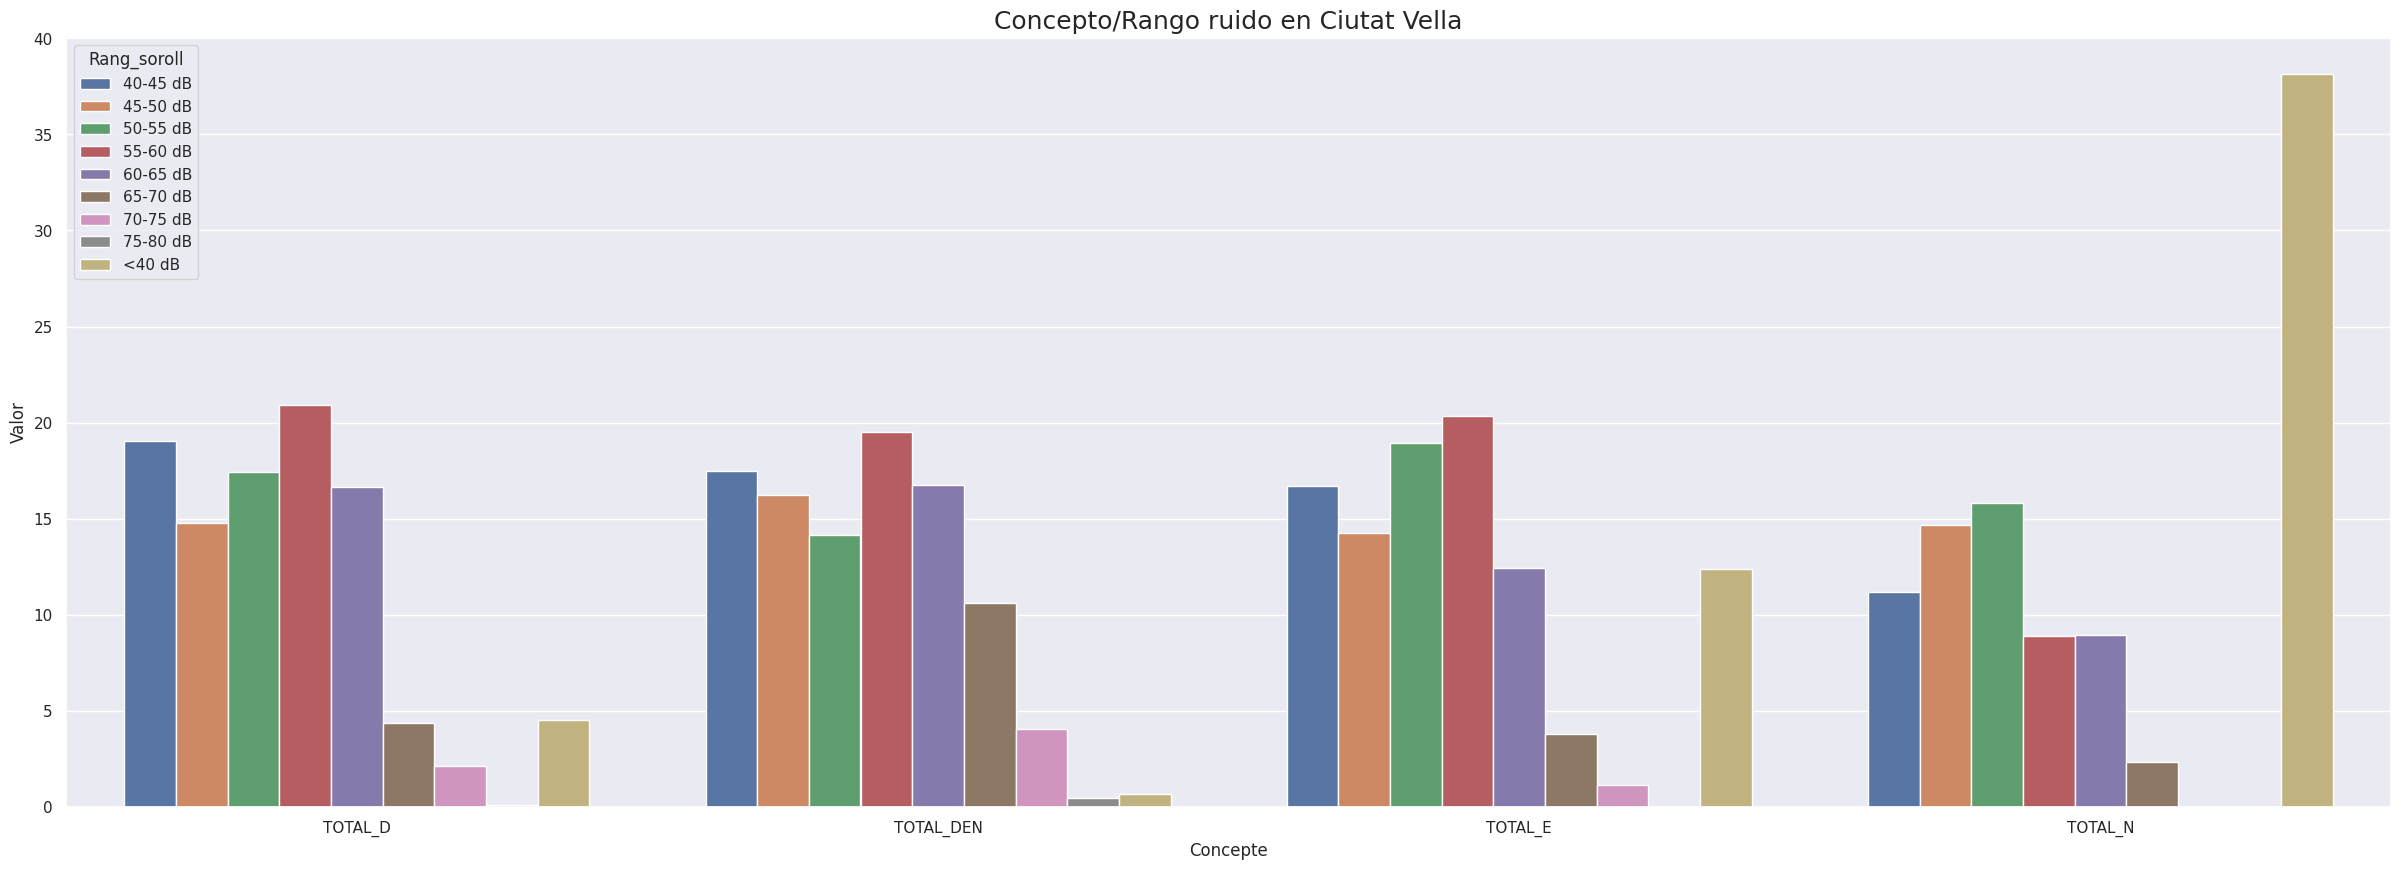

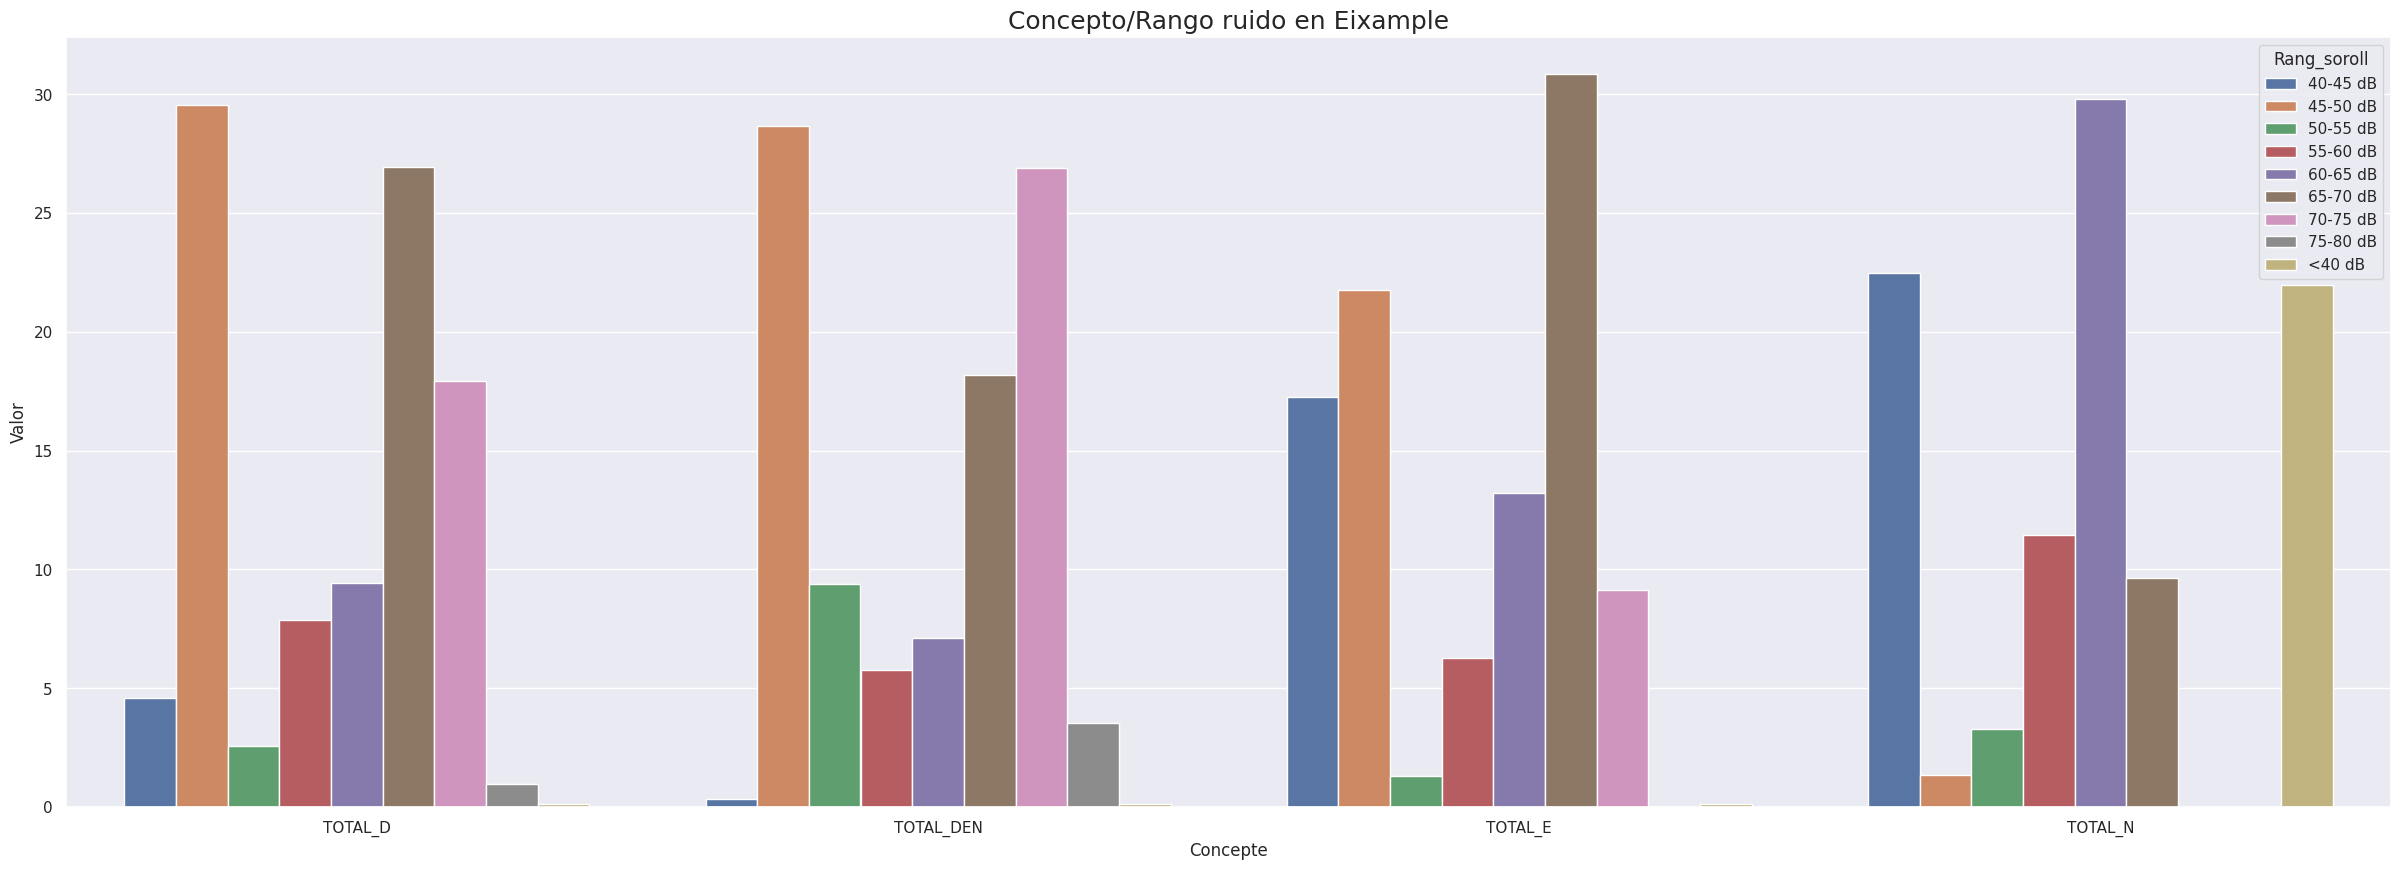

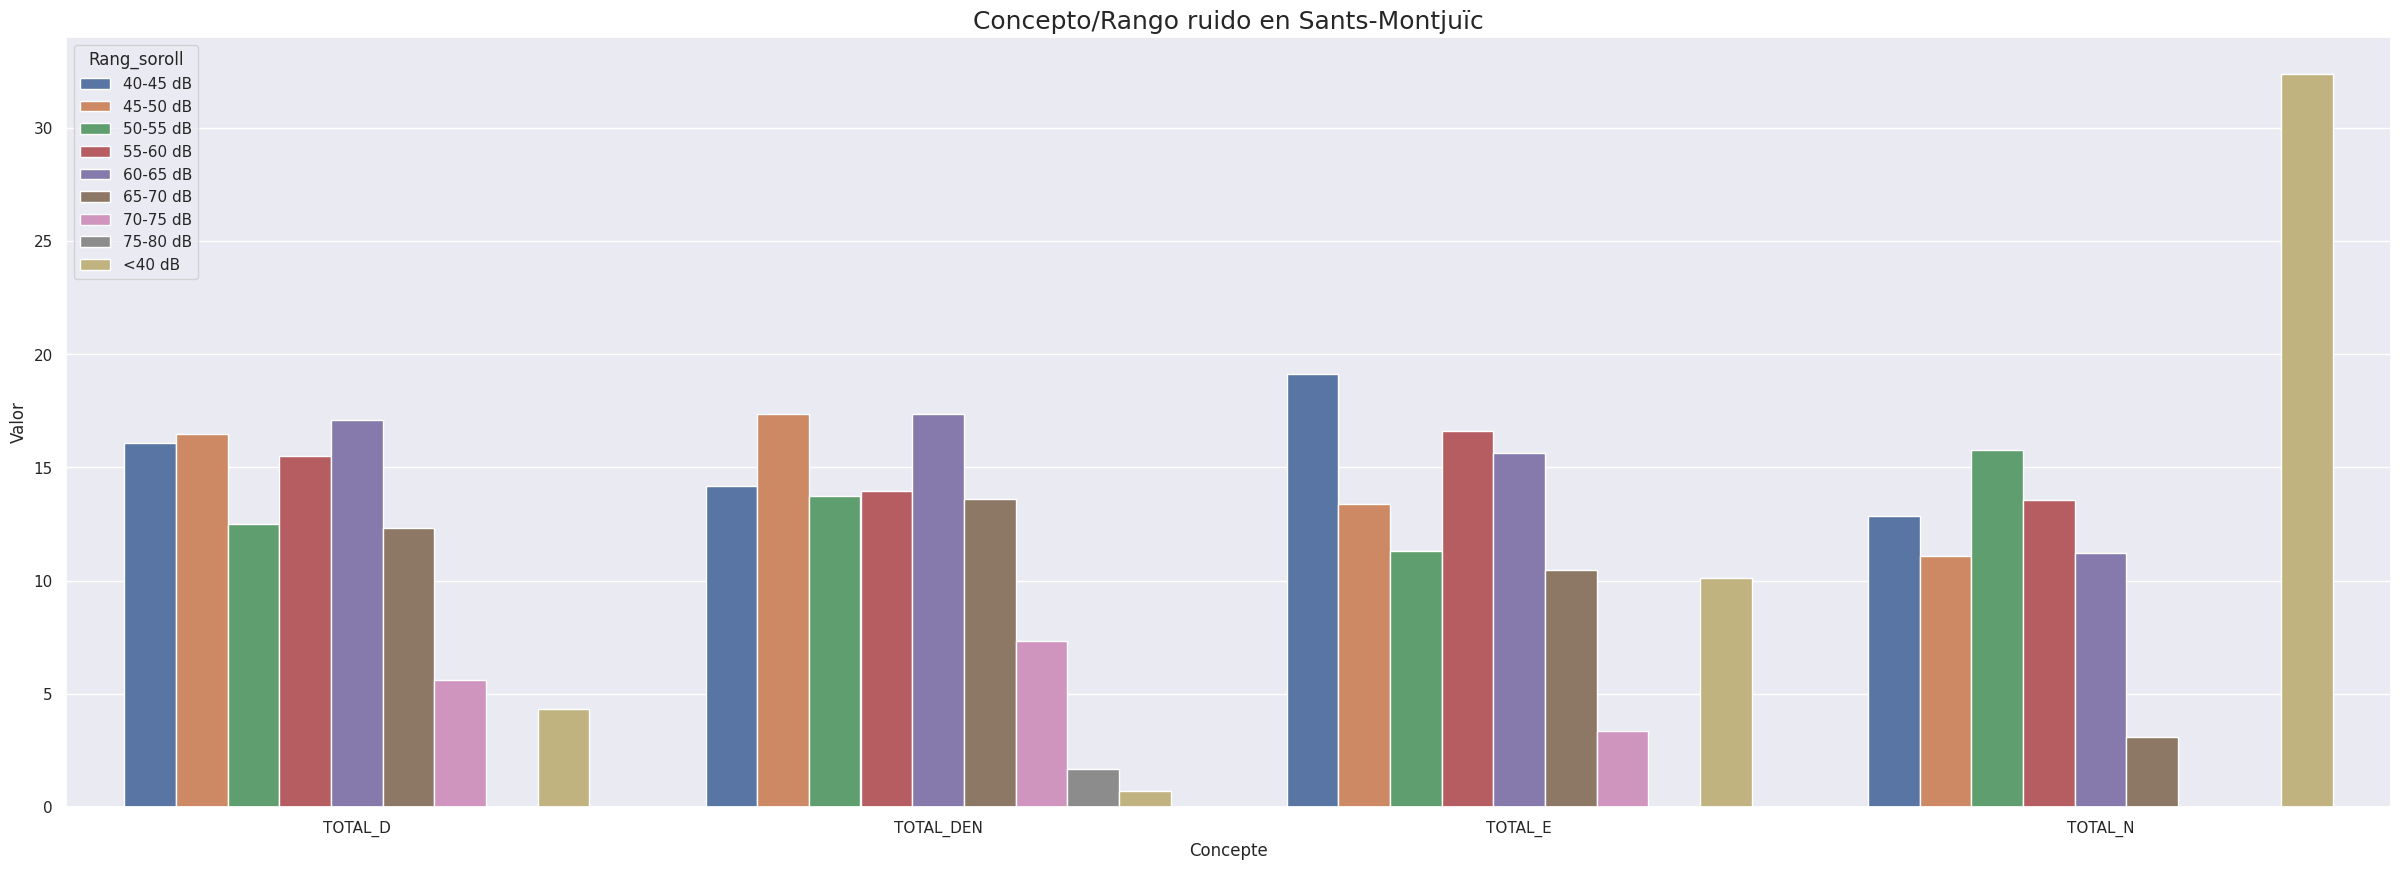

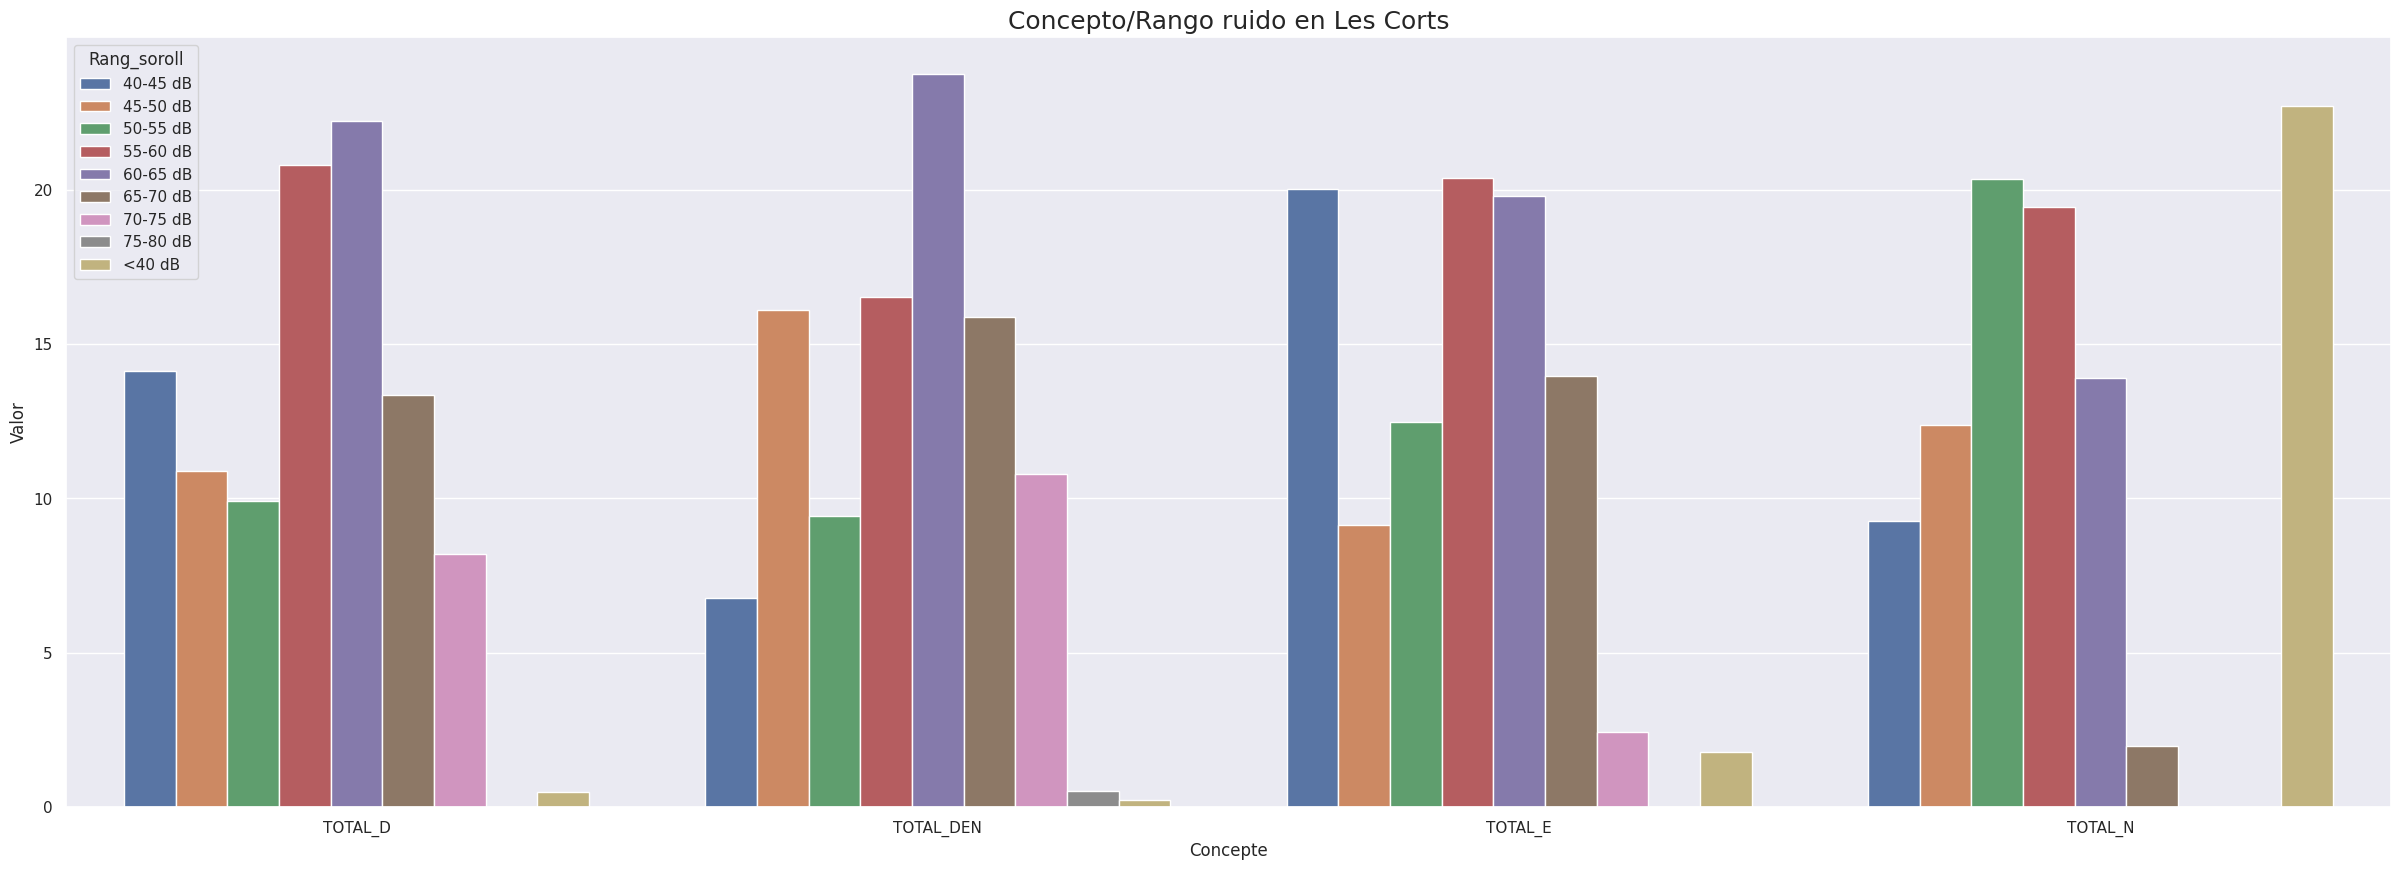

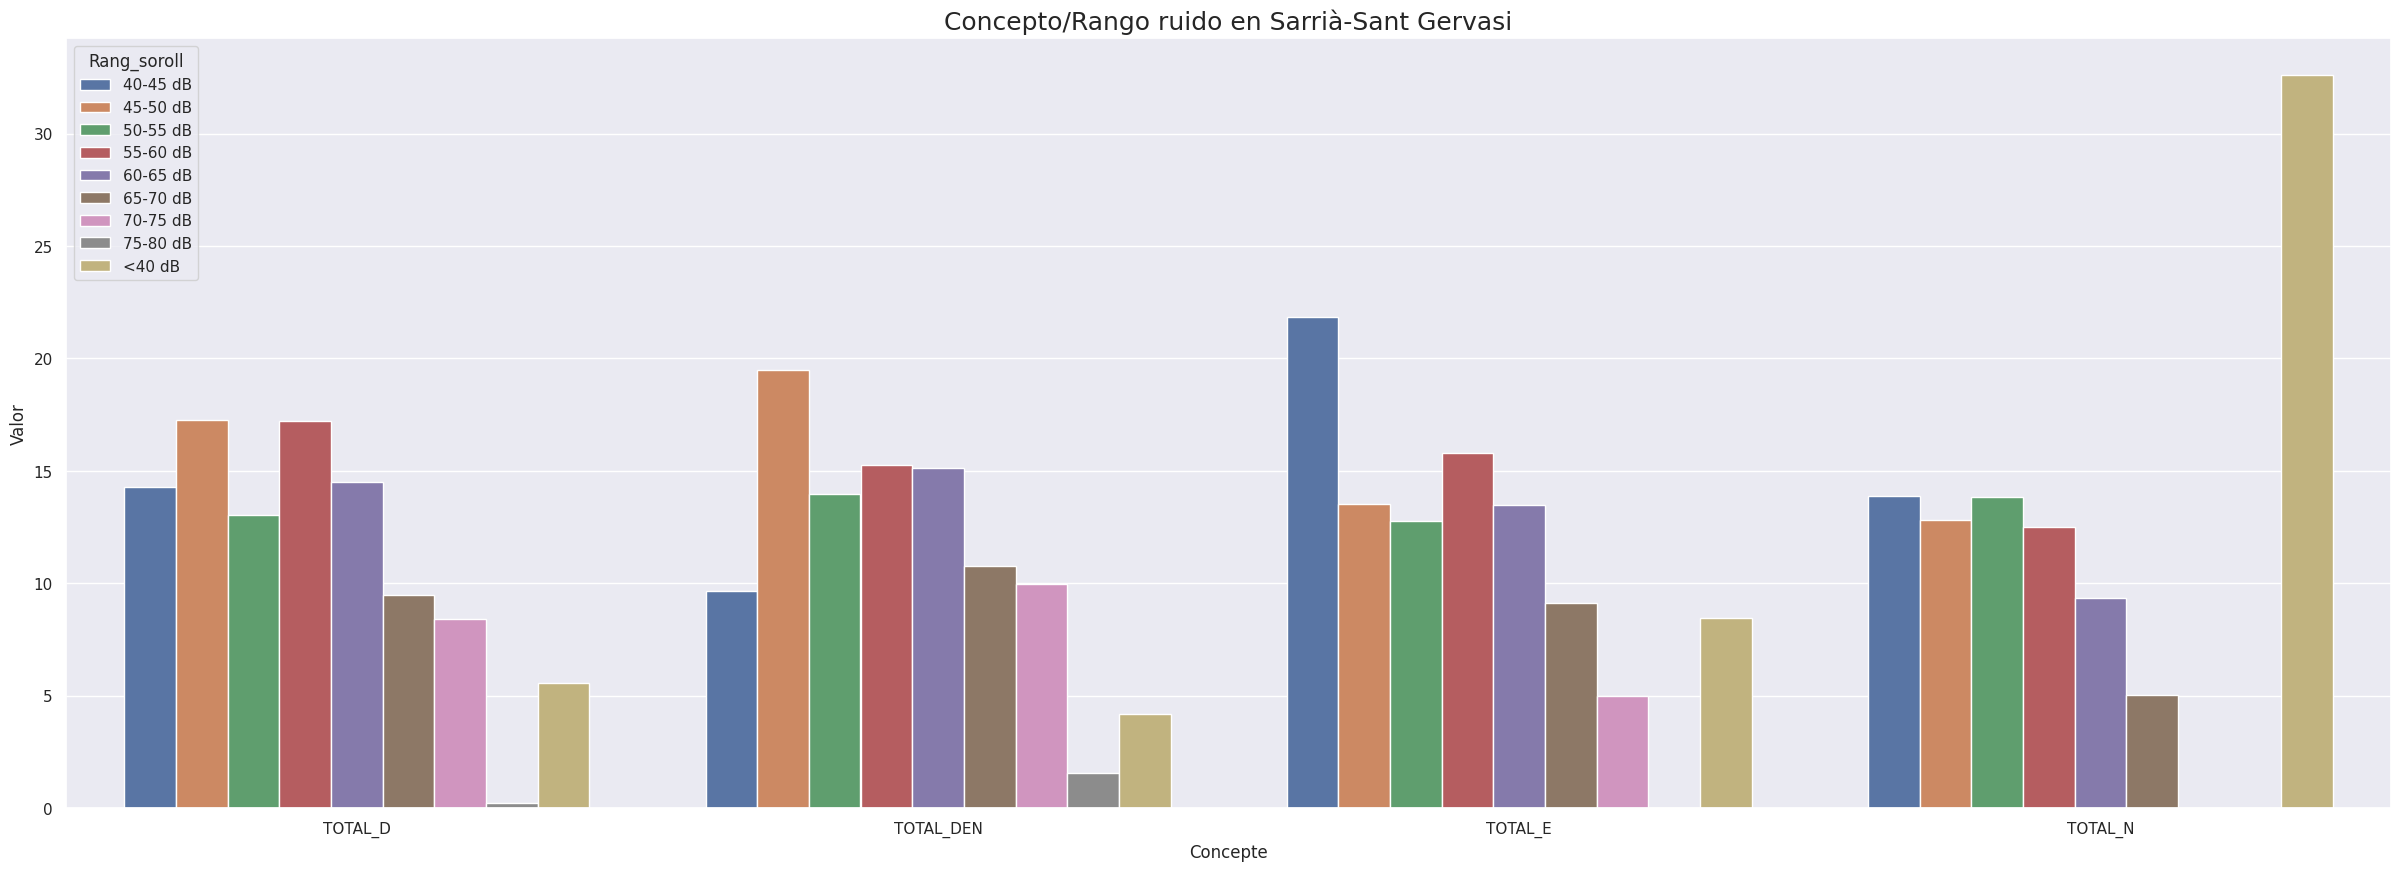

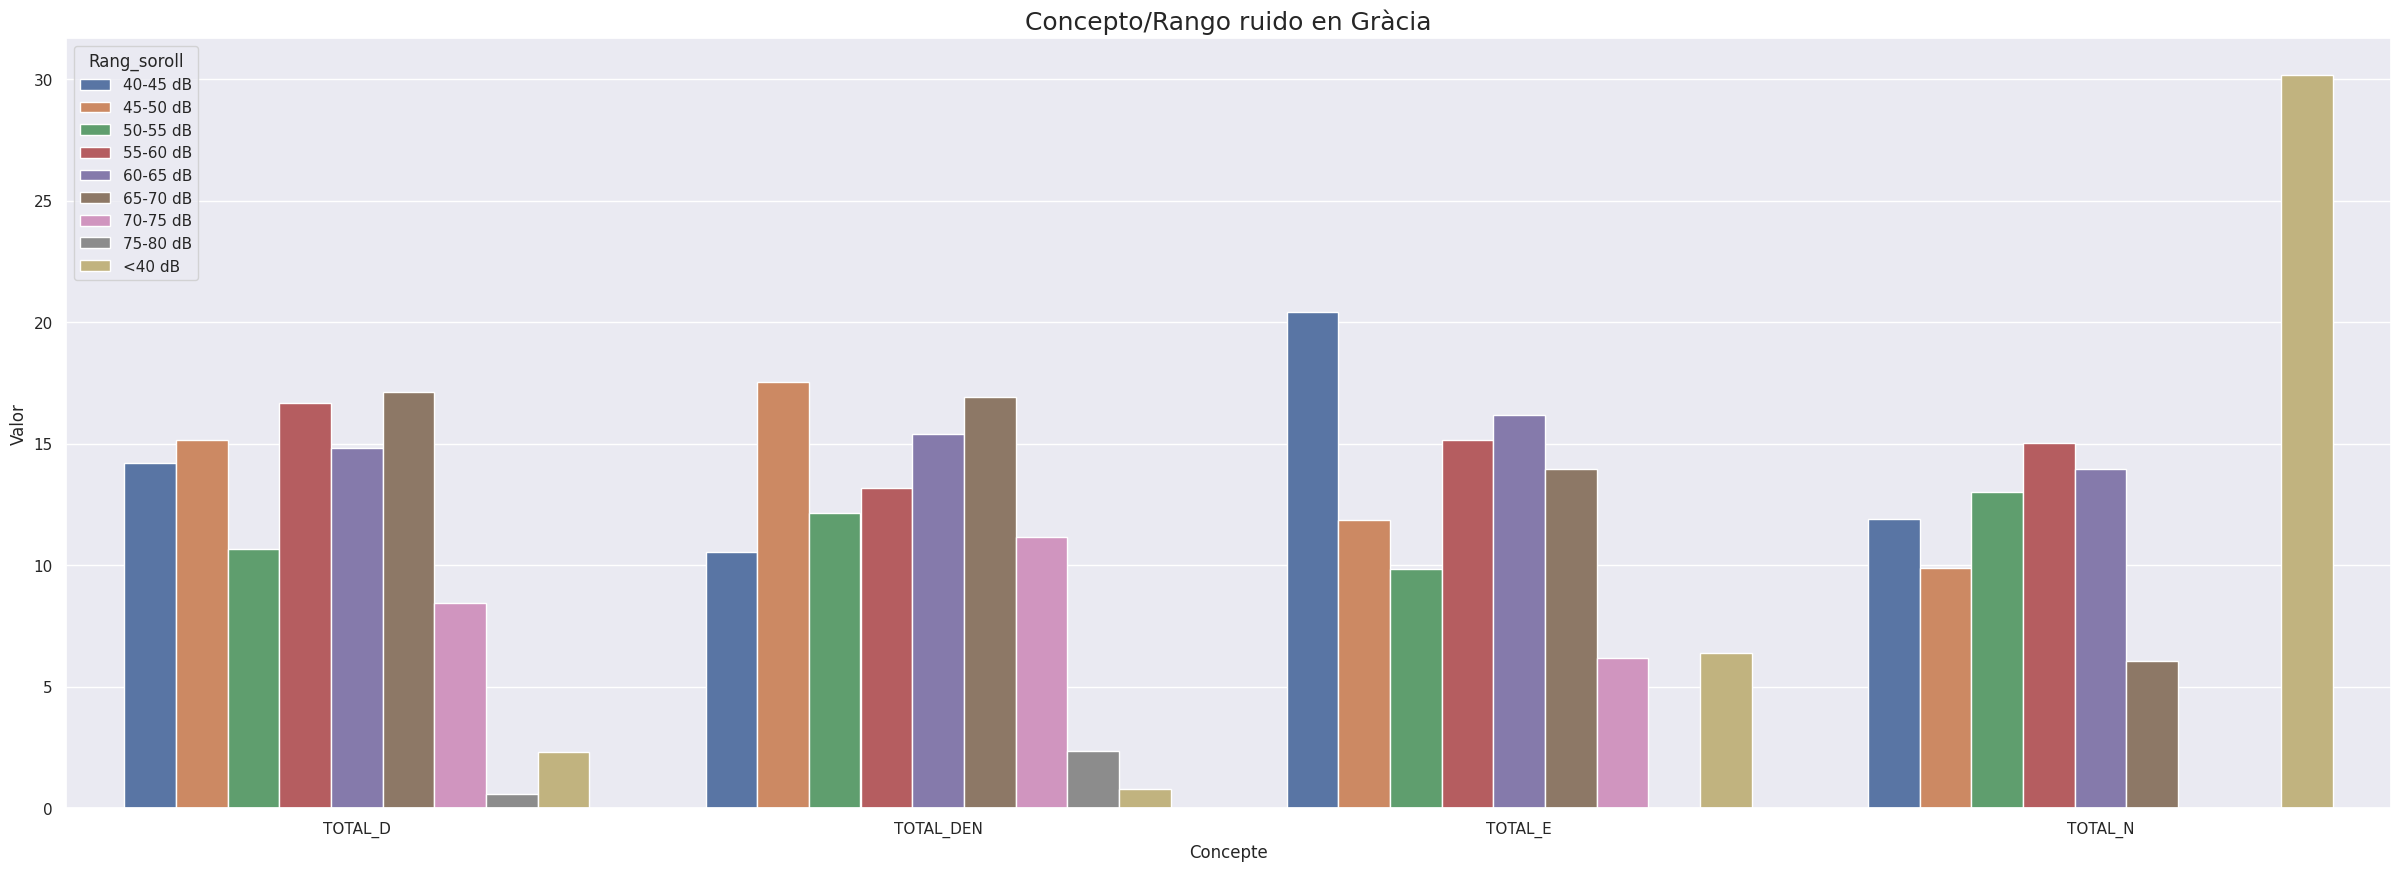

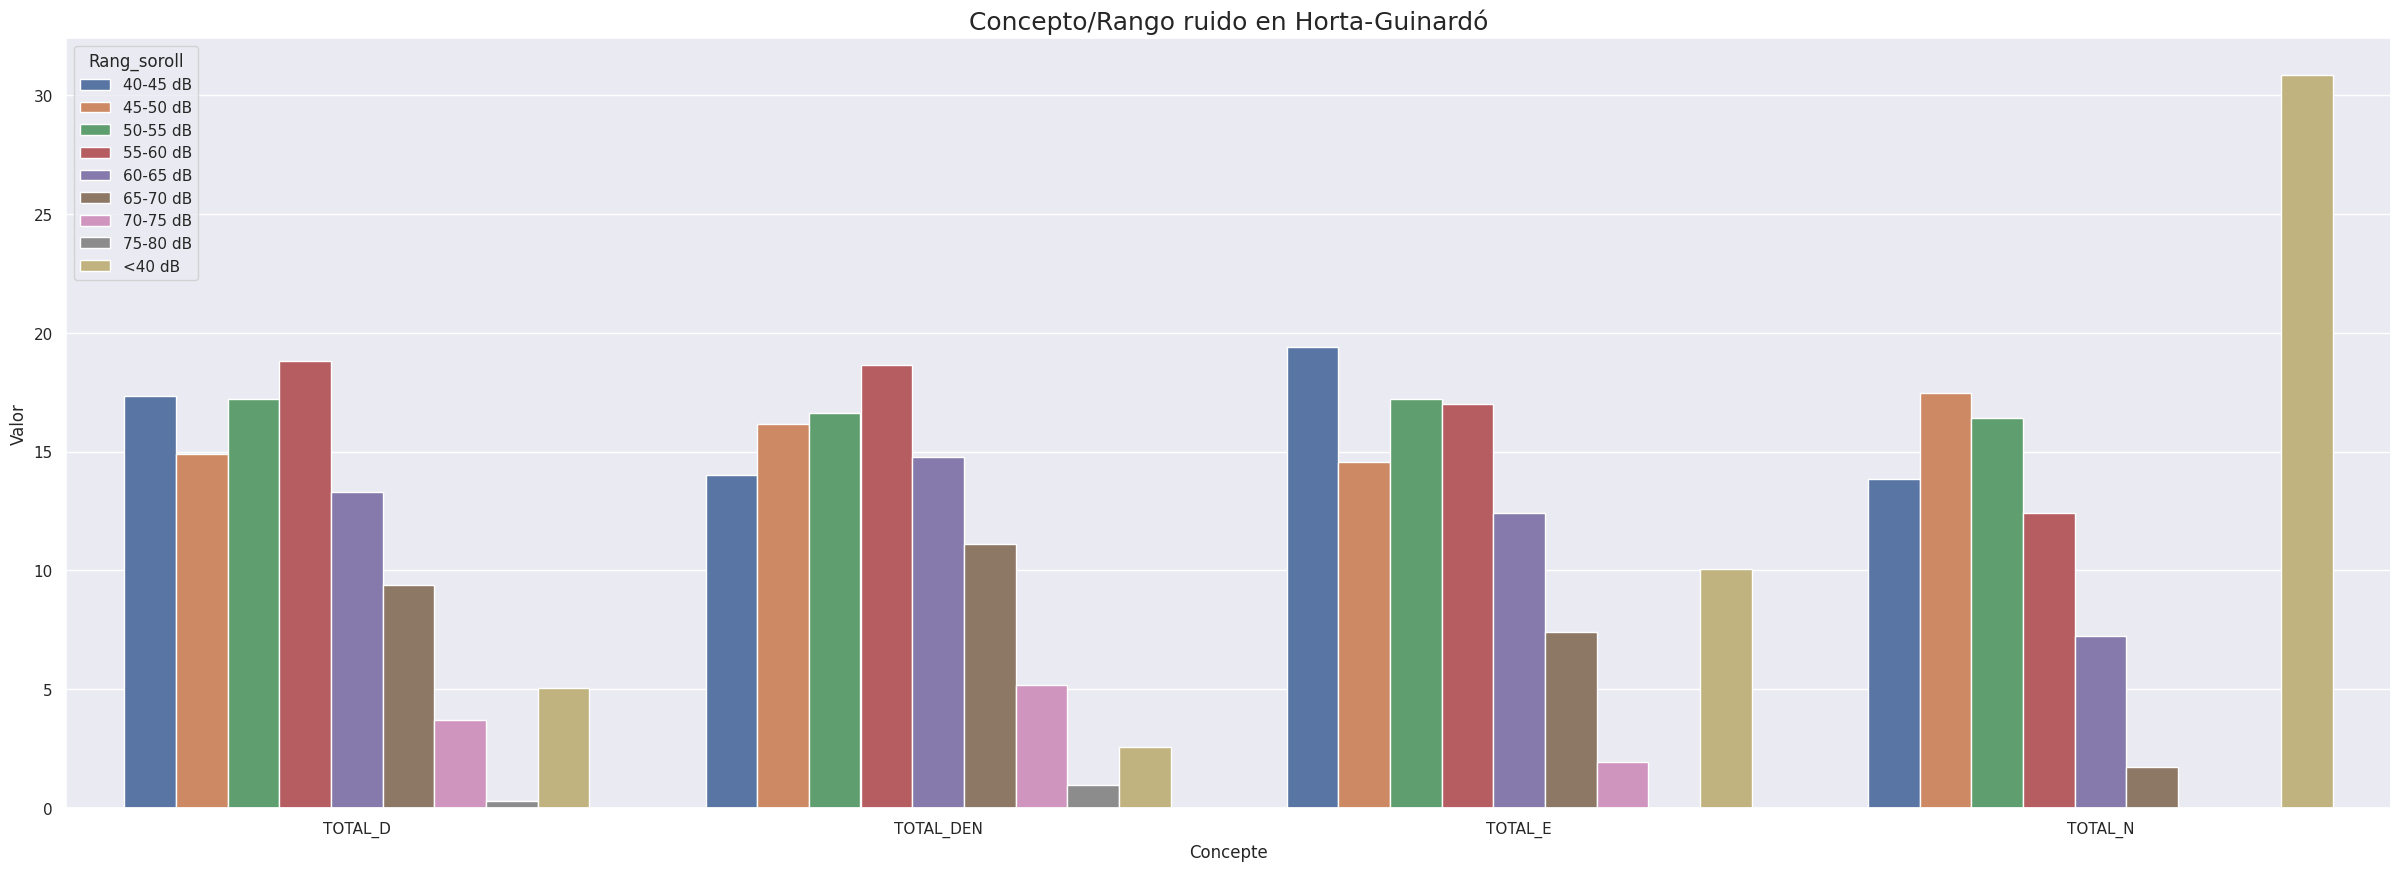

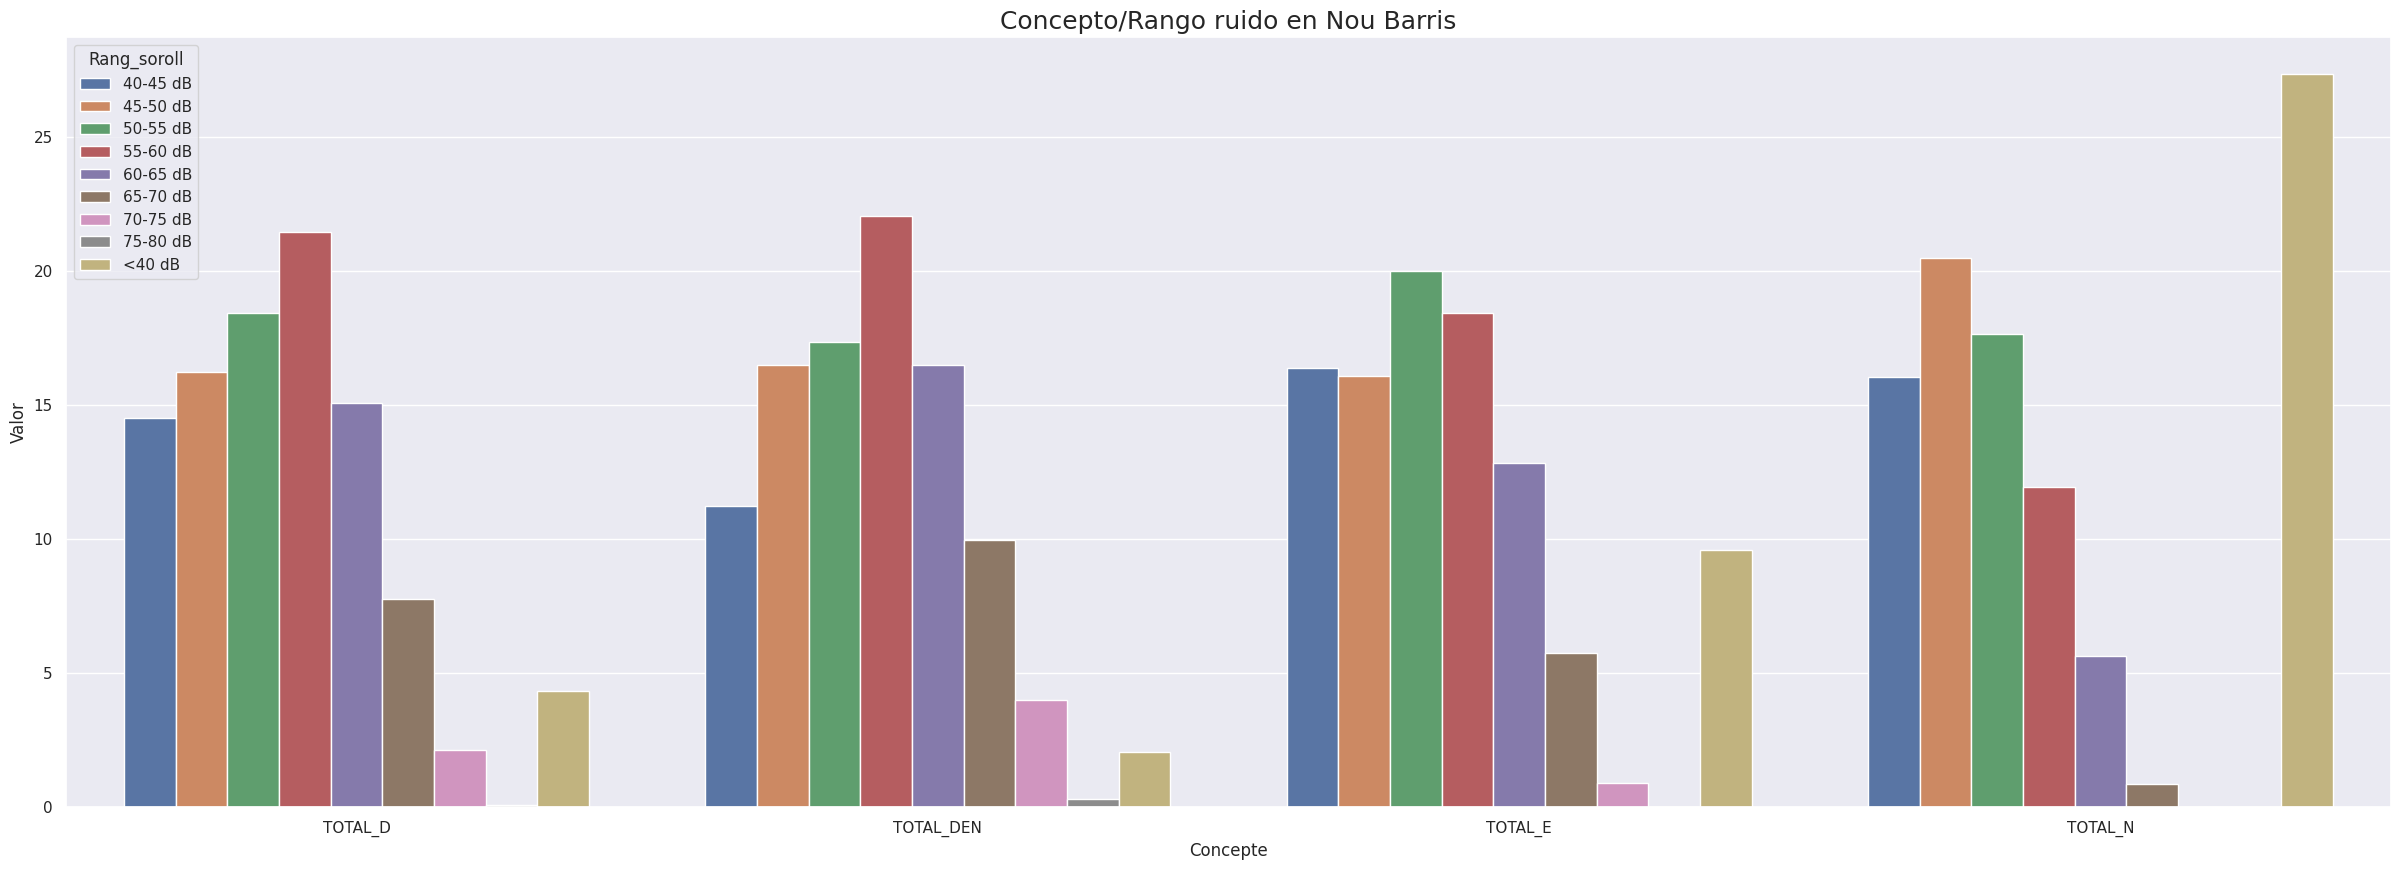

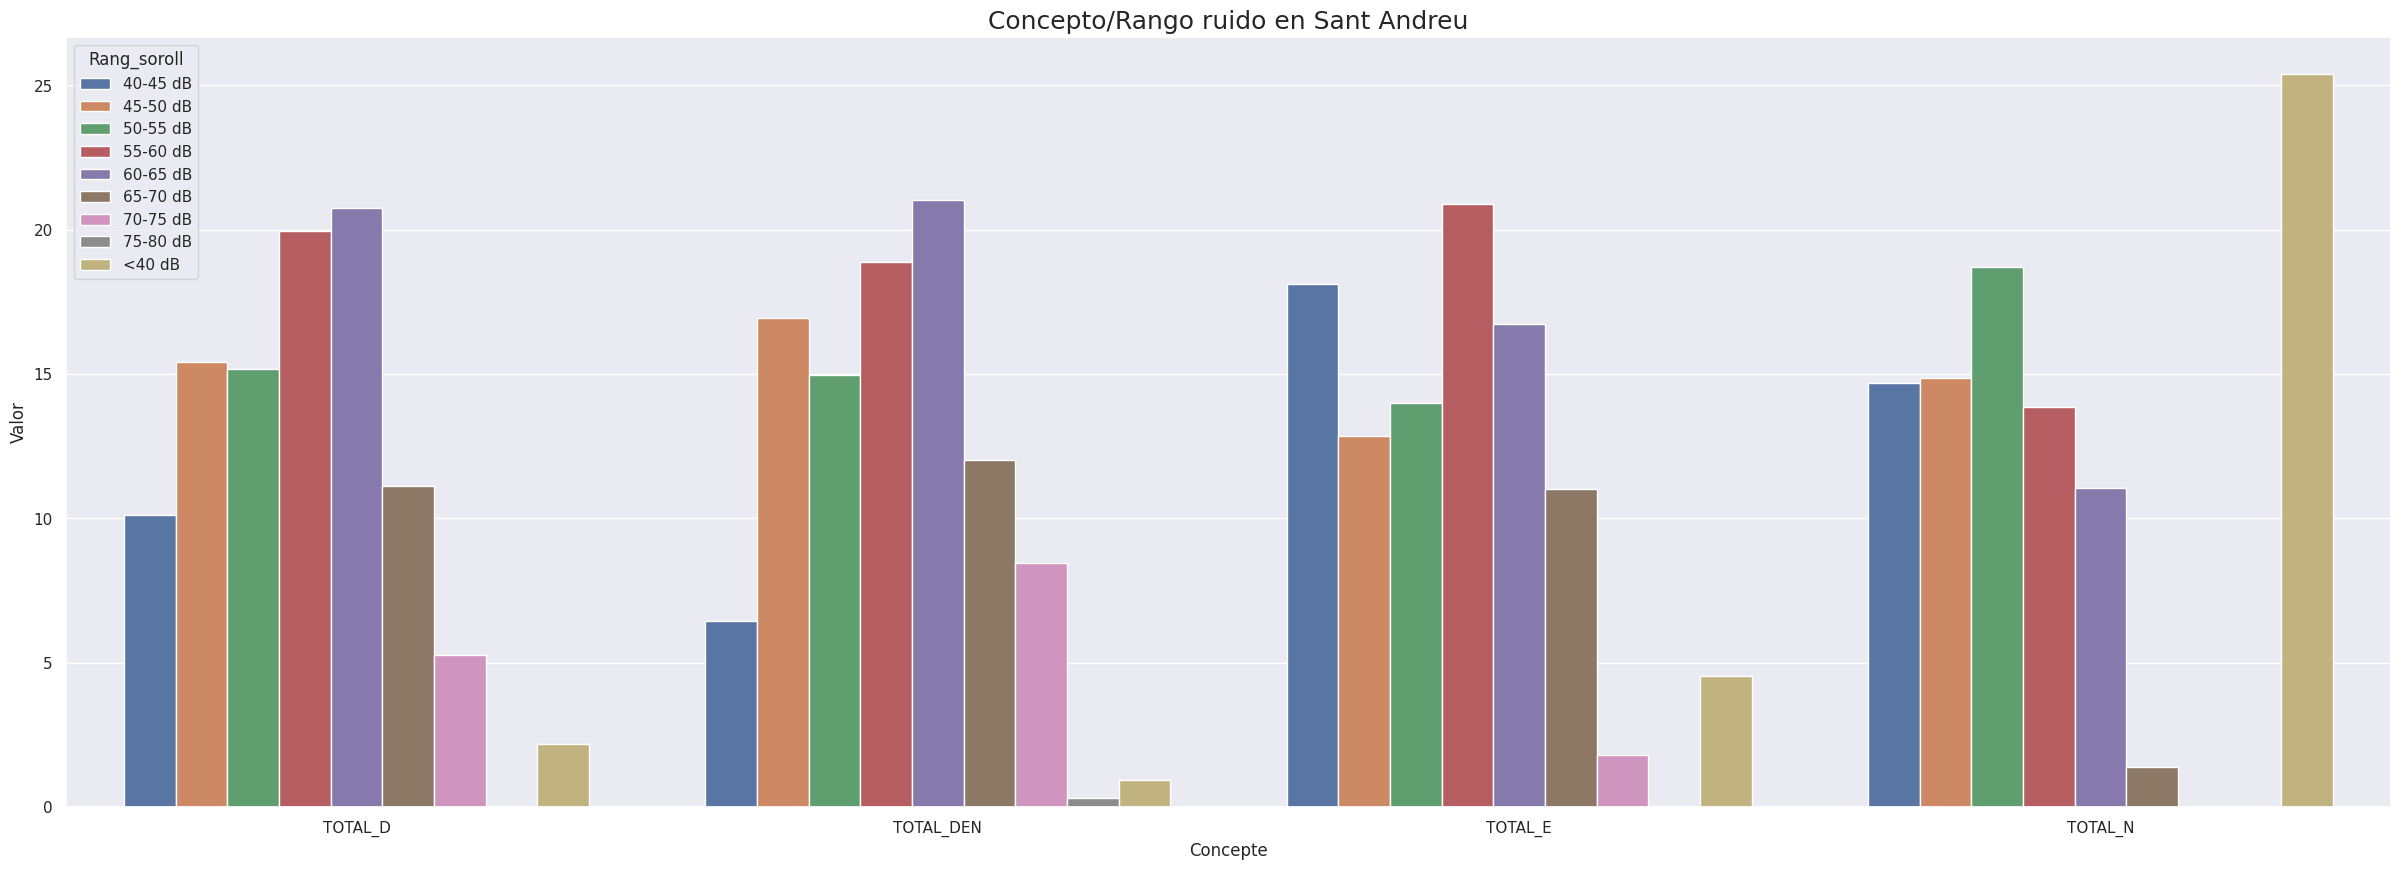

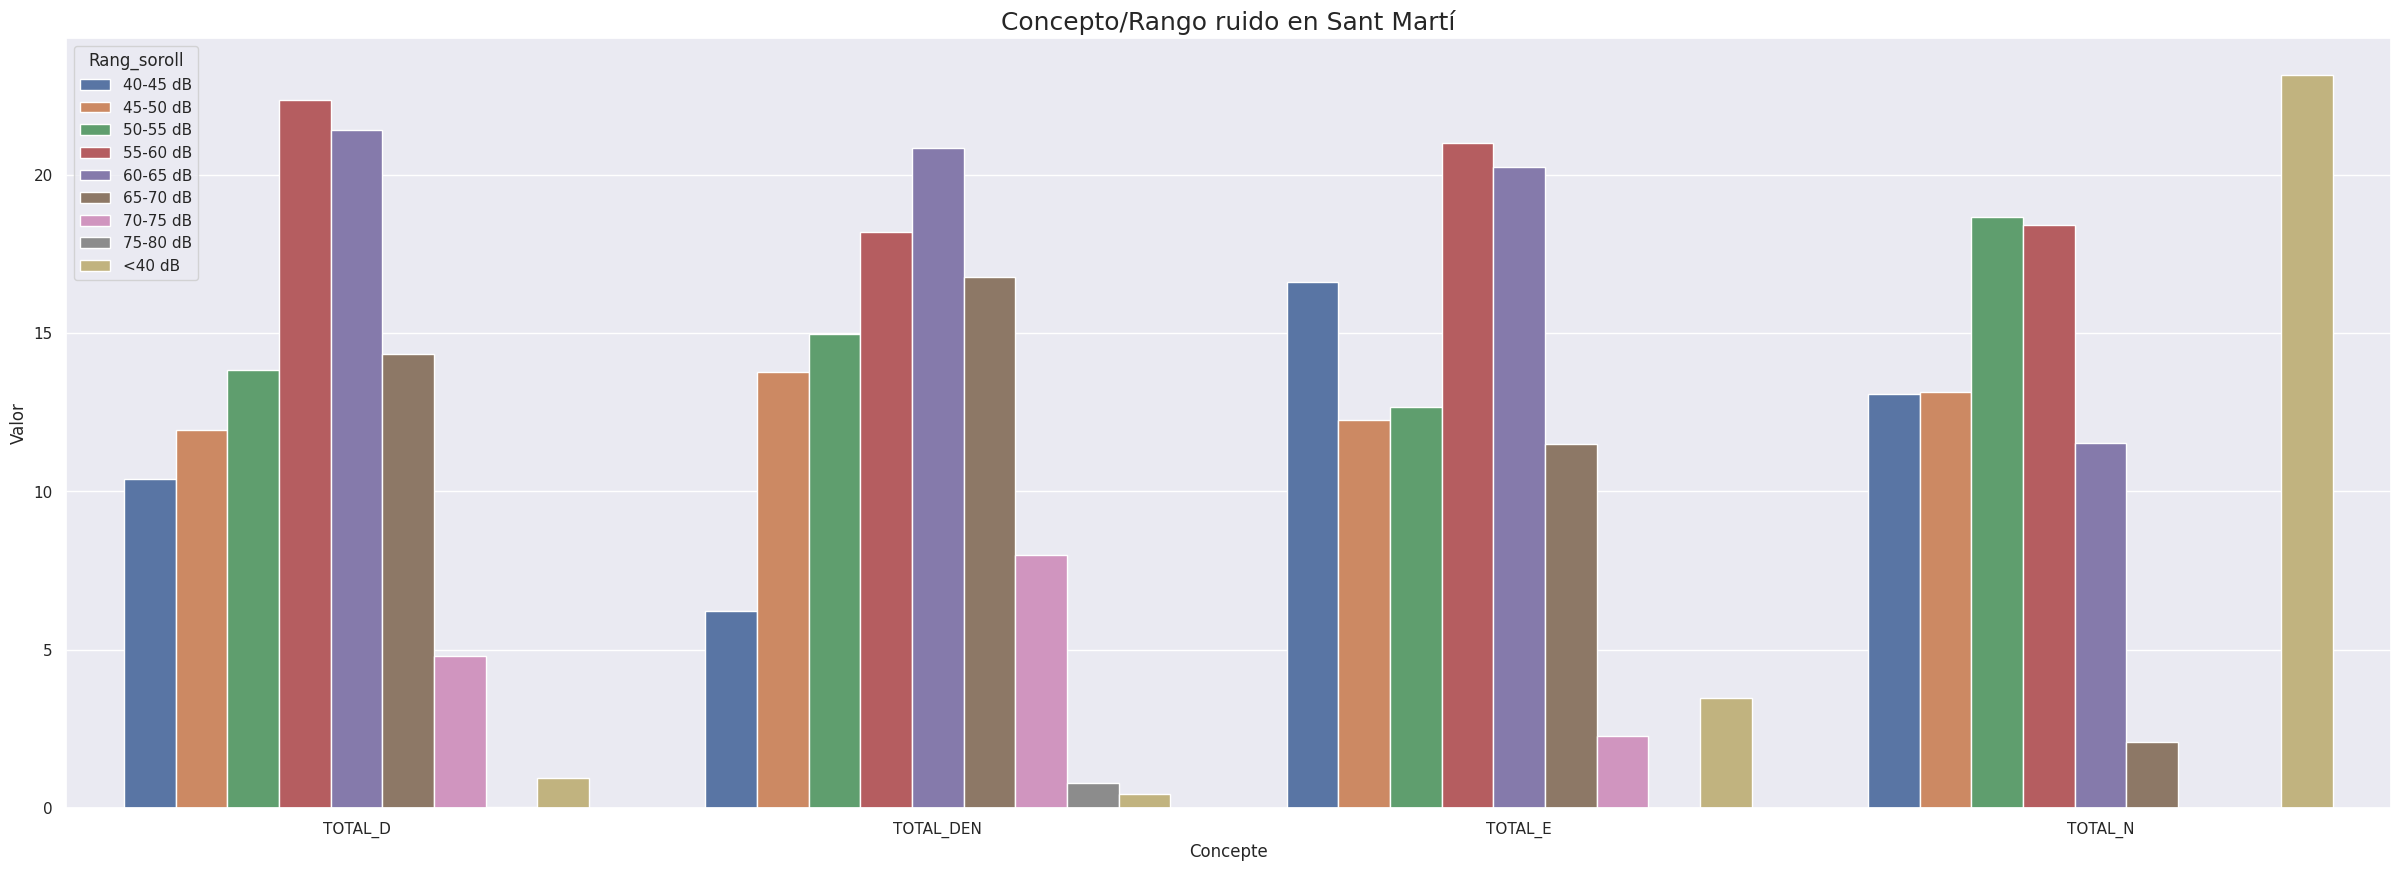

In [44]:
for districte in pd.unique(df_ruido['Nom_Districte']):
    df_districte=df_ruido.loc[df_ruido['Nom_Districte']==districte]
    df_grouped = df_districte.groupby(['Concepte','Rang_soroll']).agg({'Valor':'mean'}).reset_index()
    sns.set(rc={'figure.figsize':(30,10)})
    sns.barplot(x='Concepte',y='Valor',hue='Rang_soroll',data= df_grouped).set_title('Concepto/Rango ruido en '+districte,fontsize=18)
    plt.show()

Como era de esperar la franja nocturna es donde menos ruido se registra. Dentro de esta franja el distrito menos ruidoso es Ciutat Vella, con aproximadamente un 38% de ruido inferior a 40dB. En el otro extremo se encuentra el distrito de la Eixample con un 30% del ruido en el rango de 60-65dB. La Eixample también es durante es durante el día el distrito más ruidoso, por la tarde más del 30% del ruido está en el rango 65-70dB y por el día más del 15% en el rango 70-75dB. Además si observamos el promedio del día, en la Eixample más del 25% del ruido está en el rango 70-75dB y se registra el ratio mayor para el rango de ruido 75-80dB (aproximadamente un 4%). Esto nos lleva también a señalar que el rango de ruido de 75-80dB obtiene una mayor valor para la franja promedio (DEN), que en las franjas por separado. En cuanto al distrito más silencioso durante el día, parece ser Sants-Montjuïc.

Si hacemos el esfuerzo mental de posicionar las barras de <40dB al comienzo de cada distribución, vemos que si bien la mayoría pueden parecer seguir una distribución gaussiana, las distribuciones de la Eixample o las nocturnas se alejan completamente de este tipo de patrón. Dada la variabilidad de estos patrones y la perdida que supondría condensar todas las franjas en un único valor global para cada concepto, vamos a crear 28 columnas para cada combinación de 'Concepte' y 'Rang_soroll' donde se almacenarán los valores de 'Valor' para dicha combinación. Esta será la información que fusionaremos al dataset de alquileres para analizar si existe relación entre el precio de los alquileres y el ruido.

In [45]:
df_ruido['Concepte_Rang_soroll']=df_ruido['Concepte']+'_'+df_ruido['Rang_soroll']
new_cols=pd.unique(df_ruido['Concepte_Rang_soroll']).tolist()
new_df_ruido=pd.DataFrame(columns=['Codi_Districte','Codi_Barri']+new_cols,index=range(73))
for i in range(1,74):
    new_row=[]
    new_row.append(df_ruido['Codi_Districte'].loc[df_ruido['Codi_Barri']==i].values[0]) #Codi_Districte
    new_row.append(i) #Codi_Barri
    for col in new_df_ruido.columns[2:]:
        new_row.append(df_ruido['Valor'].loc[(df_ruido['Codi_Barri']==i)&(df_ruido['Concepte_Rang_soroll']==col)].values[0]) #Valores
    new_df_ruido.loc[i-1]=new_row

In [46]:
new_df_ruido

Codi_Districte Codi_Barri TOTAL_D_<40 dB TOTAL_D_40-45 dB TOTAL_D_45-50 dB  \
0               1          1           7.73            26.98             7.38   
1               1          2           4.27            16.87            16.59   
2               1          3           1.23             9.87            17.32   
3               1          4           4.98            22.45            17.83   
4               2          5           0.17             8.59            21.82   
..            ...        ...            ...              ...              ...   
68             10         69           0.04             4.73             5.68   
69             10         70           6.05            10.44            16.29   
70             10         71           0.18             6.94             6.61   
71             10         72           1.73            10.57            17.91   
72             10         73           0.07             3.76            11.43   

   TOTAL_D_50-55 dB TOTAL_D_55-60 dB TOTAL_D_60-65 dB TOTAL_D_65-70 dB  \
0             11.97            19.85            16.87             7.06   
1              12.7            25.01            19.33              2.3   
2             32.48            22.22            13.05             2.65   
3             12.61            16.53            17.39             5.49   
4              3.65            10.42             9.41            34.13   
..              ...              ...              ...              ...   
68             7.53             31.1            31.98            18.01   
69            21.09            24.89            19.85             1.39   
70            13.67            23.07            31.56            15.94   
71            14.84             21.6            21.78             8.09   
72            24.19             27.2             22.7             7.34   

   TOTAL_D_70-75 dB  ... TOTAL_N_75-80 dB TOTAL_DEN_<40 dB TOTAL_DEN_40-45 dB  \
0              2.16  ...              0.0             0.27              28.36   
1               2.9  ...              0.0             1.66              11.83   
2              0.82  ...              0.0              0.5               8.21   
3              2.72  ...              0.0             0.31              21.55   
4             10.67  ...              0.0             0.17                0.9   
..              ...  ...              ...              ...                ...   
68             0.93  ...              0.0             0.04               2.36   
69              0.0  ...              0.0             3.65                7.6   
70             2.03  ...              0.0             0.02               3.26   
71             3.48  ...              0.0             0.14               8.89   
72             3.31  ...              0.0             0.04               1.73   

   TOTAL_DEN_45-50 dB TOTAL_DEN_50-55 dB TOTAL_DEN_55-60 dB  \
0               11.97               7.95               15.4   
1               19.94              12.11              21.15   
2               13.05              27.56              28.55   
3               19.97               9.06              12.97   
4               25.83              10.18               6.93   
..                ...                ...                ...   
68               7.15              10.85              19.78   
69              15.74               20.0              25.89   
70               6.44              15.63              19.14   
71              18.44              14.06              17.72   
72               9.09              21.22               29.2   

   TOTAL_DEN_60-65 dB TOTAL_DEN_65-70 dB TOTAL_DEN_70-75 dB TOTAL_DEN_75-80 dB  
0               15.75              14.35               5.85                0.1  
1               14.62              12.75                5.5               0.44  
2               14.54               6.26               0.73                0.6  
3                22.1               9.02               4.23               0.79  
4     

## Dataset Combinado

De cara a combinar los datos de ruido con los de alquileres tenemos que eliminar los barrios eliminados para el dataset anterior y replicar el dataset 4 veces por cada uno de los trimestres existente en el dataset de alquileres.np.sum(np.any(cond_outliers,axis=1).astype(int))

In [47]:
#Eliminamos los barrios con missing values en el dataset de alquileres
new_df_ruido=new_df_ruido.loc[new_df_ruido['Codi_Barri'].isin(remove_barrio)==False]
new_df_ruido.reset_index(drop=True,inplace=True)

#Replicamos el dataset para los 4 trimestres del dataset de alquileres y combinamos la información
ruido_cols=pd.concat([new_df_ruido.iloc[:,2:]]*4, ignore_index=True)
df_comb=pd.concat([new_df_alquiler,ruido_cols], axis=1)
df_comb

Trimestre  Codi_Districte  Codi_Barri     Preu  Preu/m2  Superficie  \
0            1               1           1   734.99    13.50       54.44   
1            1               1           2   905.26    14.14       64.02   
2            1               1           3   722.78    19.46       37.14   
3            1               1           4   895.28    15.01       59.65   
4            1               2           5   871.08    12.77       68.21   
..         ...             ...         ...      ...      ...         ...   
267          4              10          69  1233.01    16.51       74.68   
268          4              10          70   621.32    10.40       59.74   
269          4              10          71   864.09    12.66       68.25   
270          4              10          72   790.58    10.83       73.00   
271          4              10          73   692.67    10.38       66.73   

    TOTAL_D_<40 dB TOTAL_D_40-45 dB TOTAL_D_45-50 dB TOTAL_D_50-55 dB  ...  \
0             7.73            26.98             7.38            11.97  ...   
1             4.27            16.87            16.59             12.7  ...   
2             1.23             9.87            17.32            32.48  ...   
3             4.98            22.45            17.83            12.61  ...   
4             0.17             8.59            21.82             3.65  ...   
..             ...              ...              ...              ...  ...   
267           0.04             4.73             5.68             7.53  ...   
268           6.05            10.44            16.29            21.09  ...   
269           0.18             6.94             6.61            13.67  ...   
270           1.73            10.57            17.91            14.84  ...   
271           0.07             3.76            11.43            24.19  ...   

    TOTAL_N_75-80 dB TOTAL_DEN_<40 dB TOTAL_DEN_40-45 dB TOTAL_DEN_45-50 dB  \
0                0.0             0.27              28.36              11.97   
1                0.0             1.66              11.83              19.94   
2                0.0              0.5               8.21              13.05   
3                0.0             0.31              21.55              19.97   
4                0.0             0.17                0.9              25.83   
..               ...              ...                ...                ...   
267              0.0             0.04               2.36               7.15   
268              0.0             3.65                7.6              15.74   
269              0.0             0.02               3.26               6.44   
270              0.0             0.14               8.89              18.44   
271              0.0             0.04               1.73               9.09   

    TOTAL_DEN_50-55 dB TOTAL_DEN_55-60 dB TOTAL_DEN_60-65 dB  \
0                 7.95               15.4              15.75   
1                12.11              21.15              14.62   
2                27.56              28.55              14.54   
3                 9.06              12.97               22.1   
4                10.18               6.93               6.67   
..                 ...                ...                ...   
267              10.85              19.78              34.32   
268               20.0              25.89              21.74   
269              15.63              19.14              23.98   
270              14.06              17.72              21.71   
271              21.22               29.2              21.59   

    TOTAL_DEN_65-70 dB TOTAL_DEN_70-75 dB TOTAL_DEN_75-80 dB  
0                14.35               5.85                0.1  
1                12.75                5.5               0.44  
2                 6.26               0.73                0.6  
3                 9.02               4.23               0.79  
4                24.74              22.04               2.54  
..                 ...                ...                ..

### Estudio de Outliers

Aprovechando que ya tenemos todos los datos fusionados y todos son de caracter numérico, vamos a realizar un análisis de outliers.

In [48]:
q1=df_comb.quantile(0.25)
q3=df_comb.quantile(0.75)
IQR=q3-q1
cond_outliers=((df_comb<(q1-1.5*IQR)) | (df_comb>(q3+1.5*IQR)))
n_outliers=cond_outliers.astype(int).sum()
n_row_affected=np.sum(np.any(cond_outliers,axis=1).astype(int))

table_outliers = pd.DataFrame({
    "No Outliers" : n_outliers,
    "% Outliers": np.round(n_outliers/len(df_comb)*100,2),
})

print(f'Número de filas afectadas por outliers: {n_row_affected} ({np.round(n_row_affected/len(df_comb)*100,2)}%)')
table_outliers

Número de filas afectadas por outliers: 141 (51.84%)


No Outliers  % Outliers
Trimestre                     0        0.00
Codi_Districte                0        0.00
Codi_Barri                    0        0.00
Preu                         20        7.35
Preu/m2                       7        2.57
Superficie                   21        7.72
TOTAL_D_<40 dB               16        5.88
TOTAL_D_40-45 dB              0        0.00
TOTAL_D_45-50 dB              4        1.47
TOTAL_D_50-55 dB             12        4.41
TOTAL_D_55-60 dB              8        2.94
TOTAL_D_60-65 dB              8        2.94
TOTAL_D_65-70 dB              4        1.47
TOTAL_D_70-75 dB              4        1.47
TOTAL_D_75-80 dB             60       22.06
TOTAL_E_<40 dB                8        2.94
TOTAL_E_40-45 dB              0        0.00
TOTAL_E_45-50 dB              4        1.47
TOTAL_E_50-55 dB             12        4.41
TOTAL_E_55-60 dB              4        1.47
TOTAL_E_60-65 dB              8        2.94
TOTAL_E_65-70 dB             20        7.35
TOTAL_E_70-75 dB             16        5.88
TOTAL_E_75-80 dB             12        4.41
TOTAL_N_<40 dB                4        1.47
TOTAL_N_40-45 dB              8        2.94
TOTAL_N_45-50 dB              4        1.47
TOTAL_N_50-55 dB             16        5.88
TOTAL_N_55-60 dB              4        1.47
TOTAL_N_60-65 dB             16        5.88
TOTAL_N_65-70 dB             16        5.88
TOTAL_N_70-75 dB             12        4.41
TOTAL_N_75-80 dB              0        0.00
TOTAL_DEN_<40 dB             44       16.18
TOTAL_DEN_40-45 dB            0        0.00
TOTAL_DEN_45-50 dB            0        0.00
TOTAL_DEN_50-55 dB            8        2.94
TOTAL_DEN_55-60 dB            4        1.47
TOTAL_DEN_60-65 dB            8        2.94
TOTAL_DEN_65-70 dB            0        0.00
TOTAL_DEN_70-75 dB            8        2.94
TOTAL_DEN_75-80 dB           32       11.76

Como se puede observar la mayoría de las filas del dataset están afectadas por outliers, aunque por cada columna el nivel de filas afectadas es por lo general bajo (a excepción de algunas columnas relativas al dataset de ruido como 'TOTAL_D_75-80 dB', 'TOTAL_DEN_<40 dB' o 'TOTAL_DEN_75-80 dB'). La existencia de outliers puede deberse a errores a la hora de registrar los datos o debido a la propia naturaleza del dataset. En el caso del dataset de ruido hemos visto recientemente que no había registro de valores fuera del rango 0-100%, así como en el dataset de alquileres tampoco vimos ningún valor que pudiera quizás deberse a un error. No obstante, como el dataset de alquileres se vio hace más tiempo y de manera desglosada, a continuación mostraremos las distribuciones de sus 3 columnas de interés.

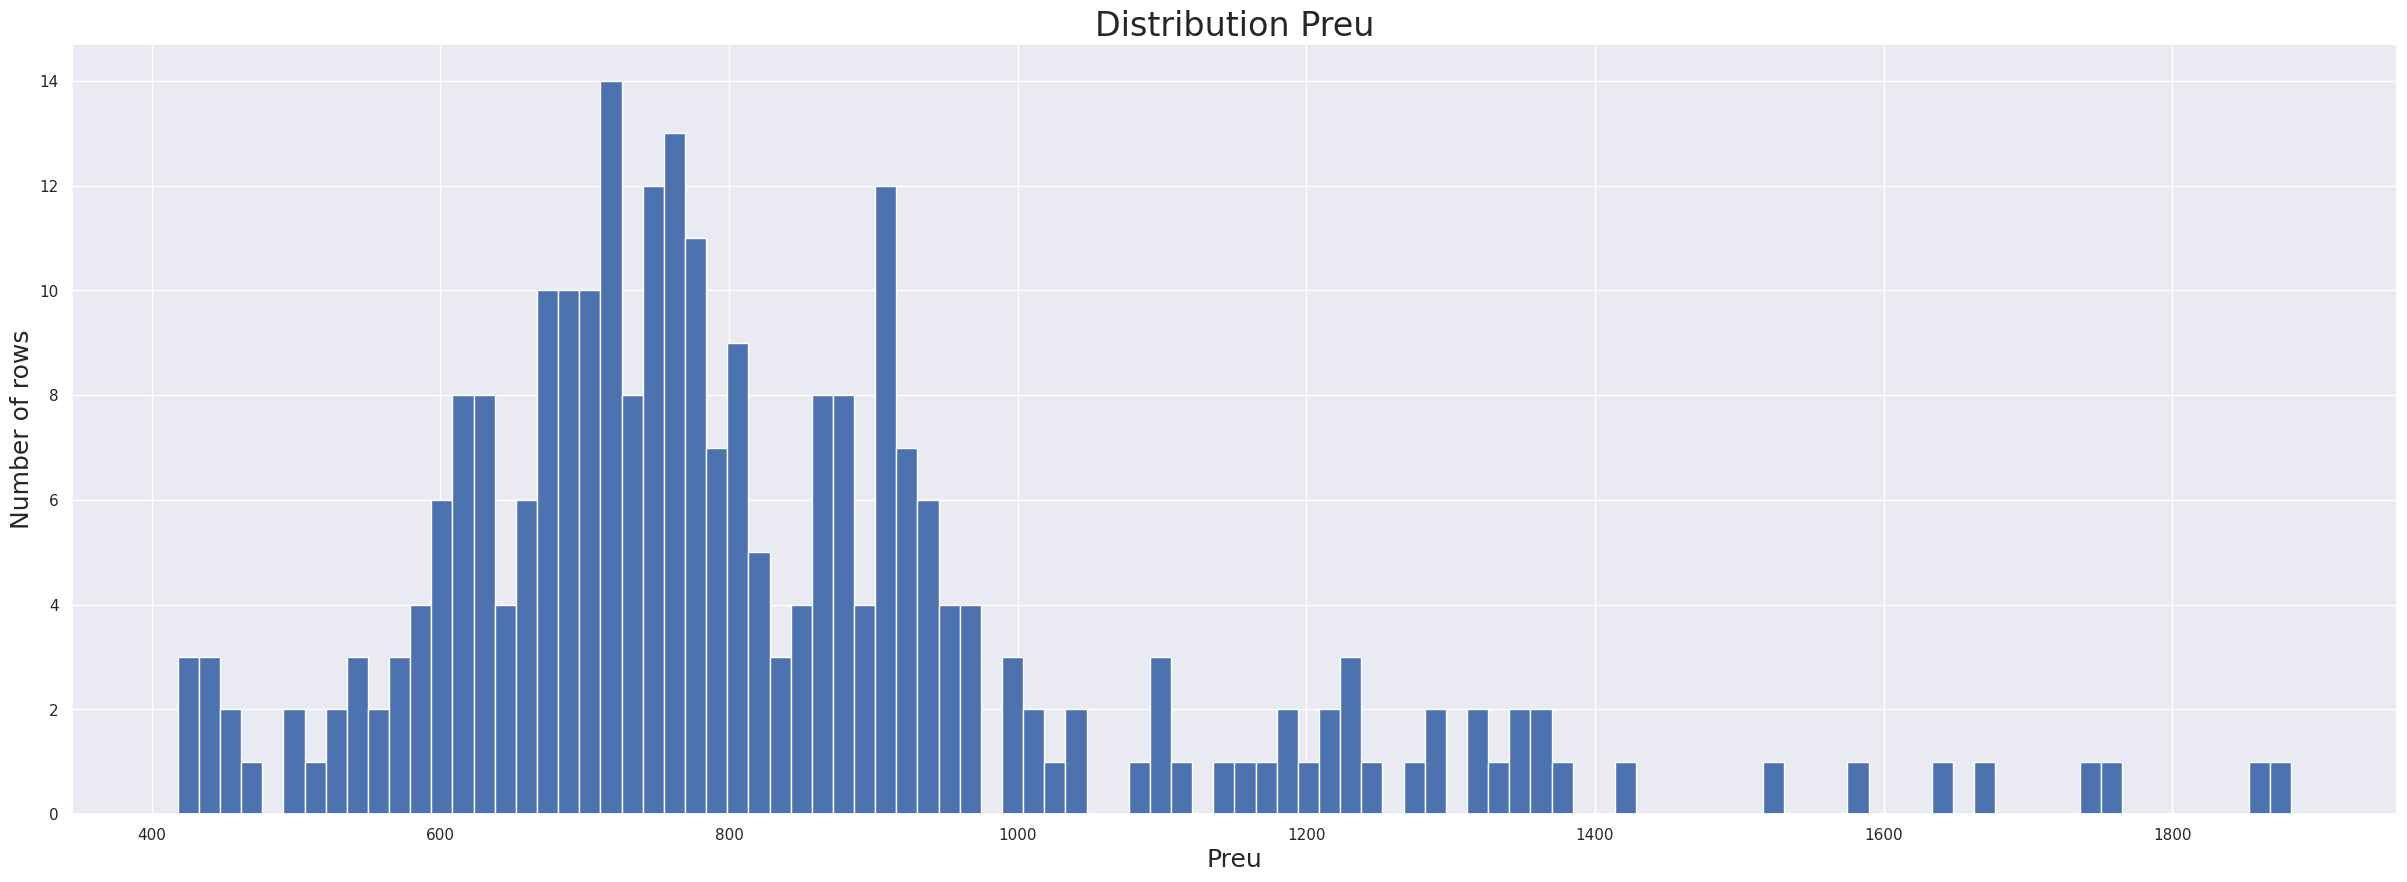

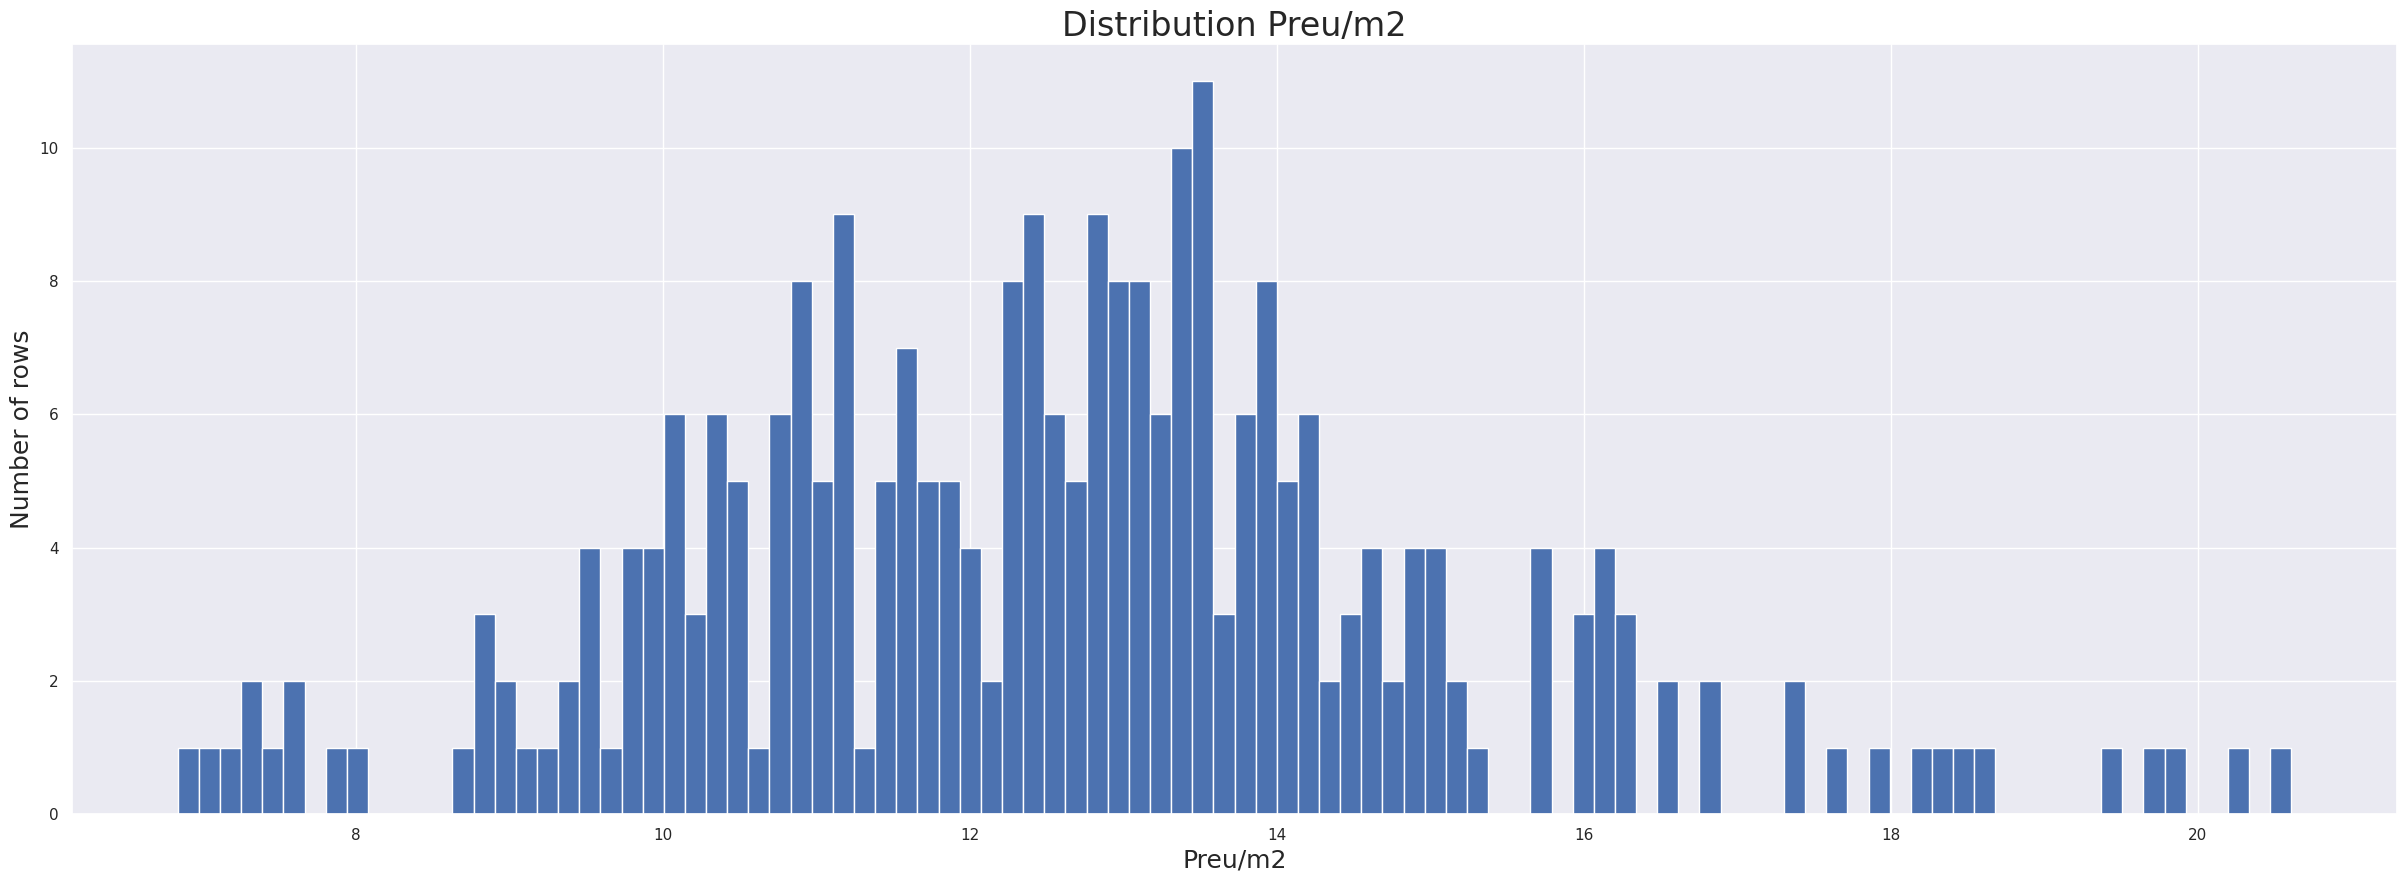

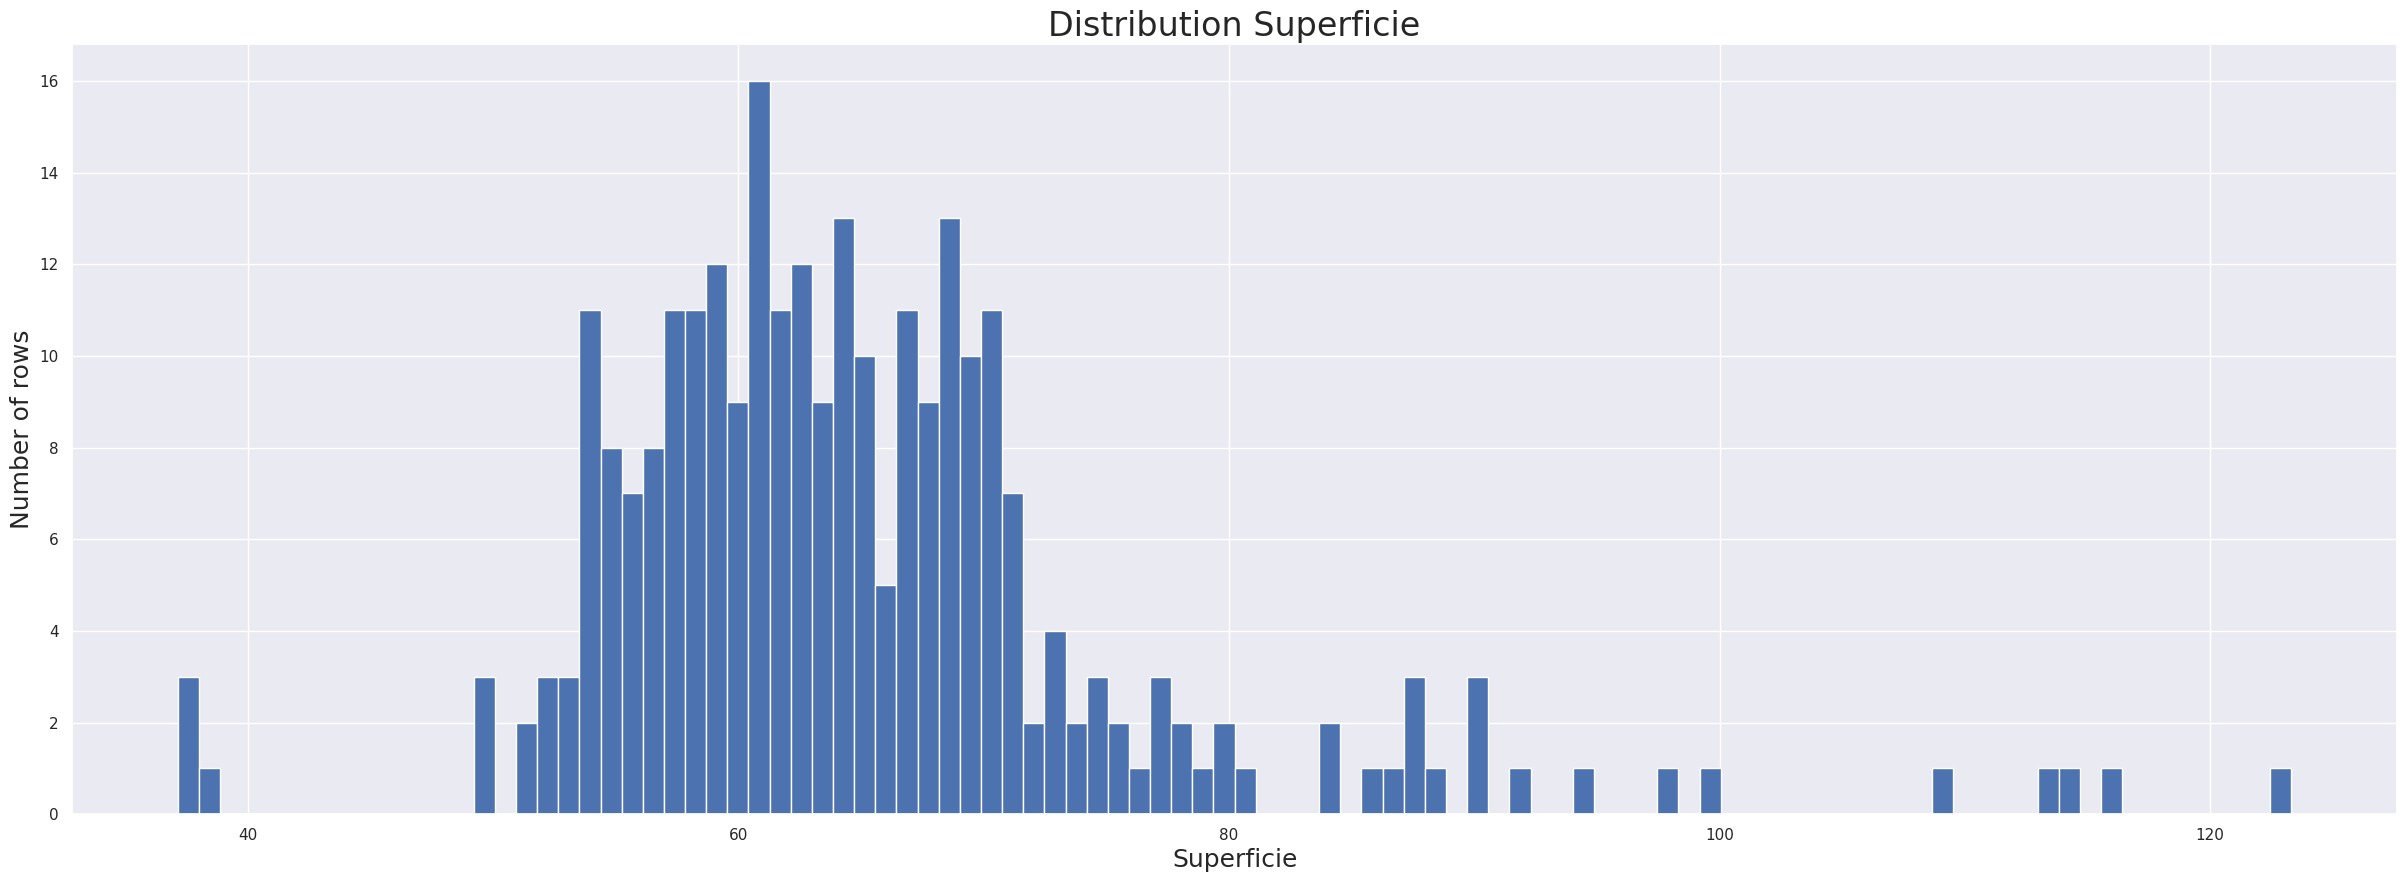

In [49]:
plt.hist(df_comb['Preu'],bins=100)
plt.ylabel('Number of rows',fontsize=18)
plt.xlabel('Preu',fontsize=18)
plt.title('Distribution Preu',fontsize=24)
plt.show()

plt.hist(df_comb['Preu/m2'],bins=100)
plt.ylabel('Number of rows',fontsize=18)
plt.xlabel('Preu/m2',fontsize=18)
plt.title('Distribution Preu/m2',fontsize=24)
plt.show()

plt.hist(df_comb['Superficie'],bins=100)
plt.ylabel('Number of rows',fontsize=18)
plt.xlabel('Superficie',fontsize=18)
plt.title('Distribution Superficie',fontsize=24)
plt.show()

Como podemos ver en estos histogramas, si bien tenemos unos valores del cuerpo principal de la distribución (las viviendas grandes y caras de Pedralbes y Les Tres Torres o las viviendas zulo de la Barceloneta) estos valores no se corresponden con valores erróneos. Debido a esto y a que si limpiaramos el dataset de outliers perderiamos mucha información, prescindiremos de realizar un tratamiento de los mismos.

### Correlacion Ruido y Precio de alquiler

A continuación vamos a ver la relación existente entre los precios de los alquileres (total y por metro cuadrado) con los rango de ruido, así como la relación de los rangos de ruido entre si mismos. El objetivo del primer punto será identificar la información más útil para el dataset de alquileres y del segundo punto el de prescindir de la información redundate dentro del propio dataset de ruido.

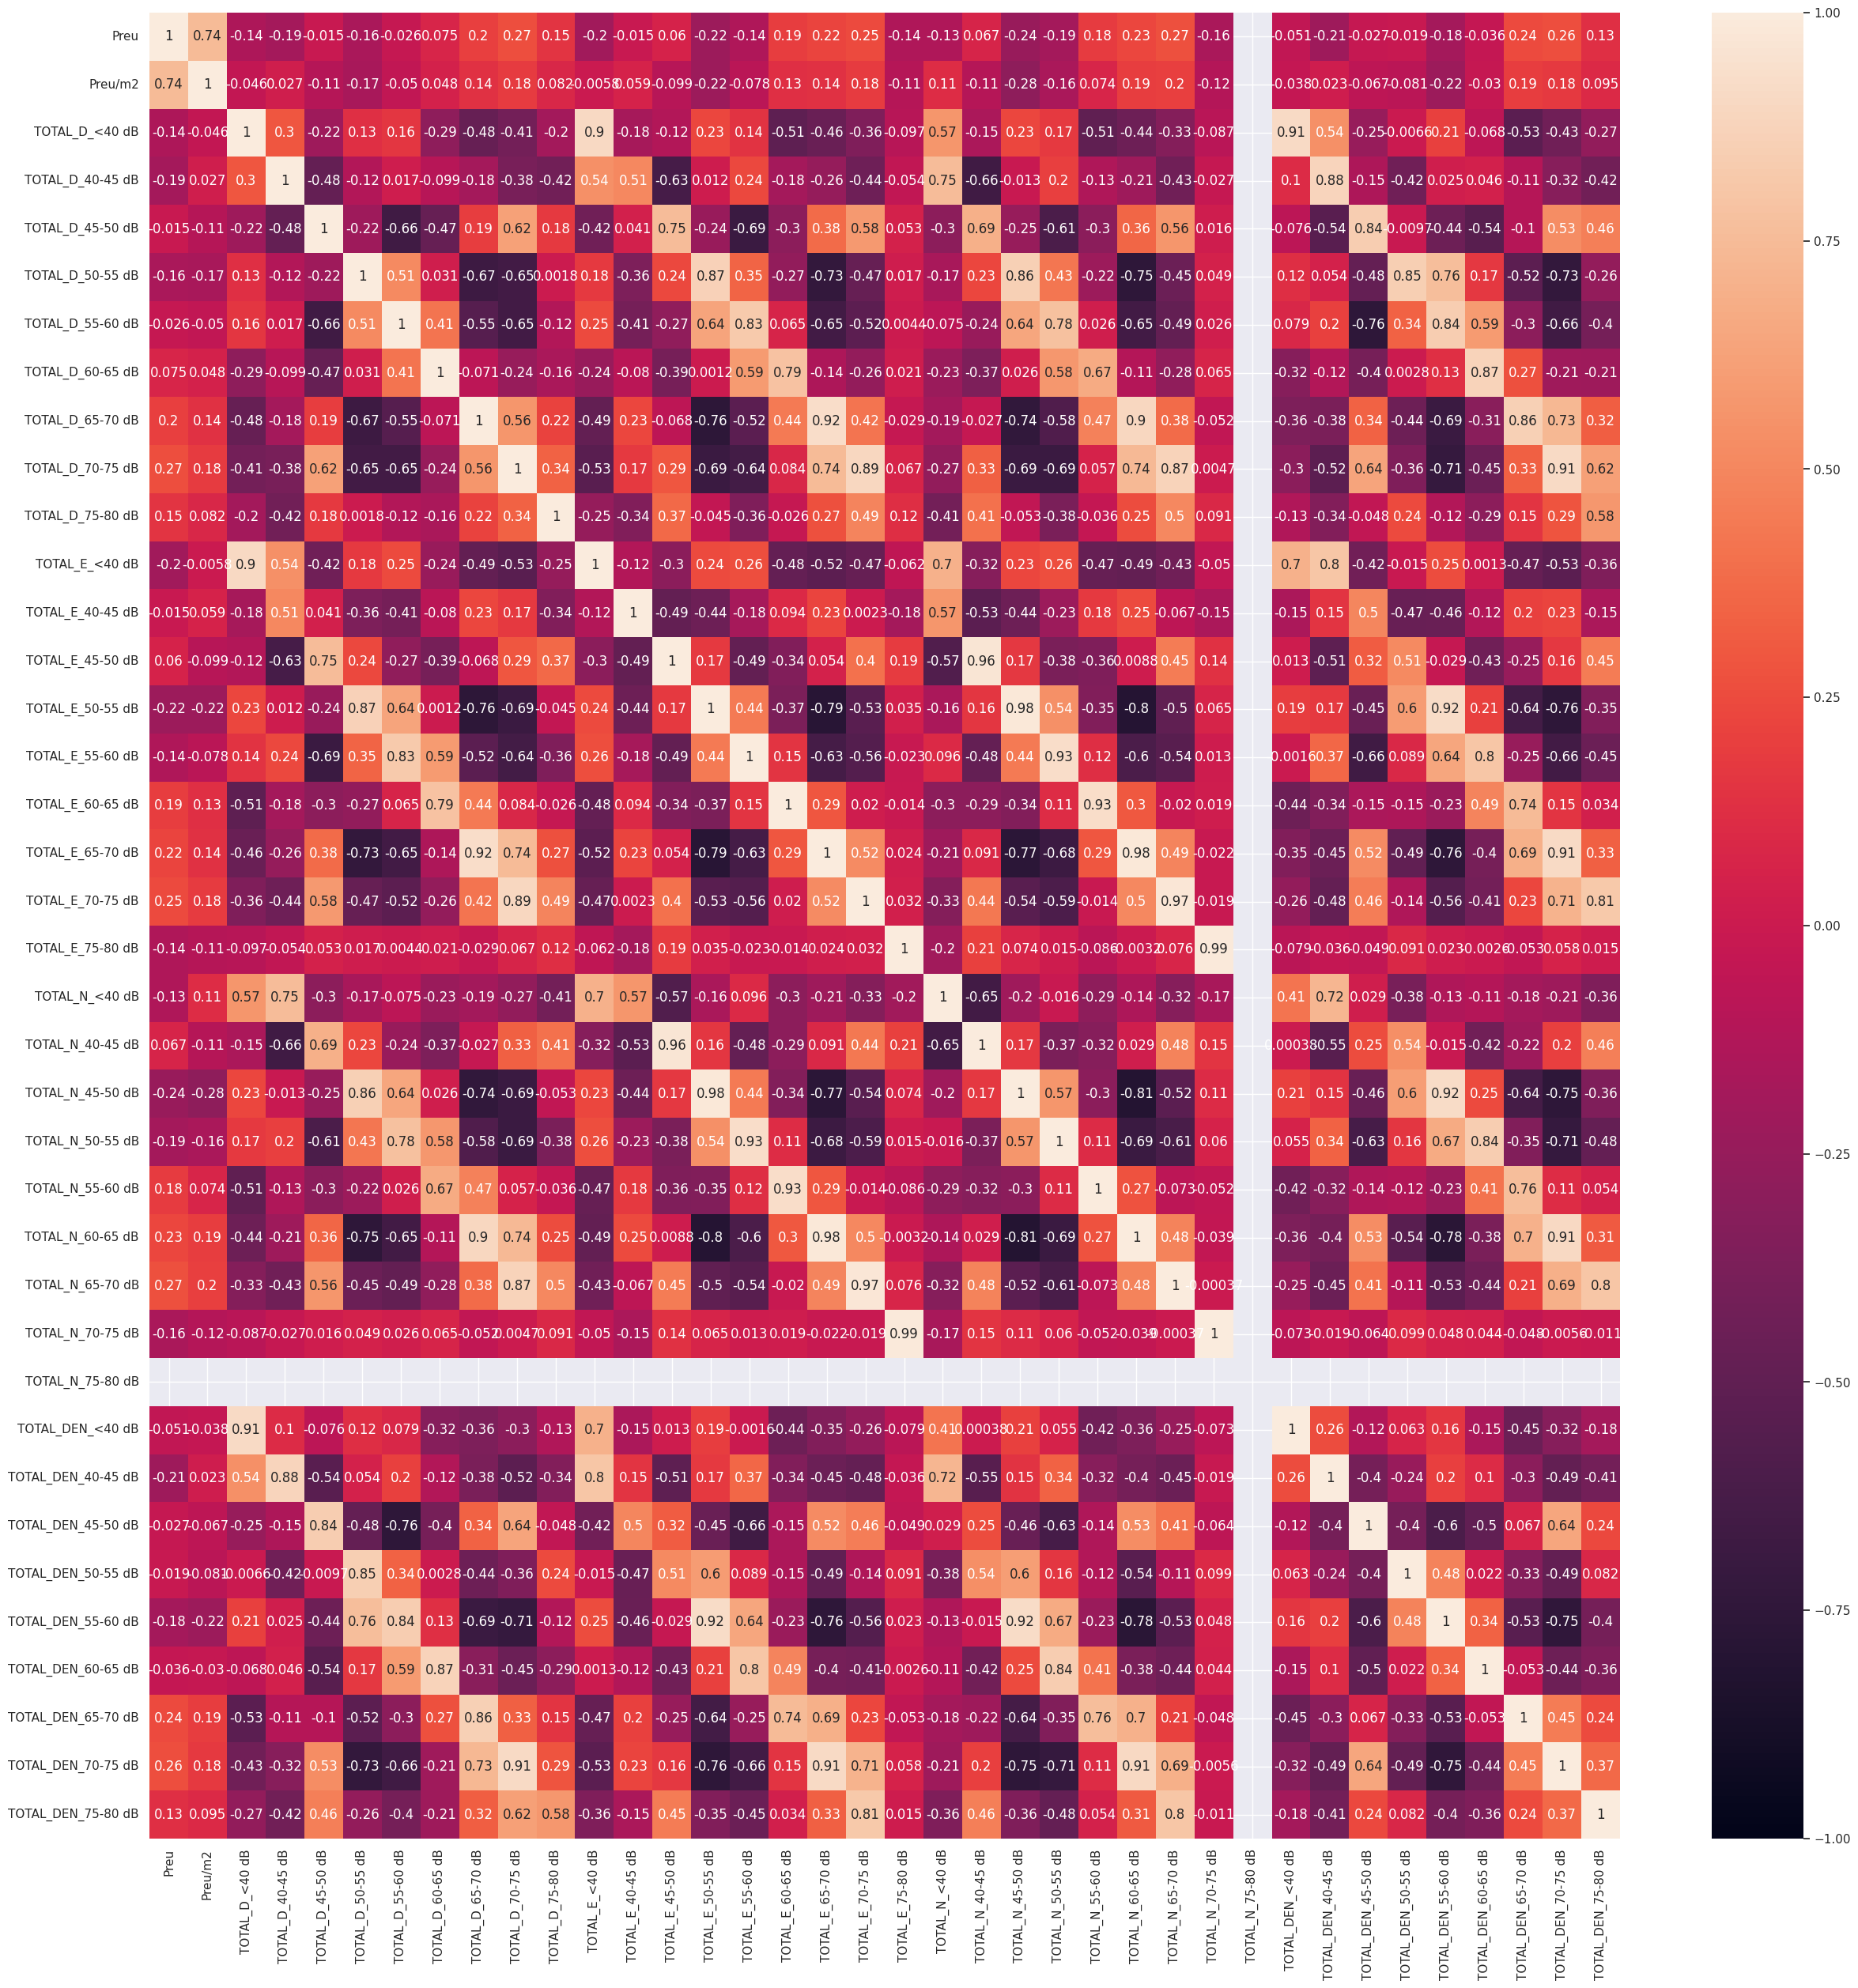

In [50]:
plt.figure(figsize=(30, 30))
sns.heatmap(df_comb.loc[:,['Preu','Preu/m2']+new_cols].corr(), vmin=-1, vmax=1, annot=True);


Como vemos no existe una gran correlación entre el precio y los rangos de ruido (así como 'TOTAL_N_75-80 dB' siempre toma valor 0), lo máximo que tenemos es una correlación débil positiva (>0.2) para varios valores altos de ruido y débil negativa (<-0.2) para un número más reducido de valores bajos de ruido, existiendo una correlación negativa fuerte entre ambas correlaciones (p.ej 'TOTAL_N_45-50 dB' con 'TOTAL_N_60-65 dB'), por lo que podemos quedarnos únicamente con los rangos altos de ruido. Por otra parte, podemos ver que la franja DEN que comprende las 3 franjas horarias, priorizando los valores de D (mañana), esta altamente correlacionada con la franja D y en menor medida con E y N. Dado que los rangos de ruido relevantes para el precio en las franjas D, E y DEN son 65-70dB y 70-75dB, y los rangos para la franja nocturna son 60-65dB y 65-70dB, nos quedaremos los dichas conlumnas de rango de ruido para las franjas DEN y N.

In [52]:
df_comb_reduced=df_comb[new_df_alquiler.columns.to_list()+['TOTAL_DEN_65-70 dB','TOTAL_DEN_70-75 dB','TOTAL_N_60-65 dB','TOTAL_N_65-70 dB']].copy()
df_comb_reduced

Trimestre  Codi_Districte  Codi_Barri     Preu  Preu/m2  Superficie  \
0            1               1           1   734.99    13.50       54.44   
1            1               1           2   905.26    14.14       64.02   
2            1               1           3   722.78    19.46       37.14   
3            1               1           4   895.28    15.01       59.65   
4            1               2           5   871.08    12.77       68.21   
..         ...             ...         ...      ...      ...         ...   
267          4              10          69  1233.01    16.51       74.68   
268          4              10          70   621.32    10.40       59.74   
269          4              10          71   864.09    12.66       68.25   
270          4              10          72   790.58    10.83       73.00   
271          4              10          73   692.67    10.38       66.73   

    TOTAL_DEN_65-70 dB TOTAL_DEN_70-75 dB TOTAL_N_60-65 dB TOTAL_N_65-70 dB  
0                14.35               5.85            13.28             1.65  
1                12.75                5.5            10.24             4.75  
2                 6.26               0.73             3.52             0.85  
3                 9.02               4.23             8.67             2.03  
4                24.74              22.04            30.38             5.14  
..                 ...                ...              ...              ...  
267              20.53               4.97            12.28              0.0  
268               5.32               0.06             0.27              0.0  
269              23.01               8.52            13.38              0.0  
270              13.29               5.75             6.68              0.7  
271              13.08               4.05             6.09             0.15  

[272 rows x 10 columns]

## Clusterizacion de los Barrios

Una vez hemos obtenido el dataset final, vamos a proceder una clusterización de los barrios a través de la cual aplicaremos la estandarización de los datos y la reducción de dimensionalidad por PCA que se nos pedía en el enunciado. Para realizar dicha clusterización vamos a promediar los valores de los precios y superficie para los diferentes trimestres, así como vamos a prescindir de la información de la columna de trimestres y códigos.

In [53]:
df_cluster=df_comb_reduced.groupby('Codi_Barri').mean()
df_cluster=df_cluster.iloc[:,2:]
df_cluster

Preu  Preu/m2  Superficie TOTAL_DEN_65-70 dB  \
Codi_Barri                                                      
1            747.7150  13.8950     53.8075              14.35   
2            973.7675  14.1900     68.6175              12.75   
3            746.3100  19.8450     37.6050               6.26   
4            916.8375  15.7050     58.4025               9.02   
5            900.0975  13.0850     68.8075              24.74   
...               ...      ...         ...                ...   
69          1109.9775  16.0575     69.0650              20.53   
70           610.4900   9.9675     61.2700               5.32   
71           934.6925  12.9825     71.9775              23.01   
72           764.8600  10.8925     70.2375              13.29   
73           688.6100  10.1650     67.7475              13.08   

           TOTAL_DEN_70-75 dB TOTAL_N_60-65 dB TOTAL_N_65-70 dB  
Codi_Barri                                                       
1                        5.85            13.28             1.65  
2                         5.5            10.24             4.75  
3                        0.73             3.52             0.85  
4                        4.23             8.67             2.03  
5                       22.04            30.38             5.14  
...                       ...              ...              ...  
69                       4.97            12.28              0.0  
70                       0.06             0.27              0.0  
71                       8.52            13.38              0.0  
72                       5.75             6.68              0.7  
73                       4.05             6.09             0.15  

[68 rows x 7 columns]

Tanto los datos de alquileres como los de ruido se ajustan bastante a una distribución normal, por lo que vamos a usar la estandarización sobre dichos datos.

In [54]:
scaler = StandardScaler()
data_scaled=scaler.fit_transform(df_cluster)

Una vez realizada la estandarización ya podemos aplicar el análisis de componentes principales. Si queremos reprentar visualmente la visualización necesitariamos reducir las dimensiones a 2 o 3 componentes principales. No obstante, será necesario calcular la varianza explicada de dicho proceso para saber si la reducción conserva la mayoría de la información o no.

In [55]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_2D=pca.fit_transform(data_scaled)
print(f'Varianza explicada de PCA: {np.round(np.sum(pca.explained_variance_ratio_),2)}')

Varianza explicada de PCA: 0.72


Como vemos, reducir las dimensiones del datasets a 2 únicas componentes principales, nos lleva a obtener sólo una varianza explicada del 72% de la información. Por tanto vamos a ver cuantas dimensiones mínimo deberíamos conservar si queremos mantener una varianza explicada del 95%.

In [56]:
pca95 = PCA(n_components=.95)
data_pca95=pca95.fit_transform(data_scaled)
print(f'Dimensiones para una varianza explicada 95: {data_pca95.shape[1]}')

Dimensiones para una varianza explicada 95: 5


Si queremos conservar la mayor parte de la información del dataset tenemos que almacenar 5 componentes principales, los cuales nos imposibilita ofrecer un representación visual de la clusterización. No obstante, calcularemos el mejor  número de clusters a utilizar mediante el coeficiente de Silhouette (que mide la cohesión interna de los clusters y su separabilidad del resto de clusters) y una vez se establezcan los clusters analizaremos que aspectos diferencia un cluster de otro.

In [57]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silh_coef_max=0
for n_clusters in range(2,10):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters)
    cluster_labels = clusterer.fit_predict(data_pca95)

    # Silhouette_score
    silhouette_avg = silhouette_score(data_pca95, cluster_labels)
    if silhouette_avg>silh_coef_max:
        silh_coef_max=silhouette_avg
        best_n_cluster = n_clusters
        best_cluster_labels = cluster_labels

print(f'El mejor número de clusters es: {best_n_cluster} con un coeficiente de Silhouette: {silh_coef_max}')

El mejor número de clusters es: 3 con un coeficiente de Silhouette: 0.27609295761608904


[]

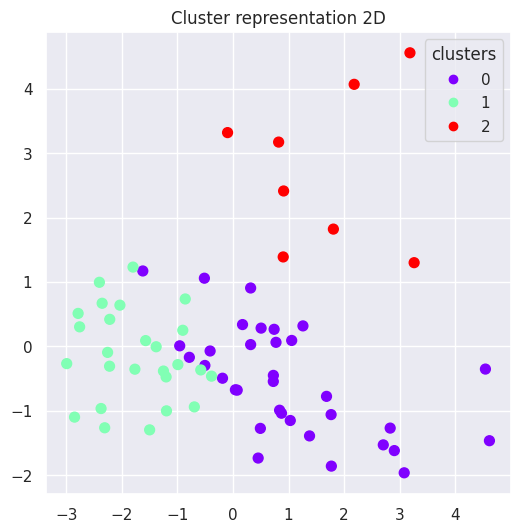

In [93]:
fig, ax = plt.subplots(figsize=(6,6))
sc = ax.scatter(data_2D[:,0], data_2D[:,1], c=best_cluster_labels, cmap='rainbow', s=50)
ax.legend(*sc.legend_elements(), title='clusters')
plt.title('Cluster representation 2D')
plt.plot()

Como vemos el mejor número de clusters, 3, no posee un elevado coeficiente de Silhouette. No obstante, aunque exploremos con un mayor número de clusters, el coeficiente de Silhouette será bastante bajo debido a la poca separabilidad del dataset (como podemos observar si representamos visualmente el dataset en 2D). Por tanto, aprovecharemos que hemos obtenido un bajo número de clusters para entrenar un modelo con la información del cluster como clase y extraer los SHAP values para cada cluster, con el objetivo de explicar las diferencias de cada uno de ellos.

In [60]:
#Entrenamos un clasificador Random Forest
X=np.array(df_cluster)
clf=RandomForestClassifier(n_estimators=300)
clf.fit(X,best_cluster_labels)
#Nos aseguramos que el clasificador aprendió correctamente los clusters
y_pred=clf.predict(X)
accuracy_score(best_cluster_labels, y_pred)

1.0

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


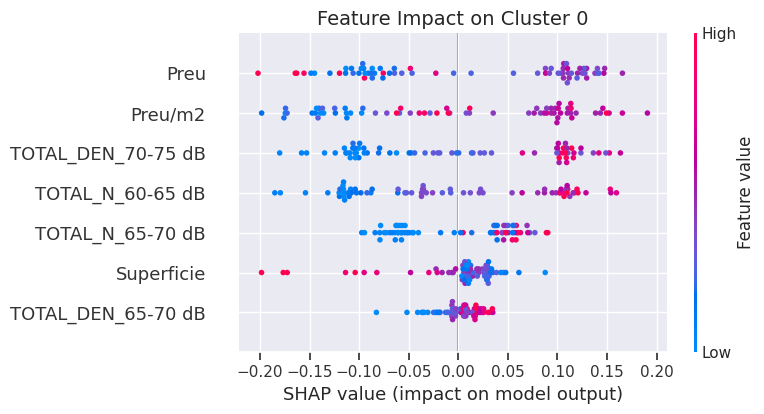

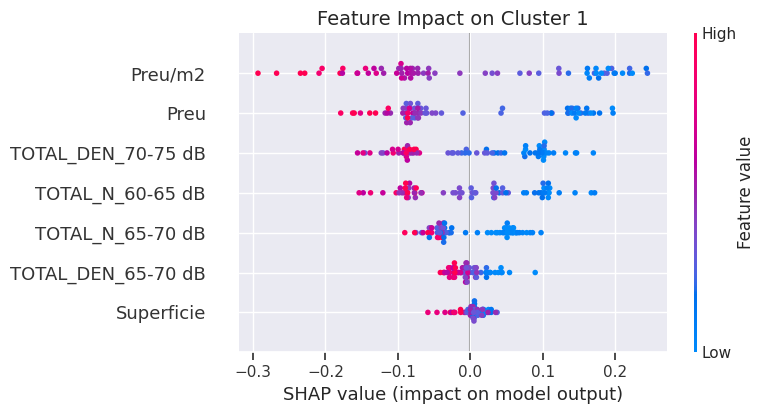

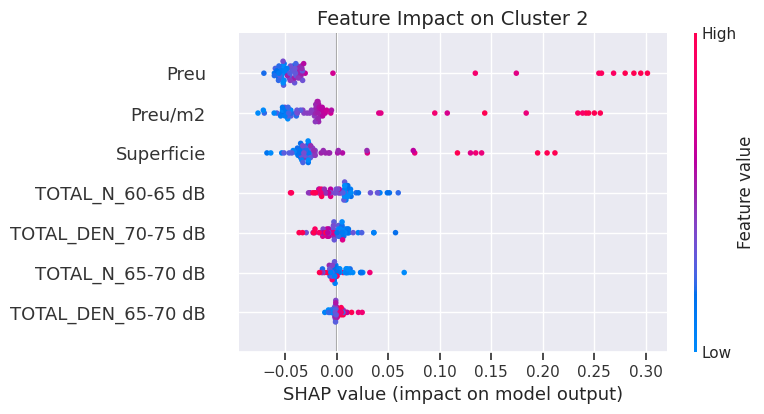

In [61]:
#Calculamos los SHAP Values
explainer=shap.TreeExplainer(clf)
shap_values = explainer.shap_values(X)
for i in range(best_n_cluster):
    plt.title('Feature Impact on Cluster '+str(i), fontsize=14)
    shap.summary_plot(shap_values[i], X, feature_names=df_cluster.columns, show=False)
    plt.gcf().axes[-1].set_aspect(100)
    plt.gcf().axes[-1].set_box_aspect(100)
    plt.show()

Podemos observar que el primer cluster, Cluster 0, se enfoca en aquellas viviendas con un precio promedio y con registros altos de ruido elevado. Por su parte, el segundo cluster, Cluster 1, se enfoca en aquellas viviendas baratas y escasos registros de ruido elevado. Finalmente, el tercer cluster, Cluster 2, se enfoca en viviendas muy caras y de grandes superficies.